# 2024-03-28 30v3 - Implementing gridsearch and analyzing its impact-- REBUTTALS.ipynb
Clone of `2024-01-30 30 - Implementing gridsearch and analyzing its impact.ipynb`. This is the main notebook for the generation of new plots and tables for the rebuttal requests. 

The plan is to include: 
- New models (iTransformer, Pyraformer, etc)
- New datasets (ETTh,ETTm, illness, traffic)
- Some cleanup specific to the new datasets and models.
- New plots and tables to satisfy reviewers requests
- Cleanups and refactors to common data processing and plot functions.

## Parameters

In [221]:
# Needed to filter on the gridsearch
CONSTRAINT_TYPE='constant'
#CONSTRAINT_TYPE='monotonic'

Folder name

In [222]:
import datetime
import os 

today = datetime.date.today()
formatted_date = today.strftime("%Y-%m-%d")

# Figures will be stored here.
#FIGURES_FOLDER = f"../figures/icml_monotonic_{formatted_date}"
FIGURES_FOLDER = f"../figures/icml_post_rebuttal"


os.makedirs(FIGURES_FOLDER, exist_ok=True)
FIGURES_FOLDER

'../figures/icml_post_rebuttal'

## Libraries and setup

In [223]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [224]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

In [225]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
from IPython.display import display, Markdown, Latex
import itertools
from itertools import product

In [226]:
from utils import wandb_utils

## Data loading
From the cached pkl files. If they break, use the CSV ones.

### Resilience data
The original resilience runs from the paper are in this dataset. Rebuttal runs did not have resilience as of march 28 morning.
### Non resilience data
Original experiment data including non-resilience constant-$\epsilon$ runs

In [227]:
#df_to_plot.query("model=='Autoformer' and constraint_type=='constant' and pred_len==720 and data_path=='exchange_rate.csv'").run_id.unique()
df_to_plot.query('run_id=="7a1cn1nb"').constraint_level.unique()

array([], dtype=float64)

In [228]:
CONSTRAINT_TYPE='constant' 
# To clean up some messes.
og_models=["Autoformer","Informer","Reformer","Transformer"]

# Resilience runs will be merged later to the df.
real_df_resilience = pd.read_pickle("../data_backups/2024_02_01_1038am__icml_backup_data.pkl")
real_df_resilience = real_df_resilience.query('constraint_type=="constant_resilience" or constraint_type=="erm"')

# Real data is the original set of runs
#real_df = pd.read_pickle("../data_backups/2024_02_01_1038am__icml_backup_data.pkl")
real_df = pd.read_pickle("../data_backups/2024_03_29__original_experiments.pkl") # New dataset with updated loader
#real_df = real_df.query('constraint_type=="constant" or constraint_type=="erm"')
real_df = real_df.query('constraint_type==@CONSTRAINT_TYPE or (constraint_type=="erm" and seed==2021)') # Avoid duplicate ERMs.

# PATCHING ONE AUTOFORMER BUGGED RUN (old run: 7a1cn1nb, new run: m6ml2r6i)
# Replace because the multipliers weren't converging and we need to showcase them. Otherwise they should be equivalent.
# #TODO Add proper tags and organize these
df__autoformer_exchange_720_constant_patch = wandb_utils.get_experiment_data(project="Autoformer-javierdev",workspace='alelab',experiment_tags=['dev_may26_2'])
# Replacement:  OLD: ji1b4frm NEW: 4sp1p4t3 
df__autoformer_exchange_720_resilience_patch = wandb_utils.get_experiment_data(project="Autoformer-javierdev",workspace='alelab',experiment_tags=['dev_may26_2_resilience'])

real_df = pd.concat([real_df.query('run_id!="7a1cn1nb"'),df__autoformer_exchange_720_constant_patch], ignore_index=True,axis=0)
real_df_resilience = pd.concat([real_df_resilience.query('run_id!="ji1b4frm"'),df__autoformer_exchange_720_resilience_patch], ignore_index=True,axis=0)

# These two are the rebuttal runs
#real_df_newdatasets = pd.read_pickle("../data_backups/2024_03_28__newdatasets_erm_and_constrained.pkl")
real_df_newdatasets = pd.read_pickle("../data_backups/2024_04_17__newdatasets_erm_and_constrained_w_val.pkl") #newer version with both train and val constraints.
# Filter unused models or wrongly tagged, and duplicate Pyraformer ERM runs.
#real_df_newmodels = pd.read_pickle("../data_backups/2024_03_28__newmodels_erm_and_constrained.pkl") \
real_df_newmodels = pd.read_pickle("../data_backups/2024_03_29__newmodels_erm_and_constrained.pkl") \
        .query('model!="TimesNet"') \
        .query('model!="Transformer"') \
        .query('model!="Reformer"') \
        .query('model not in @og_models') \
        .copy()#TODO delete?
real_df_newmodels_newdatasets = pd.read_pickle("../data_backups/2024_04_17__newdatasets_newmodels_erm_and_constrained.pkl")#TODO delete?

real_df_all_rebuttal_experiments_raw = pd.read_pickle("../data_backups/2024_05_14__rebuttal_all_new_erm_and_constrained.pkl").query('model!="TimesNet"')
# TODO temp, add missing pyraformer
temp_pyra_df = pd.read_pickle("../data_backups/2024_05_23__temp_pyra_dl.pkl")
real_df_all_rebuttal_experiments_raw = pd.concat([real_df_all_rebuttal_experiments_raw,temp_pyra_df], ignore_index=True,axis=0)

# Split into resilience and constant
real_df_all_rebuttal_experiments_resilience = real_df_all_rebuttal_experiments_raw.query('constraint_type=="constant_resilience" or constraint_type=="erm"')
#real_df_all_rebuttal_experiments = real_df_all_rebuttal_experiments_raw.query('constraint_type==@CONSTRAINT_TYPE or (constraint_type=="erm" and seed==2021)') # OLD LINE. THIS DROPS UNDESIRED PLOTS.
real_df_all_rebuttal_experiments = real_df_all_rebuttal_experiments_raw.query('constraint_type==@CONSTRAINT_TYPE or (constraint_type=="erm")') # Avoid duplicate ERMs.
# Append new runs resilience together
real_df_resilience = pd.concat([real_df_resilience,real_df_all_rebuttal_experiments_resilience], ignore_index=True,axis=0)

# Add all except resilience for now
# df = pd.concat([real_df,real_df_newmodels,real_df_newdatasets,real_df_newmodels_newdatasets], ignore_index=True,axis=0)
df = pd.concat([real_df,real_df_all_rebuttal_experiments], ignore_index=True,axis=0)
df = df.query("run_id not in ['8ebn797a', 'f3h5d2k9', 'l4zii0ej', 'nusqty14', 'v2aqitjd','2u2orrgj', 'bbedl2fm', 'lqqgbl0c']").copy()#TODO what were these?
# Drop duplicates in one fell swoop
df = df \
        .groupby(['model','data_path','constraint_type','seed','constraint_level','pred_len'],dropna=False)['run_id'].first().reset_index()[['run_id']] \
        .merge(df, on='run_id')

# Do the same on resilience runs 
real_df_resilience = real_df_resilience \
        .groupby(['model','data_path','constraint_type','seed','constraint_level','pred_len'],dropna=False)['run_id'].first().reset_index()[['run_id']] \
        .merge(real_df_resilience, on='run_id')

display(real_df_resilience[['constraint_type','resilient_lr']].drop_duplicates())
display(df.head())

100%|██████████| 1/1 [00:00<00:00, 64.12it/s]


Fetched 1 runs
Total records: (2160, 120)
Total runs: 1
Total runs missing cvar 1
Run IDs missing CVAR: ['m6ml2r6i']


100%|██████████| 1/1 [00:00<00:00, 42.95it/s]


Fetched 1 runs
Total records: (2160, 120)
Total runs: 1
Total runs missing cvar 1
Run IDs missing CVAR: ['65knv0z5']


constraint_type  resilient_lr
0       constant_resilience           0.1
24192                   erm           0.0
137088                  erm           NaN

run_id                                                des  gpu  itr  \
0  ncvpdj0w  Constrained Trained New Datasets ETTh1.csv Aut...    0    1   
1  ncvpdj0w  Constrained Trained New Datasets ETTh1.csv Aut...    0    1   
2  ncvpdj0w  Constrained Trained New Datasets ETTh1.csv Aut...    0    1   
3  ncvpdj0w  Constrained Trained New Datasets ETTh1.csv Aut...    0    1   
4  ncvpdj0w  Constrained Trained New Datasets ETTh1.csv Aut...    0    1   

   d_ff    data freq loss  seed  c_out  ... seg_len multistep task_name  \
0  2048  custom    h  mse  2021      7  ...    48.0     False       NaN   
1  2048  custom    h  mse  2021      7  ...    48.0     False       NaN   
2  2048  custom    h  mse  2021      7  ...    48.0     False       NaN   
3  2048  custom    h  mse  2021      7  ...    48.0     False       NaN   
4  2048  custom    h  mse  2021      7  ...    48.0     False       NaN   

   hidden_dim  num_blocks  dynamic_dim  num_kernels  hidden_layers  \
0        64.0         3.0        128.0          NaN            2.0   
1        64.0         3.0        128.0          NaN            2.0   
2        64.0         3.0        128.0          NaN            2.0   
3        64.0         3.0        128.0          NaN            2.0   
4        64.0         3.0        128.0          NaN            2.0   

   p_hidden_dims  p_hidden_layers  
0            NaN              NaN  
1            NaN              NaN  
2            NaN              NaN  
3            NaN              NaN  
4            NaN              NaN  

[5 rows x 120 columns]

In [229]:
# Debugging missing pyraformer for ablation
real_df_all_rebuttal_experiments_raw.query('data_path=="exchange_rate.csv" and model=="Pyraformer" and pred_len==720 and constraint_type=="constant"').constraint_level.unique()

array([0.065, 0.063, 0.06 , 4.866, 3.794, 2.394])

In [230]:
# Check for duplicates?
df[['model','data_path','constraint_type','seed','constraint_level','pred_len']].drop_duplicates().nunique()
df[['model','data_path','constraint_type','seed','constraint_level','pred_len']].shape
df[['run_id','model','data_path','constraint_type','seed','constraint_level','pred_len']].groupby(['model','data_path','constraint_type','seed','constraint_level','pred_len'])['run_id'].nunique() \
    .sort_values(ascending=False)

model         data_path          constraint_type  seed  constraint_level  pred_len
Autoformer    ETTh1.csv          constant         2021  0.246             96          1
Reformer      ETTm2.csv          constant         2021  0.094             336         1
                                                        0.563             192         1
                                                        0.544             96          1
                                                        0.495             96          1
                                                                                     ..
Informer      exchange_rate.csv  constant         2021  0.046             192         1
                                                        0.042             192         1
                                                        0.041             96          1
                                                        0.040             192         1
iTransformer  weather.csv        cons

In [231]:
print(f"Total number of runs: {df.run_id.nunique()}")
print(f"Total number of models: {df.model.nunique()}")
print(f"Total number of datasets: {df.data_path.nunique()}")

Total number of runs: 1953
Total number of models: 8
Total number of datasets: 9


In [232]:
df.data_path.unique()

array(['ETTh1.csv', 'ETTh2.csv', 'ETTm1.csv', 'ETTm2.csv',
       'electricity.csv', 'exchange_rate.csv', 'national_illness.csv',
       'traffic.csv', 'weather.csv'], dtype=object)

In [233]:
df.query('model=="FiLM"').data_path.unique()

array(['ETTh1.csv', 'ETTh2.csv', 'ETTm1.csv', 'ETTm2.csv',
       'electricity.csv', 'exchange_rate.csv', 'national_illness.csv',
       'traffic.csv', 'weather.csv'], dtype=object)

In [234]:
# Sanity check: See if runs were loaded twice.
steps_per_run_split = df.groupby(['run_id','model','data_path','split','pred_len'])['step'].count().reset_index()
steps_per_run_split[steps_per_run_split.pred_len!=steps_per_run_split.step]

run_id       model          data_path  split  pred_len  step
3162  jlfft8it  Pyraformer  exchange_rate.csv   test       720  1440
3163  jlfft8it  Pyraformer  exchange_rate.csv  train       720  1440
3164  jlfft8it  Pyraformer  exchange_rate.csv    val       720  1440
4533  rww9resh  Pyraformer  exchange_rate.csv   test       720  1440
4534  rww9resh  Pyraformer  exchange_rate.csv  train       720  1440
4535  rww9resh  Pyraformer  exchange_rate.csv    val       720  1440
4782  tpmphh0x  Pyraformer  exchange_rate.csv   test       720  1440
4783  tpmphh0x  Pyraformer  exchange_rate.csv  train       720  1440
4784  tpmphh0x  Pyraformer  exchange_rate.csv    val       720  1440

### ALTERNATIVE DATALOADING: MONOTONIC + RESILIENCE
For some ad hoc plots required by the rebuttal.

In [235]:
# #CONSTRAINT_TYPE='constant' #TODO see if we will need this.


# # Real data is the original set of runs
# #real_df = pd.read_pickle("../data_backups/2024_02_01_1038am__icml_backup_data.pkl")
# real_df = pd.read_pickle("../data_backups/2024_03_29__original_monotonic_plus_erm.pkl") # New dataset with updated loader

# real_df_resilience = real_df.query("constraint_type=='monotonic_resilience' or constraint_type=='erm'")
# real_df_resilience = real_df_resilience.query('constraint_type=="monotonic_resilience" or constraint_type=="erm"')

# real_df = real_df.query('constraint_type=="monotonic" or constraint_type=="erm"')
# df = real_df

# display(real_df_resilience[['constraint_type','resilient_lr']].drop_duplicates())
# display(df[['constraint_type','resilient_lr']].drop_duplicates())
# display(df.head())

In [236]:
df.constraint_type.unique()

array(['constant', 'erm'], dtype=object)

In [237]:
real_df_newmodels.groupby(['model','constraint_type'])['run_id'].nunique().reset_index()

model constraint_type  run_id
0                       FiLM        constant      36
1                       FiLM             erm      16
2  Nonstationary_Transformer        constant      57
3  Nonstationary_Transformer             erm      16
4                 Pyraformer        constant      57
5                 Pyraformer             erm      23
6               iTransformer        constant      46
7               iTransformer             erm      16

### (newmodels) Debug

In [238]:
display(real_df_newdatasets.constraint_type.unique())
real_df_newdatasets.groupby(['data_path','model','pred_len','seed','constraint_type'])['run_id'].nunique().reset_index().sort_values('run_id',ascending=True)

array(['constant', 'erm'], dtype=object)

data_path        model  pred_len        seed constraint_type  \
107        ETTm2.csv     Informer       192        2021             erm   
123        ETTm2.csv  Transformer       192        2021             erm   
125        ETTm2.csv  Transformer       336        2021             erm   
127        ETTm2.csv  Transformer       720        2021             erm   
128  electricity.csv   Pyraformer        96  1711151578             erm   
..               ...          ...       ...         ...             ...   
22         ETTh1.csv     Reformer       720        2021        constant   
102        ETTm2.csv   Autoformer       720        2021        constant   
86         ETTm1.csv     Reformer       720        2021        constant   
182      traffic.csv   Autoformer       720        2021        constant   
54         ETTh2.csv     Reformer       720        2021        constant   

     run_id  
107       1  
123       1  
125       1  
127       1  
128       1  
..      ...  
22        7  
102       7  
86        8  
182       8  
54        8  

[215 rows x 6 columns]

In [239]:
display(real_df_newmodels.constraint_type.unique())
real_df_newmodels.groupby(['data_path','model','pred_len','seed'])['run_id'].nunique().reset_index().sort_values('run_id',ascending=True)

array(['constant', 'erm'], dtype=object)

data_path                      model  pred_len        seed  \
65   exchange_rate.csv               iTransformer        96  1711663641   
81         traffic.csv  Nonstationary_Transformer       336  1711188502   
79         traffic.csv  Nonstationary_Transformer       192  1711186078   
77         traffic.csv  Nonstationary_Transformer        96  1711184315   
75         traffic.csv                       FiLM       720  1711458193   
..                 ...                        ...       ...         ...   
119        weather.csv                 Pyraformer       336        2021   
117        weather.csv                 Pyraformer       192        2021   
8      electricity.csv  Nonstationary_Transformer        96        2021   
12     electricity.csv  Nonstationary_Transformer       336        2021   
10     electricity.csv  Nonstationary_Transformer       192        2021   

     run_id  
65        1  
81        1  
79        1  
77        1  
75        1  
..      ...  
119       6  
117       6  
8         6  
12        6  
10        6  

[131 rows x 5 columns]

In [240]:
df.groupby(['data_path','model','pred_len','seed'])['run_id'].nunique().reset_index().sort_values('run_id',ascending=True)

data_path         model  pred_len        seed  run_id
181  exchange_rate.csv          FiLM        96  1711288809       1
223  exchange_rate.csv  iTransformer       720  1711663733       1
221  exchange_rate.csv  iTransformer       336  1711663713       1
219  exchange_rate.csv  iTransformer       192  1711663677       1
217  exchange_rate.csv  iTransformer        96  1711663641       1
..                 ...           ...       ...         ...     ...
177  exchange_rate.csv    Autoformer       192        2021       7
178  exchange_rate.csv    Autoformer       336        2021       7
160    electricity.csv      Reformer        96        2021       7
314        weather.csv          FiLM       192        2021       8
312        weather.csv          FiLM        96        2021       9

[363 rows x 5 columns]

### Summary of runs per dataset

In [241]:
# If there are not seven runs per set (6 constrained and one erm) means probably missing runs.
# As of march 28 there are some missing runs but we'll leave it like that for now.
runs_per_groupset=df.groupby(['data_path','model','pred_len','seed'])['run_id'].nunique().reset_index()
runs_per_groupset[runs_per_groupset.run_id!=7]

data_path         model  pred_len        seed  run_id
36     ETTh2.csv          FiLM        96        2021       6
37     ETTh2.csv          FiLM       192        2021       6
119    ETTm2.csv      Reformer       720        2021       6
120    ETTm2.csv   Transformer        96        2021       6
121    ETTm2.csv   Transformer       192        2021       6
..           ...           ...       ...         ...     ...
358  weather.csv  iTransformer       192  1711477522       1
359  weather.csv  iTransformer       336        2021       3
360  weather.csv  iTransformer       336  1711477724       1
361  weather.csv  iTransformer       720        2021       3
362  weather.csv  iTransformer       720  1711477957       1

[151 rows x 5 columns]

## Data processing
This section contains processing specific to this experiment set. If you clone this notebook. Remove or refactor this section.

### Gridsearch function (todo extract into script)
Meant to be used on `df_constrained` (containing only constant constrained `df`)

In [242]:
def gridsearch(runs_df, objective_col, gridsearch_keys, reference_cols, split='val',mode='mean'):
    """
    Performs a gridsearch across the runs under `gridsearch_keys`, with the objective of minimizing `objective_col`.
    
    Parameters
    ---
    mode: is either 'mean' or 'std', to choose which statistic of the objective value to use for the gridsearch.
    
    Returns 
    ---
    
        the runs_df filtered by the best runs, and the summary metric of the best runs.
    """
    grouped_cols = gridsearch_keys + reference_cols + ['constraint_level'] #todo maybe don't need to hardcode this
    summary_metric = objective_col

    run_gridsearch_stats = runs_df.query(f"split=='{split}'").groupby(grouped_cols).agg(
        mean_objective=(objective_col, 'mean'),
        std_objective=(objective_col, 'std'),
        #mean_constraint_violation=('constraint_violation', 'mean'), #is it worth having other stuff here?
        count=('step', 'size')
    ).reset_index().sort_values(['model', 'std_objective'])

    best_runs = run_gridsearch_stats.groupby(gridsearch_keys)[f'{mode}_objective'].idxmin()
    best_runs_df = run_gridsearch_stats.loc[best_runs, :]
    filtered_runs_df = runs_df[runs_df['run_id'].isin(best_runs_df['run_id'].unique())] #TODO run_id is a hard requirement in the group cols.

    return filtered_runs_df, best_runs_df[grouped_cols + [f'{mode}_objective']]

### Label constraint_levels (`constraint_idx` column)
useful for joining when the constraint values are different for each model.

In [243]:
# There are three constraint levels per run, add a rank column, sorted by constraint level.
df=df.copy()#df_constrained.copy()
if 'monotonic' not in CONSTRAINT_TYPE:
    #display(df[['seed','data_path','model','pred_len','constraint_level']].drop_duplicates().sort_values(['data_path','model','pred_len','constraint_level']).head())
    df.loc[df.constraint_type==CONSTRAINT_TYPE,'constraint_idx'] = df.query('constraint_type==@CONSTRAINT_TYPE').groupby(['seed','data_path','model','pred_len'])['constraint_level'].rank(method='dense', ascending=True).astype(int)
    df.loc[df.constraint_type=='erm','constraint_idx'] = 0
    df['constraint_idx'] = df['constraint_idx'].astype(int)
    # ranked_constraint_levels_summary = df[['run_id','data_path','model','pred_len','constraint_type','constraint_level','constraint_idx']].drop_duplicates('run_id').sort_values(['data_path','model','pred_len','constraint_level'])
    # print("Sanity checking on the summary")
    # display(ranked_constraint_levels_summary)
    
    # There are three constraint levels per run, add a rank column, sorted by constraint level.
    #The constraint idx column in resilience is used for reference in some of the table and plots
    real_df_resilience=real_df_resilience.copy()#df_constrained.copy()
    #display(df[['seed','data_path','model','pred_len','constraint_level']].drop_duplicates().sort_values(['data_path','model','pred_len','constraint_level']).head())
    real_df_resilience.loc[real_df_resilience.constraint_type==f'{CONSTRAINT_TYPE}_resilience','constraint_idx'] = real_df_resilience.query(f'constraint_type=="{CONSTRAINT_TYPE}_resilience"').groupby(['seed','data_path','model','pred_len'])['constraint_level'].rank(method='dense', ascending=True).astype(int)
    real_df_resilience.loc[real_df_resilience.constraint_type=='erm','constraint_idx'] = 0
    real_df_resilience['constraint_idx'] = real_df_resilience['constraint_idx'].astype(int)
    # ranked_constraint_levels_summary = real_df_resilience[['run_id','data_path','model','pred_len','constraint_type','constraint_level','constraint_idx']].drop_duplicates('run_id').sort_values(['data_path','model','pred_len','constraint_level'])
    # print("Sanity checking on the summary")
    # display(ranked_constraint_levels_summary)
else:
    print(f"{CONSTRAINT_TYPE} doesn't have a constraint level, Adding placeholder.")
    df.loc[df.constraint_type==CONSTRAINT_TYPE,'constraint_idx'] = 1
    df.loc[df.constraint_type=='erm','constraint_idx'] = 0
    real_df_resilience.loc[real_df_resilience.constraint_type==f'{CONSTRAINT_TYPE}_resilience','constraint_idx'] = 1
    real_df_resilience.loc[real_df_resilience.constraint_type=='erm','constraint_idx'] = 0
    real_df_resilience['constraint_idx'] = real_df_resilience['constraint_idx'].astype(int)
    # Constraint level must be set or else things break
    df['constraint_level'] = 0
    real_df_resilience['constraint_level'] = 0

### Create `is_monotonic`
A useful thing to have to compare infeasible_rate pct diff in monotonic

In [244]:
#df_to_plot.query('constraint_type=="erm"')
df=df.sort_values(['run_id','step'])
df['lag_1_mse'] = df.groupby('run_id')['mse'].shift(1)
df['mse_diff'] = df['lag_1_mse'] - df['mse'] #if positive, prev>current, not monotonic
df['is_monotonic'] = df['mse_diff'] < 0
#Sanity check:
display(df.loc[:,['run_id','step','lag_1_mse','mse','mse_diff','is_monotonic']])

real_df_resilience=real_df_resilience.sort_values(['run_id','step'])
real_df_resilience['lag_1_mse'] = real_df_resilience.groupby('run_id')['mse'].shift(1)
real_df_resilience['mse_diff'] = real_df_resilience['lag_1_mse'] - real_df_resilience['mse'] #if positive, prev>current, not monotonic
real_df_resilience['is_monotonic'] = real_df_resilience['mse_diff'] < 0
#Sanity check:
real_df_resilience.loc[:,['run_id','step','lag_1_mse','mse','mse_diff','is_monotonic']]

run_id  step  lag_1_mse       mse  mse_diff  is_monotonic
319032  00sihyn7     0        NaN  0.029923       NaN         False
319128  00sihyn7     0   0.029923  0.027864  0.002059         False
319224  00sihyn7     0   0.027864  0.034499 -0.006635          True
319033  00sihyn7     1   0.034499  0.060877 -0.026378          True
319129  00sihyn7     1   0.060877  0.057281  0.003596         False
...          ...   ...        ...       ...       ...           ...
27502   zz22ssmi   718   0.767370  1.253086 -0.485716          True
28222   zz22ssmi   718   1.253086  0.694911  0.558175         False
26783   zz22ssmi   719   0.694911  0.781259 -0.086348          True
27503   zz22ssmi   719   0.781259  1.259838 -0.478579          True
28223   zz22ssmi   719   1.259838  0.746520  0.513318         False

[1785096 rows x 6 columns]

run_id  step  lag_1_mse       mse  mse_diff  is_monotonic
1218024  00siegwl     0        NaN  0.117319       NaN         False
1218120  00siegwl     0   0.117319  0.183538 -0.066219          True
1218216  00siegwl     0   0.183538  0.130603  0.052935         False
1218025  00siegwl     1   0.130603  0.128430  0.002173         False
1218121  00siegwl     1   0.128430  0.227897 -0.099467          True
...           ...   ...        ...       ...       ...           ...
27502    zz22ssmi   718   0.767370  1.253086 -0.485716          True
28222    zz22ssmi   718   1.253086  0.694911  0.558175         False
26783    zz22ssmi   719   0.694911  0.781259 -0.086348          True
27503    zz22ssmi   719   0.781259  1.259838 -0.478579          True
28223    zz22ssmi   719   1.259838  0.746520  0.513318         False

[1817856 rows x 6 columns]

### Broadcast ERM runs with constraint levels and add gridsearch (`df_to_plot`)
to compare ERM with constrained, we need every ERM run repeated to pair it with a constrained run. For consistency, gridsearch is performed on non resilience runs and the same parameter is used for resilience.

In [245]:
if CONSTRAINT_TYPE != "monotonic":
    print("Non monotonic CONSTRAINT_TYPE: Performing gridsearch")
    df_constrained_nogridsearch = df.query('constraint_type==@CONSTRAINT_TYPE').copy()
    df_constrained,best_runs = gridsearch(df_constrained_nogridsearch,objective_col='mse', gridsearch_keys=['model', 'pred_len', 'data_path'],reference_cols=['run_id'],split='val')

    ###Now filter resilience runs to only gridsearched ones
    resilience_runs=real_df_resilience[['data_path','model','pred_len','constraint_idx','run_id']].drop_duplicates(['data_path','model','pred_len','constraint_idx'])
    gridsearched_runs=df_constrained[['data_path','model','pred_len','constraint_level','constraint_idx']].drop_duplicates()

    # sometimes there are two resilience runs for one gridsearched run, so we need to drop duplicates
    gridsearched_resilience_runs = gridsearched_runs.merge(resilience_runs,
                            on=['data_path','model','pred_len','constraint_idx'],how='inner') \
                                .drop_duplicates(['data_path','model','pred_len','constraint_idx'])[['run_id']].drop_duplicates()

    real_df_resilience_gridsearched=real_df_resilience.merge(gridsearched_resilience_runs,on='run_id')
    display(real_df_resilience_gridsearched.shape)

    df_erm = df.query('constraint_type=="erm"').copy()
    
    #(data_path,model,pred_len,constraint_level,constrained_unconstraled)
    distinct_constraints = df_constrained[['data_path','model','pred_len','constraint_idx','constraint_level']].drop_duplicates()

    # crossjoin the ERM mse to all constraint levels
    df_erm_w_broadcasted_constraint_levels = df_erm.drop(columns=['constraint_idx','constraint_level']).merge(distinct_constraints,on=['data_path','model','pred_len'],how='left')
    df_to_plot = pd.concat([
        df_constrained,
        df_erm_w_broadcasted_constraint_levels,
        real_df_resilience_gridsearched
        ],axis=0)

    # keep a df_to_plot without gridsearch (_nogs)
    distinct_constraints_nogs = df_constrained_nogridsearch[['data_path','model','pred_len','constraint_idx','constraint_level']].drop_duplicates()
    df_erm_w_broadcasted_constraint_levels_nogs = df_erm.drop(columns=['constraint_idx','constraint_level']).merge(distinct_constraints_nogs,on=['data_path','model','pred_len'],how='left')
    df_to_plot_nogs=pd.concat([
        df_constrained_nogridsearch,
        df_erm_w_broadcasted_constraint_levels_nogs,
        real_df_resilience
        ],axis=0)

    
    # sanity check
    #display(df_erm_w_broadcasted_constraint_levels.shape)
    #print(f"Three constraints per experiment, broadcasted dataset size be equal to {df_erm.shape[0]*1}")
    #display(df_to_plot.shape)
    #print(f"Final dataset size should be equal to {df_constrained.shape[0]+df_erm.shape[0]*1}")
else: 
    print("CANNOT GRIDSEARCH MONOTONIC")
    df_to_plot = pd.concat([df,real_df_resilience],axis=0)  
    df_to_plot_nogs = df_to_plot.copy() # just to not break existing plots that use one or the other
display(df_to_plot.shape)
display(df_to_plot_nogs.shape)
    

Non monotonic CONSTRAINT_TYPE: Performing gridsearch


(261792, 127)

(789984, 127)

(4874688, 127)

### Add constraint violation metric
This only makes sense for non "monotonic" constraint types.

In [246]:
# Adding the constraint violation column
#TODO THIS DEF OF CONSTRAINT VIOLATION IS CONSTANT
df_to_plot["constraint_violation"] = (df_to_plot.mse-df_to_plot.constraint_level).clip(lower=0)
df_to_plot['is_infeasible'] = (df_to_plot.constraint_violation>0)*1

# sanity check
dd=df_to_plot[['run_id','model','type','constraint_type','step','mse','constraint_level','constraint_violation','is_infeasible']].sort_values('run_id')
print("For ERM")
display(dd.query('constraint_type=="erm"').query('constraint_violation>0').head())
print("For Constrained")
display(dd.query('constraint_type==@CONSTRAINT_TYPE').query('constraint_violation>0').head())
print("For resilient")
display(dd.query(f'constraint_type=="{CONSTRAINT_TYPE}_resilience"').query('constraint_violation>0').head())


For ERM


run_id     model type constraint_type  step       mse  constraint_level  \
93  092u33lj  Reformer  ERM             erm    31  0.150609              0.15   
94  092u33lj  Reformer  ERM             erm    31  0.292026              0.15   
95  092u33lj  Reformer  ERM             erm    31  0.199232              0.15   
96  092u33lj  Reformer  ERM             erm    32  0.151061              0.15   
97  092u33lj  Reformer  ERM             erm    32  0.292199              0.15   

    constraint_violation  is_infeasible  
93              0.000609              1  
94              0.142026              1  
95              0.049232              1  
96              0.001061              1  
97              0.142199              1

For Constrained


run_id       model         type constraint_type  step       mse  \
960232  09nhiuyo  Pyraformer  Constrained        constant   544  0.786319   
960952  09nhiuyo  Pyraformer  Constrained        constant   544  0.712741   
960228  09nhiuyo  Pyraformer  Constrained        constant   540  0.784467   
960233  09nhiuyo  Pyraformer  Constrained        constant   545  0.779533   
960953  09nhiuyo  Pyraformer  Constrained        constant   545  0.688100   

        constraint_level  constraint_violation  is_infeasible  
960232             0.237              0.549319              1  
960952             0.237              0.475741              1  
960228             0.237              0.547467              1  
960233             0.237              0.542533              1  
960953             0.237              0.451100              1

For resilient


run_id       model         type      constraint_type  step       mse  \
907  0dayj159  Autoformer  Constrained  constant_resilience   206  0.749861   
914  0dayj159  Autoformer  Constrained  constant_resilience   208  0.508237   
908  0dayj159  Autoformer  Constrained  constant_resilience   206  0.510155   
906  0dayj159  Autoformer  Constrained  constant_resilience   206  0.519595   
910  0dayj159  Autoformer  Constrained  constant_resilience   207  0.747981   

     constraint_level  constraint_violation  is_infeasible  
907             0.454              0.295861              1  
914             0.454              0.054237              1  
908             0.454              0.056155              1  
906             0.454              0.065595              1  
910             0.454              0.293981              1

###  Add stepwise RMSE

In [247]:
#df_to_plot[df_to_plot['rmse_overall'].isna()][['constraint_type','model','data_path']].drop_duplicates()
#df_to_plot.loc[df_to_plot['rmse_overall'].isna(),'rmse_overall'] = np.sqrt(df_to_plot.loc[df_to_plot['rmse_overall'].isna(),'mse'])
#df_to_plot[~df_to_plot['rmse_overall'].isna()][['run_id','step','rmse_overall','split']].sort_values(['run_id','split','step'])

# Will implement stepwise RMSE but with a caveat that it's strange how to interpret RMSE stepwise because mean RMSE != RMSE of the mean.
df_to_plot['rmse']=np.sqrt(df_to_plot['mse'])
df_to_plot_nogs['rmse']=np.sqrt(df_to_plot_nogs['mse'])
# print(df_w_rmse_overall.query('run_id=="076y6rbc"').mse.mean())
# print(df_w_rmse_overall.query('run_id=="076y6rbc"').rmse.mean())
# print(df_w_rmse_overall.query('run_id=="076y6rbc"').rmse_overall.mean())

### Create `Resilience` `type` value and fix mislabels
For whatever reason, some values were marked ERM when constraint_type is actually constant,

In [248]:
df_to_plot.loc[df_to_plot.constraint_type==f'{CONSTRAINT_TYPE}_resilience','type'] = "Resilience"
df_to_plot_nogs.loc[df_to_plot_nogs.constraint_type==f'{CONSTRAINT_TYPE}_resilience','type'] = "Resilience"


# Bugfix wrong "ERMs"
df_to_plot.loc[df_to_plot.constraint_type==f'{CONSTRAINT_TYPE}','type'] = "Constrained"
df_to_plot_nogs.loc[df_to_plot_nogs.constraint_type==f'{CONSTRAINT_TYPE}','type'] = "Constrained"

# Just in case
df_to_plot.loc[df_to_plot.constraint_type=='erm','type'] = "ERM"
df_to_plot_nogs.loc[df_to_plot_nogs.constraint_type=='erm','type'] = "ERM"


### Summary metrics per run (`summary_metrics`)
Summarize all three runs into metrics per split by averaging mse and constraint levels.

In [249]:
df_to_plot.query('model=="Autoformer" and data_path=="electricity.csv"').groupby(['constraint_type','pred_len'])['mae_overall'].mean()

constraint_type      pred_len
constant             96          0.274620
                     192         0.300446
                     336         0.304683
                     720         0.329565
constant_resilience  96               NaN
                     192              NaN
                     336              NaN
                     720              NaN
erm                  96          0.279051
                     192         0.293191
                     336         0.330768
                     720         0.324123
Name: mae_overall, dtype: float64

In [250]:
df_to_plot.groupby([
    "data_path",
    "model",
    "pred_len",
    "run_id",
    "Algorithm", #Harmless carryover col for legacy purposes (verified the counts are the same)
    "constraint_type",
    'type',
    #"constraint_idx",
    "split",
    #"constraint_level",
    ]).size()

data_path    model         pred_len  run_id    Algorithm                  constraint_type      type         split
ETTh1.csv    Autoformer    96        3hvv22lo  ETTh1 Autoformer           constant             Constrained  test      96
                                                                                                            train     96
                                                                                                            val       96
                                     6ykrrsc2  ETTh1 Autoformer           constant_resilience  Resilience   test      96
                                                                                                            train     96
                                                                                                                    ... 
weather.csv  iTransformer  720       g5v8kf6o  weather iTransformer       constant             Constrained  train    720
                                       

In [251]:
# Calculate mean and std for mse and constraint_violation. Rename them mean_{metric} and std_{metric
#summary_metrics_per_run = df_to_plot_nogs.groupby([
summary_metrics_per_run = df_to_plot.groupby([
    "data_path",
    "model",
    "pred_len",
    "run_id",
    "Algorithm", #Harmless carryover col for legacy purposes (verified the counts are the same)
    "constraint_type",
    'type',
    "constraint_idx",
    "split",
    "constraint_level",
    ]).aggregate(
        mse=('mse','mean'),
        mae=('mae_overall','mean'),
        rmse=('rmse_overall','mean'),# Was already averaged anyways.
        linearity=('linearity_overall','mean'),
        monotonic_rate=('is_monotonic','mean'),
        window_std=('mse','std'),
        #std_mse=('mse','std'),
        #TODO commented out for monotonic
        mcv=('constraint_violation','mean'),
        std_mcv=('constraint_violation','std'),
        mean_infeasible_rate=('infeasible_rate','mean'),
        #std_infeasible_rate=('infeasible_rate','std'),
        run_count=('run_id','nunique')
        ).reset_index().round(5)
summary_metrics = summary_metrics_per_run.groupby([
    "data_path",
    "model",
    "pred_len",
    'type', #ERM or constrained
    "constraint_type",
    "split",
    #"Algorithm", # This caused problems so im removing it
    "constraint_idx",
    "constraint_level",
    ]).aggregate(
        mse=('mse','mean'),
        mae=('mae','mean'),
        rmse=('rmse','mean'),
        linearity=('linearity','mean'),
        window_std=('window_std','mean'),
        monotonic_rate=('monotonic_rate','mean'),
        std_mse=('mse','std'), #CAREFUL: THIS IS RUNWISE VARIANCE OF RUNWISE MEAN MSE.
        mcv=('mcv','mean'),
        std_mcv=('mcv','std'),
        mean_infeasible_rate=('mean_infeasible_rate','mean'),
        std_infeasible_rate=('mean_infeasible_rate','std'),
        run_count=('run_count','mean')
    ).reset_index()
display(summary_metrics_per_run.shape)
display(summary_metrics.shape)
summary_metrics.head()

(2601, 20)

(2589, 20)

data_path       model  pred_len         type constraint_type  split  \
0  ETTh1.csv  Autoformer        96  Constrained        constant   test   
1  ETTh1.csv  Autoformer        96  Constrained        constant  train   
2  ETTh1.csv  Autoformer        96  Constrained        constant    val   
3  ETTh1.csv  Autoformer        96          ERM             erm   test   
4  ETTh1.csv  Autoformer        96          ERM             erm  train   

   constraint_idx  constraint_level      mse      mae     rmse  linearity  \
0               6             0.533  0.64440  0.58816  0.80238    0.61650   
1               6             0.533  0.36397  0.40960  0.32390   -0.15983   
2               6             0.533  0.40338  0.45378  0.63468    0.91674   
3               6             0.533  0.67871  0.60687  0.82333    0.19729   
4               6             0.533  0.27643  0.36722  0.25443   -0.08874   

   window_std  monotonic_rate  std_mse      mcv  std_mcv  \
0     0.03235         1.00000      NaN  0.11149      NaN   
1     0.03481         0.02083      NaN  0.00000      NaN   
2     0.02903         0.00000      NaN  0.00000      NaN   
3     0.02408         1.00000      NaN  0.14595      NaN   
4     0.04269         0.00000      NaN  0.00000      NaN   

   mean_infeasible_rate  std_infeasible_rate  run_count  
0               0.79712                  NaN        1.0  
1               0.08333                  NaN        1.0  
2               0.08190                  NaN        1.0  
3               1.00000                  NaN        1.0  
4               1.00000                  NaN        1.0

#### Summary metrics NOGS

In [252]:
# Summary metrics nogs
# Calculate mean and std for mse and constraint_violation. Rename them mean_{metric} and std_{metric
#summary_metrics_per_run = df_to_plot_nogs.groupby([
summary_metrics_per_run_nogs = df_to_plot_nogs.groupby([
    "data_path",
    "model",
    "pred_len",
    "run_id",
    "Algorithm", #Harmless carryover col for legacy purposes (verified the counts are the same)
    "constraint_type",
    'type',
    "constraint_idx",
    "split",
    "constraint_level",
    ]).aggregate(
        mse=('mse','mean'),
        mae=('mae_overall','mean'),
        rmse=('rmse_overall','mean'),# Was already averaged anyways.
        linearity=('linearity_overall','mean'),
        monotonic_rate=('is_monotonic','mean'),
        window_std=('mse','std'),
        #std_mse=('mse','std'),
        #TODO commented out for monotonic
        # mcv=('constraint_violation','mean'),
        # std_mcv=('constraint_violation','std'),
        mean_infeasible_rate=('infeasible_rate','mean'),
        #std_infeasible_rate=('infeasible_rate','std'),
        run_count=('run_id','nunique')
        ).reset_index().round(5)
summary_metrics_nogs = summary_metrics_per_run_nogs.groupby([
    "data_path",
    "model",
    "pred_len",
    'type', #ERM or constrained
    "constraint_type",
    "split",
    "Algorithm",
    "constraint_idx",
    "constraint_level",
    ]).aggregate(
        mse=('mse','mean'),
        mae=('mae','mean'),
        rmse=('rmse','mean'),
        linearity=('linearity','mean'),
        window_std=('window_std','mean'),
        monotonic_rate=('monotonic_rate','mean'),
        std_mse=('mse','std'), #CAREFUL: THIS IS RUNWISE VARIANCE OF RUNWISE MEAN MSE.
        # mcv=('mcv','mean'),
        # std_mcv=('mcv','std'),
        mean_infeasible_rate=('mean_infeasible_rate','mean'),
        std_infeasible_rate=('mean_infeasible_rate','std'),
        run_count=('run_count','mean')
    ).reset_index()
display(summary_metrics_per_run_nogs.shape)
display(summary_metrics_nogs.shape)
summary_metrics_nogs.head()

(15825, 18)

(15825, 19)

data_path       model  pred_len         type constraint_type split  \
0  ETTh1.csv  Autoformer        96  Constrained        constant  test   
1  ETTh1.csv  Autoformer        96  Constrained        constant  test   
2  ETTh1.csv  Autoformer        96  Constrained        constant  test   
3  ETTh1.csv  Autoformer        96  Constrained        constant  test   
4  ETTh1.csv  Autoformer        96  Constrained        constant  test   

          Algorithm  constraint_idx  constraint_level      mse      mae  \
0  ETTh1 Autoformer               1             0.246  0.74954  0.63988   
1  ETTh1 Autoformer               2             0.262  0.69600  0.61194   
2  ETTh1 Autoformer               3             0.290  0.72397  0.62225   
3  ETTh1 Autoformer               4             0.507  0.80320  0.65609   
4  ETTh1 Autoformer               5             0.521  0.76816  0.63872   

      rmse  linearity  window_std  monotonic_rate  std_mse  \
0  0.86500   -0.53632     0.05451             1.0      NaN   
1  0.83347   -0.43999     0.04133             1.0      NaN   
2  0.85019   -0.30551     0.04563             1.0      NaN   
3  0.89562   -0.41739     0.07535             1.0      NaN   
4  0.87585   -0.24809     0.05338             1.0      NaN   

   mean_infeasible_rate  std_infeasible_rate  run_count  
0               1.00000                  NaN        1.0  
1               1.00000                  NaN        1.0  
2               1.00000                  NaN        1.0  
3               0.98155                  NaN        1.0  
4               0.96260                  NaN        1.0

In [253]:
summary_metrics.monotonic_rate

0       1.00000
1       0.02083
2       0.00000
3       1.00000
4       0.00000
         ...   
2584    0.01667
2585    1.00000
2586    0.00000
2587    0.05833
2588    1.00000
Name: monotonic_rate, Length: 2589, dtype: float64

In [254]:
summary_metrics.query("model=='Autoformer' and data_path=='electricity.csv'").groupby(['constraint_type','pred_len'])['mae'].mean()

constraint_type      pred_len
constant             96          0.274620
                     192         0.300447
                     336         0.304683
                     720         0.329567
constant_resilience  96               NaN
                     192              NaN
                     336              NaN
                     720              NaN
erm                  96          0.279050
                     192         0.293190
                     336         0.330770
                     720         0.324127
Name: mae, dtype: float64

### **--END OF PREPROCESSING--**

---
---
---
---
---
---
---
---

## Plots

### Utility functions

In [260]:
# plot utility functions:
def pretty_name_dataset(data_path):
    if data_path == "electricity.csv":
        return "Electricity"
    elif data_path == "weather.csv":
        return "Weather"
    elif data_path == "exchange_rate.csv":
        return "Exchange Rate"
    elif data_path == "traffic.csv":
        return "Traffic"
    elif data_path == "national_illness.csv":
        return "Illness"
    elif data_path == "ETTh1.csv":
        return "ETTh1"
    elif data_path == "ETTh2.csv":
        return "ETTh2"
    elif data_path == "ETTm1.csv":
        return "ETTm1"
    elif data_path == "ETTm2.csv":
        return "ETTm2"
    else:
        print(f"Warning: Didn't find dataset {data_path}")
        return data_path

# Standardize marker across all plots
MARKER_PER_TYPE={'ERM':'*','Constrained':'.','Resilience':','}
MARKER_PER_TYPE_BIG={'ERM':'X','Constrained':'o','Resilience': 'P'}

original_rcParams = plt.rcParams
paper_rcParams = {
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
}

def set_plot_config_paper():
    plt.rcParams['lines.linewidth'] = 1.8
    plt.rcParams['legend.borderpad'] = 0.1
    
    plt.rcParams.update(paper_rcParams)
    sns.set_palette("muted")
set_plot_config_paper()

# Consistent color palette: 
select_colors = sns.color_palette("muted",n_colors=10)[:2] + sns.color_palette("muted",n_colors=10)[3:4] # blue, orange, red
constrained_vs_erm_color_palette=dict(zip(['Constrained',"ERM",'Resilience'],select_colors))


In [261]:
# The muted palette, for reference
sns.color_palette("muted",n_colors=10)

[(0.2823529411764706, 0.47058823529411764, 0.8156862745098039),
 (0.9333333333333333, 0.5215686274509804, 0.2901960784313726),
 (0.41568627450980394, 0.8, 0.39215686274509803),
 (0.8392156862745098, 0.37254901960784315, 0.37254901960784315),
 (0.5843137254901961, 0.4235294117647059, 0.7058823529411765),
 (0.5490196078431373, 0.3803921568627451, 0.23529411764705882),
 (0.8627450980392157, 0.49411764705882355, 0.7529411764705882),
 (0.4745098039215686, 0.4745098039215686, 0.4745098039215686),
 (0.8352941176470589, 0.7333333333333333, 0.403921568627451),
 (0.5098039215686274, 0.7764705882352941, 0.8862745098039215)]

### REVIEWER REQUEST: Sensitivity of epsilon

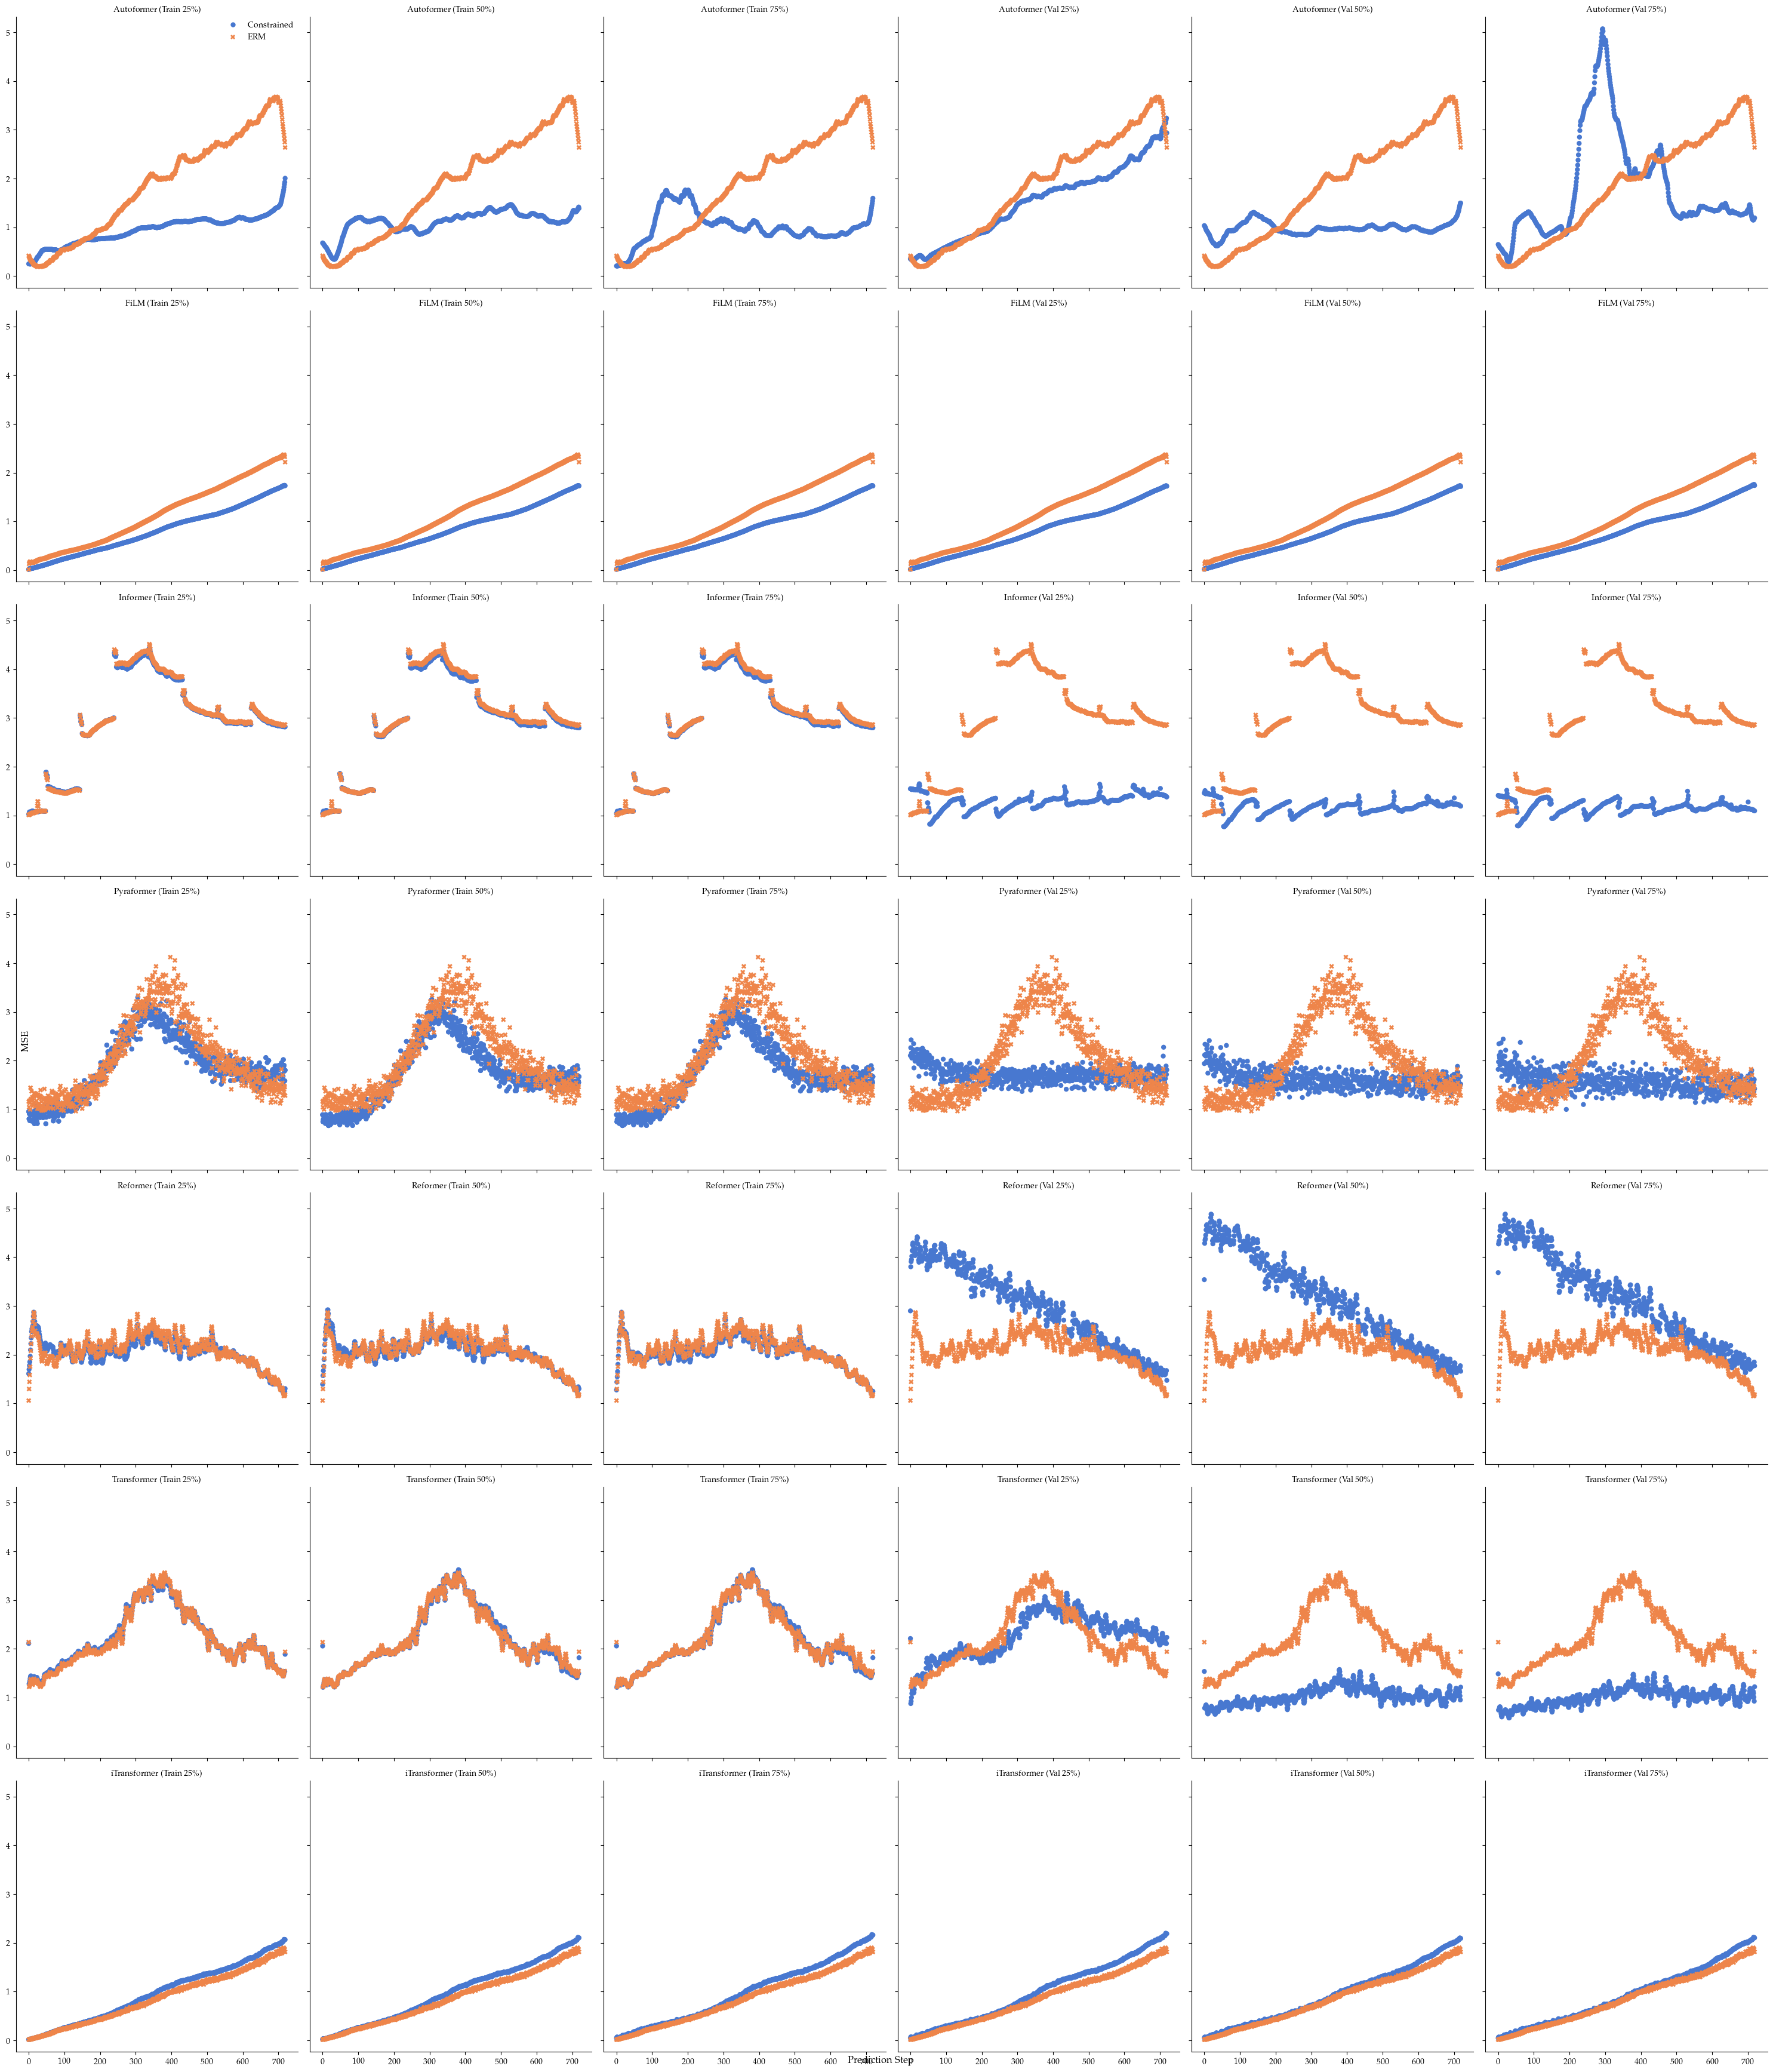

In [331]:
data_path="exchange_rate.csv"
df_this_plot = df_to_plot_nogs.query('pred_len==720 and data_path==@data_path and split=="test" and constraint_idx > 0 and constraint_type!="constant_resilience"').copy()
#df_this_plot = df_this_plot[(df_this_plot.constraint_type.isin(['erm','constant'])) & (df_this_plot.model.isin(["Autoformer","Reformer","Transformer","Informer"]))]
df_this_plot = df_this_plot[(df_this_plot.constraint_type.isin(['erm','constant'])) & (df_this_plot.model.isin(["Autoformer","Reformer","Transformer","Informer","Pyraformer","FiLM","iTransformer"]))]
df_this_plot = df_this_plot.sort_values(['model','data_path','constraint_type','constraint_idx'])
# Replace constraint_idx values 1,2,3,4,5,6 with some strings
df_this_plot['constraint_idx'] = df_this_plot['constraint_idx'].replace({
    1: "Train 25\%", 
    2: "Train 50\%", 
    3: "Train 75\%", 
    4: "Val 25\%", 
    5: "Val 50\%", 
    6: "Val 75\%"  
})

# grid = sns.FacetGrid(df_this_plot,row='model',col='constraint_idx',hue='constraint_type')
# grid.map(sns.scatterplot,'step','mse')
# The above plot but with relplot
g = sns.relplot(
    df_this_plot,
    x='step',y='mse',
    col='constraint_idx',
    row='model',
    hue='type',style="type",
    markers=MARKER_PER_TYPE_BIG,
    palette=constrained_vs_erm_color_palette,
    kind='scatter',
    edgecolors='none',
    facet_kws={
        "legend_out": False,
    }
)
g.set_xlabels("")
g.set_ylabels("")
g.set_titles(template="{row_name} ({col_name})")
g.fig.supxlabel("Prediction Step")
g.fig.supylabel("MSE")
#g.fig.suptitle(f'{pretty_name_dataset(data_path)}')

# Legend (no border color, transparent)
g._legend.set_title("")
#g._legend._set_loc("upper left")
#g._legend.set_bbox_to_anchor([0.5, 0.5])
g._legend.set_frame_on(False)

g.savefig(f"{FIGURES_FOLDER}/epsilon_sensitivity_exchange_rate_720.pdf")

# Pivot with col being constraint_idx and row being data path and model, with values being mse

In [163]:
# todo deleteme
df_to_plot_nogs.query("run_id=='65knv0z5'")

154080    constant_resilience
154800    constant_resilience
155520    constant_resilience
154081    constant_resilience
154801    constant_resilience
                 ...         
155518    constant_resilience
156238    constant_resilience
154799    constant_resilience
155519    constant_resilience
156239    constant_resilience
Name: constraint_type, Length: 2160, dtype: object

### REVIEWER REQUEST: SENSITIVITY TO EPSILON (RESILIENCE)

In [ ]:
#deleteme
#df_to_plot_nogs.query('run_id=="1ye5giqt"').constraint_idx
df_to_plot_nogs.query('data_path=="exchange_rate.csv" and model=="Pyraformer" and pred_len==720 and split=="test" and constraint_type!="erm" '
                      'and constraint_idx==4'
                      
                        ).type.unique()
real_df_all_rebuttal_experiments_raw.query('run_id=="1ye5giqt"')#.query('data_path=="exchange_rate.csv" and model=="Pyraformer" and pred_len==720 and split=="test" and constraint_type!="erm" '
                      #'and constraint_level=='
                     # 
                     # ).type.unique()
df_to_plot_nogs.query('run_id=="1ye5giqt"').constraint_idx
df_to_plot_nogs.query('data_path=="exchange_rate.csv" and model=="Pyraformer" and pred_len==720 and split=="test" and constraint_type=="constant"').constraint_level.unique()
#2.394, 3.794, 4.866

In [ ]:
# sns.relplot(
#     data=df_this_plot.query('data_path=="exchange_rate.csv" and model=="Pyraformer" and pred_len==96 and split=="test" and constraint_type!="erm"'),
#     x='step',y='mse',hue='type',col='constraint_idx',style='type',
# )


ddd=df_this_plot.query('data_path=="exchange_rate.csv" and model=="Pyraformer" and pred_len==720 and split=="test" and constraint_type=="constant"')#[['constraint_level','constraint_idx']]
ddd.constraint_level.unique()

#### Available models

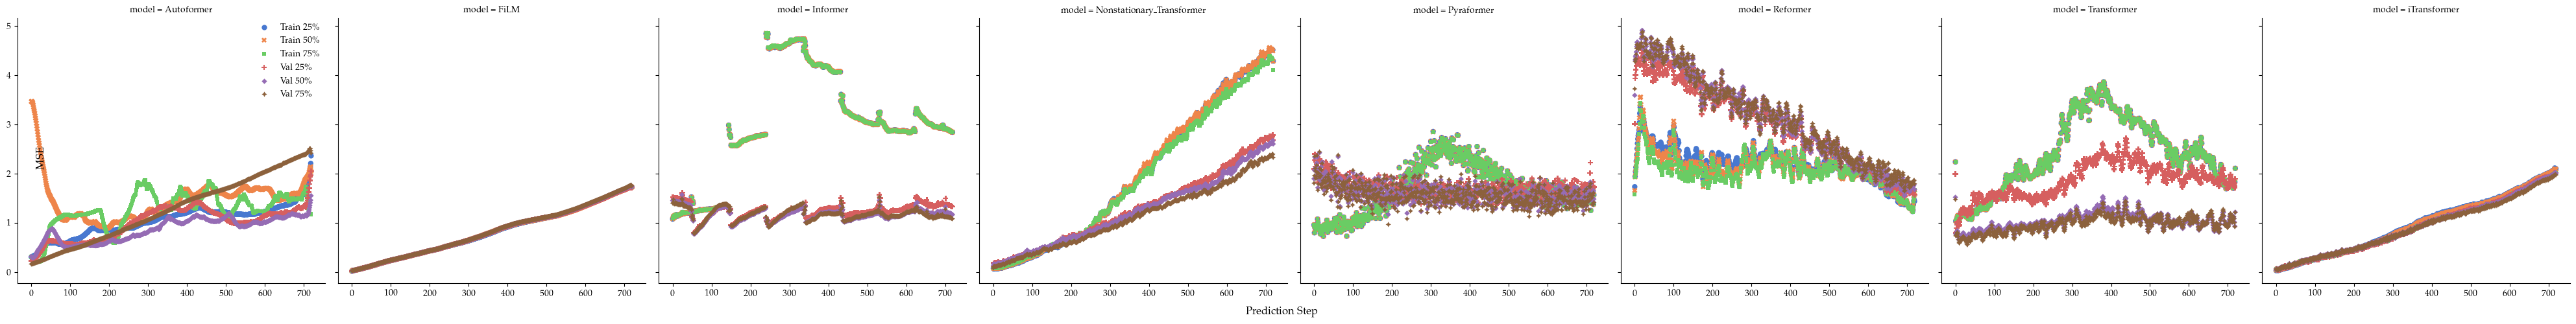

In [355]:
data_path="exchange_rate.csv"
query_string = (
    'pred_len == 720 and data_path == @data_path and split == "test" '
    'and constraint_idx > 0'
    'and constraint_type in ["constant_resilience", "constant"] '
    #'and model in ["Autoformer", "Reformer", "Transformer", "Informer"]'
)
df_this_plot = df_to_plot_nogs.query(query_string).copy()
# df_this_plot = df_to_plot_nogs.query('pred_len==720 and data_path==@data_path and split=="test" and constraint_idx > 0 and constraint_type!="erm"').copy()
# df_this_plot = df_this_plot[(df_this_plot.constraint_type.isin(['constant_resilience','constant'])) & (df_this_plot.model.isin(["Autoformer","Reformer","Transformer","Informer"]))]
# Replace constraint_idx values 1,2,3,4,5,6 with some strings
df_this_plot['constraint_idx'] = df_this_plot['constraint_idx'].replace({
    1: "Train 25\%", 
    2: "Train 50\%", 
    3: "Train 75\%", 
    4: "Val 25\%", 
    5: "Val 50\%", 
    6: "Val 75\%"
})
df_this_plot = df_this_plot.sort_values(['model','data_path','constraint_type','constraint_idx'])


# grid = sns.FacetGrid(df_this_plot,row='model',col='constraint_idx',hue='constraint_type')
# grid.map(sns.scatterplot,'step','mse')
# The above plot but with relplot
g = sns.relplot(
    df_this_plot.query("constraint_type=='constant_resilience'"),
    x='step',y='mse',
    #col='constraint_idx',
    col='model',
    hue='constraint_idx',
    style="constraint_idx",
    
    # col='constraint_idx',
    # row='model',
    # hue='type',
    # style="type",
    #markers=MARKER_PER_TYPE_BIG,
    #palette=constrained_vs_erm_color_palette,
    kind='scatter',
    edgecolors='none',
    facet_kws={
        "legend_out": False,
        "sharey":'row'
    }
)
g.set_xlabels("")
g.set_ylabels("")
#g.set_titles(template="{row_name} ({col_name})")
g.fig.supxlabel("Prediction Step")
g.fig.supylabel("MSE")
#g.fig.suptitle(f'{pretty_name_dataset(data_path)}')

# Legend (no border color, transparent)
g._legend.set_title("")
#g._legend._set_loc("upper left")
#g._legend.set_bbox_to_anchor([0.5, 0.5])
g._legend.set_frame_on(False)

display(Markdown("#### Available models"))
#display(df_this_plot.groupby('model')['type'].apply(set).reset_index())
g.savefig(f"{FIGURES_FOLDER}/epsilon_sensitivity_exchange_rate_720.pdf")
g.savefig(f"{FIGURES_FOLDER}/epsilon_sensitivity_exchange_rate_720.png")

# Pivot with col being constraint_idx and row being data path and model, with values being mse

#### Sensitivity of epsilon one model collapsed

In [160]:
# #TODO if this works, bring up the pct idffs to dataprocessing
# #mse_pct_diff
# pct_diffs_all_ds
# pd.pivot_table(pct_diffs_all_ds.query('data_path=="exchange_rate.csv"'),
#                 index=['model'],
#                 columns=['constraint_idx'],
#                 values=['mse'],
#                 fill_value=0,
#                 aggfunc='mean'
# )


dd_exchange_erm=summary_metrics_nogs.query('data_path=="exchange_rate.csv" and pred_len==720 and constraint_type=="erm"')
dd_exchange_constr=summary_metrics_nogs.query('data_path=="exchange_rate.csv" and pred_len==720 and constraint_type=="constant"')

pivot_erm = pd.pivot_table(
    dd_exchange_erm.query('split=="test"'),
    index=['model'],
    columns=['constraint_idx'],
    values=['rmse'],
    aggfunc='mean'
)

pivot_constrained = pd.pivot_table(
    dd_exchange_constr.query('split=="test"'),
    index=['model'],
    columns=['constraint_idx'],
    values=['rmse'],
    aggfunc='mean'
)
relative_change = (pivot_erm-pivot_constrained)*100/pivot_erm
with pd.option_context('display.float_format', lambda x: f'{x:.3f}'):
    display(Markdown("##### MSE Ablation Relative to ERM"))
    display(Markdown("ERM"))
    display(pivot_erm)
    display(Markdown("Constrained"))
    display(pivot_constrained)
    display(Markdown("Relative % difference"))
    display(relative_change)
    relative_change.columns = ["Train 25%", "Train 50%", "Train 75%", "Val 25%", "Val 50%", "Val 75%"]
    relative_change=relative_change.round(2).applymap(lambda x: f"{x:.2f}").reset_index()
    print(relative_change.to_latex(escape=True,multicolumn_format='c',multicolumn=True).replace("9999.000","N/A"))

##### MSE Ablation Relative to ERM

ERM

rmse                              
constraint_idx            1.000 2.000 3.000 4.000 5.000 6.000
model                                                        
Autoformer                1.360 1.360 1.360 1.360 1.360 1.360
FiLM                      1.074 1.074 1.074 1.074 1.074 1.074
Informer                  1.720 1.720 1.720 1.720 1.720 1.720
Nonstationary_Transformer 1.157 1.157 1.157 1.157 1.157 1.157
Pyraformer                1.431 1.431 1.431 1.431 1.431 1.431
Reformer                  1.447 1.447 1.447 1.447 1.447 1.447
Transformer               1.482 1.482 1.482 1.482 1.482 1.482
iTransformer              0.930 0.930 0.930 0.930 0.930 0.930

Constrained

rmse                              
constraint_idx            1.000 2.000 3.000 4.000 5.000 6.000
model                                                        
Autoformer                0.972 1.055 1.004 1.234 0.990 1.342
FiLM                      0.899 0.900 0.900 0.902 0.903 0.905
Informer                  1.713 1.707 1.707 1.135 1.081 1.081
Nonstationary_Transformer 1.346 1.352 1.367 1.174 1.133 1.058
Pyraformer                1.375 1.323 1.323 1.313 1.271 1.253
Reformer                  1.434 1.436 1.434 1.720 1.764 1.773
Transformer               1.488 1.480 1.481 1.500 1.014 1.001
iTransformer              0.982 0.988 0.991 0.998 0.969 0.969

Relative % difference

rmse                                        
constraint_idx              1.000   2.000   3.000   4.000   5.000   6.000
model                                                                    
Autoformer                 28.525  22.475  26.180   9.292  27.201   1.372
FiLM                       16.300  16.156  16.141  16.034  15.879  15.695
Informer                    0.429   0.775   0.759  34.025  37.143  37.147
Nonstationary_Transformer -16.330 -16.833 -18.173  -1.438   2.122   8.588
Pyraformer                  3.970   7.587   7.590   8.257  11.215  12.451
Reformer                    0.890   0.762   0.865 -18.906 -21.920 -22.530
Transformer                -0.366   0.119   0.101  -1.214  31.574  32.451
iTransformer               -5.655  -6.238  -6.655  -7.398  -4.253  -4.243

\begin{tabular}{llllllll}
\toprule
 & model & Train 25\% & Train 50\% & Train 75\% & Val 25\% & Val 50\% & Val 75\% \\
\midrule
0 & Autoformer & 28.53 & 22.48 & 26.18 & 9.29 & 27.20 & 1.37 \\
1 & FiLM & 16.30 & 16.16 & 16.14 & 16.03 & 15.88 & 15.70 \\
2 & Informer & 0.43 & 0.77 & 0.76 & 34.02 & 37.14 & 37.15 \\
3 & Nonstationary\_Transformer & -16.33 & -16.83 & -18.17 & -1.44 & 2.12 & 8.59 \\
4 & Pyraformer & 3.97 & 7.59 & 7.59 & 8.26 & 11.22 & 12.45 \\
5 & Reformer & 0.89 & 0.76 & 0.87 & -18.91 & -21.92 & -22.53 \\
6 & Transformer & -0.37 & 0.12 & 0.10 & -1.21 & 31.57 & 32.45 \\
7 & iTransformer & -5.66 & -6.24 & -6.65 & -7.40 & -4.25 & -4.24 \\
\bottomrule
\end{tabular}



/var/folders/02/rwff5ttj1r9_5hnh3k8rm7tr0000gq/T/ipykernel_4921/3253644272.py:41: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  relative_change=relative_change.round(2).applymap(lambda x: f"{x:.2f}").reset_index()


ValueError: Length mismatch: Expected axis has 7 elements, new values have 6 elements

In [88]:
dd_exchange_erm.query('split=="test" and model=="Autoformer"')

data_path       model  pred_len type constraint_type split  \
8796  exchange_rate.csv  Autoformer        96  ERM             erm  test   
8797  exchange_rate.csv  Autoformer        96  ERM             erm  test   
8798  exchange_rate.csv  Autoformer        96  ERM             erm  test   
8799  exchange_rate.csv  Autoformer        96  ERM             erm  test   
8800  exchange_rate.csv  Autoformer        96  ERM             erm  test   
8801  exchange_rate.csv  Autoformer        96  ERM             erm  test   
8802  exchange_rate.csv  Autoformer        96  ERM             erm  test   
8853  exchange_rate.csv  Autoformer       192  ERM             erm  test   
8854  exchange_rate.csv  Autoformer       192  ERM             erm  test   
8855  exchange_rate.csv  Autoformer       192  ERM             erm  test   
8856  exchange_rate.csv  Autoformer       192  ERM             erm  test   
8857  exchange_rate.csv  Autoformer       192  ERM             erm  test   
8858  exchange_rate.csv  Autoformer       192  ERM             erm  test   
8859  exchange_rate.csv  Autoformer       192  ERM             erm  test   
8910  exchange_rate.csv  Autoformer       336  ERM             erm  test   
8911  exchange_rate.csv  Autoformer       336  ERM             erm  test   
8912  exchange_rate.csv  Autoformer       336  ERM             erm  test   
8913  exchange_rate.csv  Autoformer       336  ERM             erm  test   
8914  exchange_rate.csv  Autoformer       336  ERM             erm  test   
8915  exchange_rate.csv  Autoformer       336  ERM             erm  test   
8916  exchange_rate.csv  Autoformer       336  ERM             erm  test   
8967  exchange_rate.csv  Autoformer       720  ERM             erm  test   
8968  exchange_rate.csv  Autoformer       720  ERM             erm  test   
8969  exchange_rate.csv  Autoformer       720  ERM             erm  test   
8970  exchange_rate.csv  Autoformer       720  ERM             erm  test   
8971  exchange_rate.csv  Autoformer       720  ERM             erm  test   
8972  exchange_rate.csv  Autoformer       720  ERM             erm  test   
8973  exchange_rate.csv  Autoformer       720  ERM             erm  test   

                                   Algorithm  constraint_idx  \
8796  AllModels_exchange_rate.csv Autoformer             0.0   
8797  AllModels_exchange_rate.csv Autoformer             1.0   
8798  AllModels_exchange_rate.csv Autoformer             2.0   
8799  AllModels_exchange_rate.csv Autoformer             3.0   
8800  AllModels_exchange_rate.csv Autoformer             4.0   
8801  AllModels_exchange_rate.csv Autoformer             5.0   
8802  AllModels_exchange_rate.csv Autoformer             6.0   
8853  AllModels_exchange_rate.csv Autoformer             0.0   
8854  AllModels_exchange_rate.csv Autoformer             1.0   
8855  AllModels_exchange_rate.csv Autoformer             2.0   
8856  AllModels_exchange_rate.csv Autoformer             3.0   
8857  AllModels_exchange_rate.csv Autoformer             4.0   
8858  AllModels_exchange_rate.csv Autoformer             5.0   
8859  AllModels_exchange_rate.csv Autoformer             6.0   
8910  AllModels_exchange_rate.csv Autoformer             0.0   
8911  AllModels_exchange_rate.csv Autoformer             1.0   
8912  AllModels_exchange_rate.csv Autoformer             2.0   
8913  AllModels_exchange_rate.csv Autoformer             3.0   
8914  AllModels_exchange_rate.csv Autoformer             4.0   
8915  AllModels_exchange_rate.csv Autoformer             5.0   
8916  AllModels_exchange_rate.csv Autoformer             6.0   
8967  AllModels_exchange_rate.csv Autoformer             0.0   
8968  AllModels_exchange_rate.csv Autoformer             1.0   
8969  AllModels_exchange_rate.csv Autoformer             2.0   
8970  AllModels_exchange_rate.csv Autoformer             3.0   
8971  AllModels_exchange_rate.csv Autoformer             4.0   
8972  AllModels_exchange_rate.csv Autoformer             5.0   
8973  AllModels_e

In [354]:
pivot_table=pd.pivot_table(df_this_plot.query('data_path=="exchange_rate.csv" and split=="test"'),
                index=['model'],
                columns=['constraint_idx'],
                values=['mse'],
                fill_value=0,
                aggfunc='mean'
               )
with pd.option_context('display.float_format', lambda x: f'{x:.4g}'):
    display(pivot_table)
    

mse                                          \
constraint_idx            Train 25\% Train 50\% Train 75\% Val 25\% Val 50\%   
model                                                                          
Autoformer                    0.9936       1.29       1.14     1.26   0.9249   
FiLM                          0.8093     0.8122     0.8125   0.8145   0.8179   
Informer                       2.969      2.959      2.959    1.267    1.168   
Nonstationary_Transformer      1.895      1.911      1.898    1.335    1.261   
Pyraformer                     1.824      1.731       1.73    1.705    1.606   
Reformer                       2.115      2.088      2.058    2.984    3.118   
Transformer                    2.309      2.298      2.299    2.051    1.022   
iTransformer                  0.9674     0.9668     0.9529   0.9595   0.9288   

                                    
constraint_idx            Val 75\%  
model                               
Autoformer                   1.537  
FiLM                        0.8213  
Informer                      1.17  
Nonstationary_Transformer    1.121  
Pyraformer                   1.567  
Reformer                     3.147  
Transformer                 0.9877  
iTransformer                0.9232

### PAPER: Singular ERM vs Constrained 
Of ERM vs constrained

In [ ]:
# #Option 1
# model="Autoformer"
# data_path="exchange_rate.csv"
# pred_len=336
# split='test'

# # Option 2
# model="Transformer"
# data_path="exchange_rate.csv"
# pred_len=720
# split='test'

# # Option 3
model="Informer"
data_path="exchange_rate.csv"
pred_len=720
split='test'

# # Option 4
# model="Autoformer"
# data_path="weather.csv"
# pred_len=96
# split='test'

#seaborn params
set_plot_config_paper()

# Filter data
to_plot = df_to_plot.query('model==@model & data_path==@data_path & pred_len==@pred_len & split==@split & constraint_type!="constant_resilience"').copy()
to_plot.loc[to_plot.constraint_level==-1.0,'constraint_level'] = to_plot.constraint_level.max()

#Sample every other datapoint
to_plot = to_plot[to_plot.step%8==0]

to_plot.rename(columns={'mse':'MSE','step': "Prediction Step"},inplace=True)
#display(to_plot.constraint_level)
g = sns.scatterplot(data=to_plot,
                    x="Prediction Step",
                    y= "MSE", 
                    hue='type',
                    style='type',
                    markers=MARKER_PER_TYPE_BIG,
                    palette=constrained_vs_erm_color_palette,
                    #marker='+',
                    #palette={'ERM':'blue','Constrained':'red'},
                    legend='full'
                    )
#g.set_title(f"{model} on {data_path} (pred_len={pred_len}, split={split})")
#plt.figure(figsize=(3.5, 2.6))  # Width, height in inches (standard on papers according to chatGPT)

# remove borders from legend
g.get_legend().get_frame().set_linewidth(0.0)
g.get_legend().set_title("")

# Set the size of the markers
g.legend_.legendHandles[0]._sizes = [40]

plt.savefig(f'../figures/icml_post_rebuttal/erm_vs_constrained_fp_{model}_{data_path[:4]}_{pred_len}.pdf', bbox_inches='tight')  # For a PGF file
#g2 = sns.lineplot(data=to_plot.query("constraint_type=='constant'"),x="Prediction Step",y= "constraint_level", alpha=.7,color='green',label='Constraint Level')

### PAPER: `fig:constr_vs_erm` ERM vs Constrained across models on two datasets

Saved to ../figures/icml_post_rebuttal/constrained_vs_erm_allmodels_weather_96_exchange_720.pdf


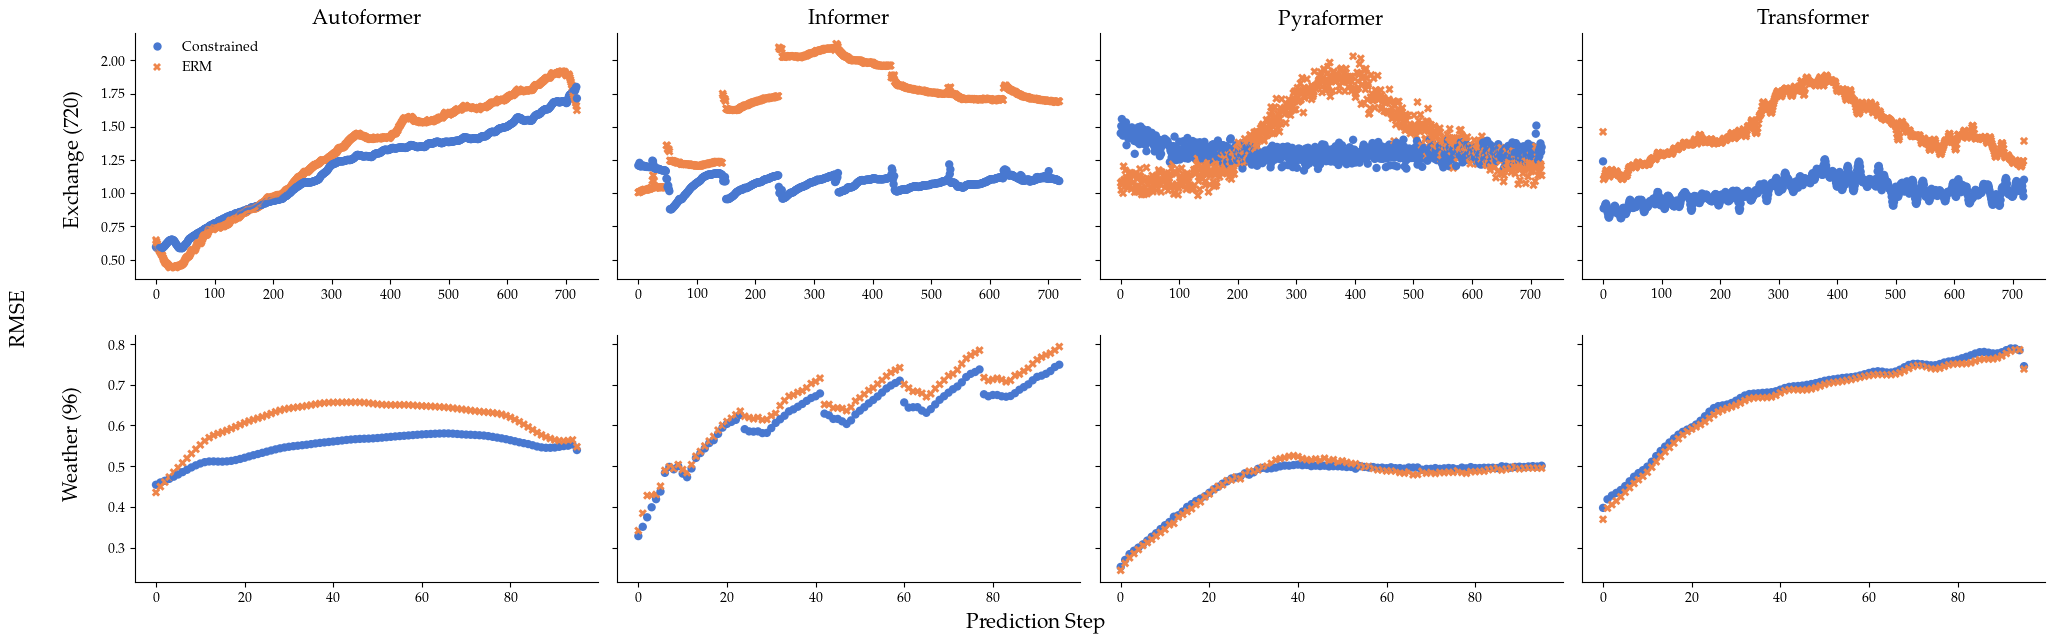

In [287]:
df_set1 = df_to_plot.query('data_path=="exchange_rate.csv" and pred_len==720 and split=="test"').copy()
df_set2 = df_to_plot.query('data_path=="weather.csv" and pred_len==96 and split=="test"').copy()

CHOSEN_MODELS=['Autoformer','Informer','Pyraformer','Transformer']
CONSTRAINTS_TO_PLOT=['constant','erm']

# filter to og
#df_set1 = df_set1.query("model in @og_models")

df_set1 = df_set1.query("model in @CHOSEN_MODELS and constraint_type in @CONSTRAINTS_TO_PLOT").sort_values(['model','step'])
df_set2 = df_set2.query("model in @CHOSEN_MODELS and constraint_type in @CONSTRAINTS_TO_PLOT").sort_values(['model','step'])

df_constr_vs_erm=pd.concat([df_set1,df_set2])
df_constr_vs_erm['pretty_data_path'] = df_constr_vs_erm['data_path'].apply(pretty_name_dataset)

g = sns.relplot(
    df_constr_vs_erm,
    x='step',y='rmse',
    col='model',
    row='pretty_data_path',
    hue='type',
    style="type",
    markers=MARKER_PER_TYPE_BIG,
    palette=constrained_vs_erm_color_palette,
    height=3.2, aspect=1.6,
    kind='scatter',
    edgecolors='none',
    facet_kws={
        "legend_out": False,
        "sharey": 'row',
        "sharex": False,
    }
)
g.set_xlabels("")
g.set_ylabels("")
g.set_titles(template="{col_name}",row_template="{col_name}",col_template='')

g.figure.supxlabel("Prediction Step",fontsize=15)
#g.figure.supylabel("RMSE")
sup_ylabel=g.figure.supylabel("RMSE",fontsize=15)
sup_ylabel.set_position((-0.001, 0.5))  # Adjust the x position as needed
# Set supylabel fontsize
g.fig.subplots_adjust(left=0.06)
#g.fig.suptitle(f'{pretty_name_dataset(data_path)}')

# Legend (no border color, transparent)
g._legend.set_title("")
#g._legend._set_loc("upper left")
#g._legend.set_bbox_to_anchor([0.5, 0.5])
g._legend.set_frame_on(False)


titles = [a.title._text for a in g.axes[1,:]]
for i,ax in enumerate(g.axes[0,:]):
    #set fontsize
    ax.title.set_fontsize(15)
for i,ax in enumerate(g.axes[1,:]):
    ax.title.set_text("")
    
# Add supylabel for each row
num_rows = g.axes.shape[0]
for i,row_title,y_offset in zip(range(num_rows),["Weather (96)","Exchange (720)"],[0.612,0.5]):
    y_pos = (y_offset + i) / num_rows  # Position for each row
    g.figure.text(0.03, y_pos, row_title, va='center', ha='center', fontsize=15, rotation='vertical')

    
figure1_dir = f"{FIGURES_FOLDER}/constrained_vs_erm_allmodels_weather_96_exchange_720.pdf"
print(f"Saved to {figure1_dir}")
g.savefig(figure1_dir)

### PAPER: ERM vs. Constrained on 50th percentile on all datasets (one seed, gridesarched)
nonresilience

In [ ]:
# Version 2
# PARAMS
split="test"
#constraint_idx = 1 # use the 50 percentile constraint to plot 1=25,2=50,3=75
seed=2021

# Filter
# Choose this one for erm vs constant
df_pct50_and_erm = df_to_plot[(df_to_plot.split==split) & (df_to_plot.constraint_type!='constant_resilience')].copy()
df_pct50_and_erm= df_to_plot.query('split==@split and constraint_type in ["erm","constant"]')

PRED_LENS=sorted(df_to_plot.pred_len.unique().tolist())

def sample_every_n(df,groupcols=['data_path','model','pred_len','split'],n=2):
    """
    Returns DF but only every nth row with respect to step within each group.
    """
    df_sampled = df.groupby(groupcols).apply(lambda x: x[(x.step//48)%n==0]).reset_index(drop=True)
    return df_sampled
    
def x_vs_y_mse_plot(_df,prefix='constrained_vs_erm'):
    """Originally ERM Vs Constrained, now also works for Constrained Vs Resilience"""
    for data_path in _df.data_path.unique():
        # Add data for constant line
        df_current_plot = _df.query('data_path==@data_path').copy()
        print("Unique constraint types found")
        print(df_current_plot.constraint_type.unique())
        
        g = sns.relplot(
            x='step',
            #y='mse',
            y='rmse',
            data=df_current_plot,
            row='model', 
            col='pred_len',
            hue='type',
            style='type',
            markers=MARKER_PER_TYPE_BIG,
            palette=constrained_vs_erm_color_palette,
            #markers={'ERM':'X','Constrained':'.'},
            #marker='+',
            #marker='line',
            #kind='line',
            #edgecolor=None,
            height=3, 
            aspect=1.0,
            alpha=0.7,
            legend='full',
            # Facet level arguments
            facet_kws={
                #'sharex': 'col', #makes sense, but it's easier to read if they're not shared
                'sharex': False,
                'sharey': 'row', 
                'legend_out': False,
            }
        )
        #g.add_legend()
        
        g.set_xlabels("")
        g.set_ylabels("")
        g.set_titles(template="{row_name} ({col_name})")
        g.fig.supxlabel("Prediction Step")
        g.fig.supylabel("RMSE")
        g.fig.suptitle(f'{pretty_name_dataset(data_path)}')
        for ax in g.axes.flat:
            ax.set_title(ax.get_title(), fontsize='small')
            ax.set_xlabel(ax.get_xlabel(), fontsize='large')
            ax.set_ylabel(ax.get_ylabel(), fontsize='large')

        # make markers bigger
        for ax in g.axes.flat:
            for p in ax.patches:
                p.set(markersize=20)
        # disable legend
        #g._legend.remove()
        g._legend.set_title("")
        # legend fontsizesmall
        #g._legend.texts
        #g._legend.set_frame_on(False)
        # tight layout
        g.fig.tight_layout()
        
        name_without_extension = data_path.split(".")[0]
        g.savefig(f"{FIGURES_FOLDER}/{prefix}_all_{name_without_extension}.pdf")
        g.savefig(f"{FIGURES_FOLDER}/{prefix}_all_{name_without_extension}.png")
        plt.show()
        
x_vs_y_mse_plot(df_pct50_and_erm,prefix='constrained_vs_erm')

#### DEV(paper?): Constrained vs Resilience

In [288]:
# PARAMS
split="test"
#constraint_idx = 1 # use the 50 percentile constraint to plot 1=25,2=50,3=75
seed=2021

# Filter
df_constrained_vs_resilience = df_to_plot.query('split==@split and constraint_type in ["constant","constant_resilience"]')
df_constrained_vs_resilience.constraint_type.unique()

df_constrained_vs_resilience.query('data_path=="traffic.csv"').constraint_type.unique()
x_vs_y_mse_plot(df_constrained_vs_resilience,prefix='constrained_vs_resilience')

NameError: name 'x_vs_y_mse_plot' is not defined

### PAPER: ERM Vs Constrained parameterized on split (NO GS)
Using non gridsearch data to explore the results

In [ ]:
# PARAMS
split="test"
constraint_idx = 1 # use 25% to see the highest multipliers to plot 1=25,2=50,3=75
seed=2021

# sns.set_palette("muted")
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "serif",
#     "font.serif": ["Palatino"],
# })
# mpl.rcParams['lines.linewidth'] = 1.8

# Filter
df_pct50_and_erm = df_to_plot_nogs[(df_to_plot_nogs.seed==seed) & 
                                   (df_to_plot_nogs.split==split) & 
                                   (df_to_plot_nogs.constraint_type!='constant_resilience') & 
                                   (df_to_plot_nogs.constraint_idx==constraint_idx)].copy()

PRED_LENS=sorted(df_to_plot_nogs.pred_len.unique().tolist())
#PRED_LENS=[720]
#PRED_LENS=[96]

def pretty_name_dataset(data_path):
    if data_path=="electricity.csv": 
        return "Electricity"
    if data_path=="weather.csv":
        return "Weather"
    if data_path=="exchange_rate.csv":
        return "Exchange Rate"
    if data_path=="traffic.csv":
        return "Traffic"
    if data_path=="national_illness.csv":
        return "Illness"
    else: 
        print(f"Warning didnt find dataset {data_path}")
        return data_path

def sample_every_n(df,groupcols=['data_path','model','pred_len','split'],n=2):
    """
    Returns DF but only every nth row with respect to step within each group.
    """
    df_sampled = df.groupby(groupcols).apply(lambda x: x[(x.step//48)%n==0]).reset_index(drop=True)
    return df_sampled
    

#for pred_len in PRED_LENS:
for data_path in df_pct50_and_erm.data_path.unique():
    # Add data for constant line
    #df_current_plot = df_pct50_and_erm.query('pred_len==@pred_len').copy()
    df_current_plot = df_pct50_and_erm.query('data_path==@data_path').copy()
    df_current_plot['constraint_type'].replace({'erm':'ERM','constant':'Constrained'},inplace=True)
    #constraint_level = df_current_plot.constraint_level.unique()[0]
    #df_current_plot['constraint_level'] = constraint_level
    #display(Markdown(f"#### **ERM Vs Constrained {pred_len} (split={split})**"))

    g = sns.FacetGrid(
                    #sample_every_n(df_current_plot),
                    df_current_plot,
                    #df_current_plot,
                    row='model', 
                    col='pred_len', 
                    hue='constraint_type', 
                    height=3, 
                    aspect=1.0, 
                    legend_out=False,
                    #legend='full',
                    sharex=False,
                    sharey=False,
                    )
    #g.set_titles(row_template="", col_template="")
    
    #g.map(sns.lineplot, "step", "constraint_level", alpha=.7)
    g.map(sns.scatterplot, "step", "mse",marker='+',alpha=0.7,legend='full',edgecolor=None)
    g.add_legend()
    
    g.set_xlabels("")
    g.set_ylabels("")
    g.set_titles(template="{row_name} ({col_name})")
    g.fig.supxlabel("Prediction Step")
    g.fig.supylabel("MSE")
    g.fig.suptitle(f'{pretty_name_dataset(data_path)}')
    for ax in g.axes.flat:
        ax.set_title(ax.get_title(), fontsize='small')
        ax.set_xlabel(ax.get_xlabel(), fontsize='large')
        ax.set_ylabel(ax.get_ylabel(), fontsize='large')

    # make markers bigger
    for ax in g.axes.flat:
        for p in ax.patches:
            p.set(markersize=20)
    # disable legend
    #g._legend.remove()
    g._legend.set_title("")
    # legend fontsizesmall
    #g._legend.texts
    #g._legend.set_frame_on(False)
    # tight layout
    g.fig.tight_layout()
    
    #TODO fix and uncomment
    name_without_extension = data_path.split(".")[0]
    g.savefig(f"{FIGURES_FOLDER}/constrained_vs_erm_all_nogs_{name_without_extension}.pdf")
    #plt.show()

In [ ]:
# PARAMS
#split="test"
#constraint_idx = 1 # use the 50 percentile constraint to plot 1=25,2=50,3=75
seed=2021

# Filter
df_pct50_and_erm = df_to_plot[(df_to_plot.seed==seed) & (df_to_plot.split.isin(['train','test'])) & (df_to_plot.constraint_type.isin(['erm',CONSTRAINT_TYPE]))].copy()

PRED_LENS=sorted(df_to_plot.pred_len.unique().tolist())
#PRED_LENS=[720]
#PRED_LENS=[96]
#for model in df_to_plot.model.unique():
for data_path in df_to_plot.data_path.unique():
    for pred_len in PRED_LENS:
        # Add data for constant line
        df_current_plot = df_pct50_and_erm.query('pred_len==@pred_len and data_path==@data_path').copy()
        mses=df_current_plot.groupby(['model','split','constraint_type'])['mse'].mean().reset_index()
        # plot only if train constant is lower than train erm and test constant is higher than test erm
        # if mses.query('split=="train"').query('constraint_type=="constant"').mse.values[0] < mses.query('split=="train"').query('constraint_type=="erm"').mse.values[0] and \
        #     mses.query('split=="test"').query('constraint_type=="constant"').mse.values[0] > mses.query('split=="test"').query('constraint_type=="erm"').mse.values[0]:
        display(Markdown(f"#### **ERM Vs Constrained {data_path}--{pred_len}**"))
    
        #constraint_level = df_current_plot.constraint_level.unique()[0]
        #df_current_plot['constraint_level'] = constraint_level
        display(Markdown(f"#### **ERM Vs Constrained {data_path}--{pred_len}**"))

        g = sns.FacetGrid(df_current_plot, col='model', row='split', hue='constraint_type', height=3, aspect=1.5, legend_out=True,sharex=False,sharey=False)
        #g.map(sns.lineplot, "step", "constraint_level", alpha=.7)
        g.map(sns.scatterplot, "step", "mse", alpha=.7)
        g.map(sns.lineplot, "step", "constraint_level", alpha=.7)
        g.add_legend()
        #TODO fix and uncomment
        #g.savefig(f"{FIGURES_FOLDER}/constrained_vs_erm_{pred_len}_{str(constraint_level).replace('.','')}.png")
        plt.show()

### PAPER: `fig:constrained_train` Training ERM vs Resilience

In [282]:
df_to_plot_nogs \
    .query('data_path=="exchange_rate.csv" and pred_len==720 and split!="val" and model=="Autoformer" and constraint_type=="constant_resilience"') \
    .run_id.unique()

array(['4sp1p4t3', '4yk46q3f', 'b7p62lmg', 'jzkfeuqt', 'l0pa45n7',
       'tzbkv15w'], dtype=object)

In [280]:
df_to_plot_nogs \
    .query('data_path=="exchange_rate.csv" and pred_len==720 and split!="val" and model=="Autoformer" and constraint_type=="constant_resilience" and constraint_level==0.85') \
    .constraint_level.unique()

array([], dtype=float64)

In [279]:
df_to_plot_nogs \
    .query('data_path=="exchange_rate.csv" and pred_len==720 and split!="val" and model=="Autoformer" and constraint_type=="constant"') \
    .constraint_level.unique()

array([1.047, 1.4  , 0.765, 1.024, 0.383, 0.582])

(1440, 130)
exchange_720_autoformer
Constraint 0.765


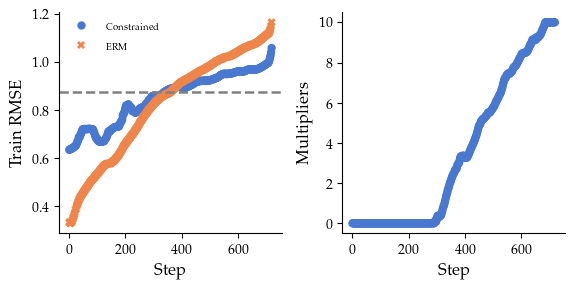

In [164]:
import matplotlib as mpl

# case1 = df_to_plot.query(
#     'data_path=="exchange_rate.csv" and pred_len==720 and split!="val" and model=="Autoformer" ').copy()

# new case 1
case1 = df_to_plot_nogs.query('run_id=="m6ml2r6i" and split!="val"').copy()
case1['rmse'] = np.sqrt(case1['mse'])
case1_erm=df_to_plot.query('data_path=="exchange_rate.csv" and pred_len==720 and split!="val" and model=="Autoformer" and constraint_type=="erm"').copy()
case1_resilience = df_to_plot_nogs.query('data_path=="exchange_rate.csv" and pred_len==720 and split!="val" and model=="Autoformer" and constraint_type=="constant_resilience" and constraint_level==0.765').copy()
case1 = pd.concat([case1,case1_erm,case1_resilience],ignore_index=True,axis=0)

case2 = df_to_plot.query(
    'data_path=="electricity.csv" and pred_len==336 and split!="val" and model=="Autoformer" ').copy()

case3 = df_to_plot.query(
    'data_path=="electricity.csv" and pred_len==336 and split!="val" and model=="Reformer" ').copy()

# AF exchange 720 val 75% as resilience example?
# case3 = df_to_plot_nogs.query('data_path=="exchange_rate.csv" and model=="Autoformer" and pred_len==720 and split!="val" and constraint_idx==6 and constraint_type=="constant"').sort_values('step')
# case3['rmse'] = np.sqrt(case3['mse'])


for plot_data,figname in [
    (case1,"exchange_720_autoformer"),
    # (case2,"electricity_336_autoformer"),
    # (case3,"electricity_336_reformer"),
    ]:
    plot_data = plot_data.copy()
    plot_data = plot_data.query('constraint_type=="erm" or constraint_type=="constant"')
    
    if plot_data.pred_len.iloc[0]>500:
        evens = plot_data["step"]%2
        plot_data = plot_data[evens!=0]
    # elif plot_data.pred_len.iloc[0]==336:
    #     evens = plot_data["step"]%4
    #     plot_data = plot_data[evens==0]
    else: 
        evens = plot_data["step"]%3
        plot_data = plot_data[evens!=0]
    print(plot_data.shape)
    print(figname)
    
    # Goal: Get a subplot with train mse, test mse, and train multipliers for Constrained vs Constrained resilience.
    melted_data = plot_data.melt(
        id_vars=['model','data_path','pred_len','split','step','type'],
        value_vars=['rmse','multiplier'],
        var_name='metric',
        value_name='value'
    )
    melted_data['row_val'] = melted_data['data_path'] + '_' + melted_data['pred_len'].astype(str)
    melted_data.loc[(melted_data.split=='train') & (melted_data.metric=='multiplier'), 'split'] = 'dual_variables'
    melted_data.loc[(melted_data.metric=='multiplier') & (melted_data.type=="ERM"), 'value'] = np.nan
    
    # For this example, I only want train and multipliers
    melted_data = melted_data.query('split in ["train","dual_variables"]')

    plot = sns.relplot(
        data=melted_data,
        x='step',
        y='value',
        hue='type',
        style='type',
        col='split',
        row='row_val',
        palette=constrained_vs_erm_color_palette,
        height=3, 
        aspect=1.0,
        edgecolors='none',
        facet_kws={
            'sharey': False,
            'sharex': False,
            'legend_out': False,
        },
        
        #plot_kws=dict(edgecolor="none")
    )
    
    # Getting the constraint line. Indexing first because there's one for constant and one for resilience.
    plot_constraint_val=plot_data[['model','constraint_level']].drop_duplicates().constraint_level.tolist()[0]
    print(f"Constraint {plot_constraint_val}")
    
    for y_axis_meaning,ax in zip(['Train RMSE','Multipliers']*2,plot.axes.flat):
        ax.set_title("", fontsize='large')
        if y_axis_meaning == 'Train RMSE':
            # Add constraint line only for train mse
            ax.axhline(y=np.sqrt(plot_constraint_val),color='gray',linestyle='--')
        
        ax.set_xlabel("Step", fontsize='large')
        ax.set_ylabel(ax.get_ylabel(), fontsize='large')
        ax.set_ylabel(y_axis_meaning, fontsize='large')
        legend = ax.get_legend()
        if legend:
            legend.set_frame_on(True)
            legend.set_title("")
            legend.get_frame().set_facecolor('white')
            legend.get_frame().set_alpha(0)
            legend.set_loc("upper left")
            #legend.set_borderpad(0.1)
            for text in legend.get_texts():
                text.set_fontsize('x-small')
        #ax.get_legend().get_frame().set_linewidth(0.0)
    # remove supylabel
    plot.fig.supylabel("")
    
    
    plot.fig.tight_layout()
    #plot._legend.remove()
    plot.fig.supylabel("")
    # save
    plot.savefig(f"../figures/icml_post_rebuttal/train_multipliers_erm_v_constant__{figname}.pdf")
    plt.show()
    
    

#### Where does it start being infeasible

In [208]:
# Find the first step in case 1 where mse is > 0.765.
case1.query('constraint_type=="constant" and split=="train" and mse>0.765').step.min()

340

#### Where does it start being nonzero multipliers

In [213]:
#case1.query('constraint_type=="constant" and split=="train"')[['step','multiplier']].head(245)
case1.query('constraint_type=="constant" and split=="train" and multiplier>0').step.min()

233

### PAPER: `fig:resilience_train` Training Constant vs Resilience
Purpose: Show that resilience fixes the infeasible training issue.

Observation: some resilience multipliers are not exactly zero although the plot scale implies it (some are aroud ~0.3 for example)

(288, 130)
exchange_720_autoformer
Constraint 0.765


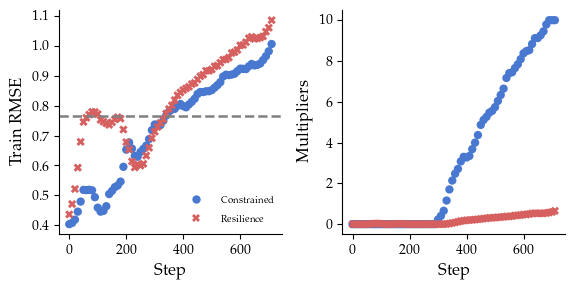

(896, 130)
electricity_336_autoformer
Constraint 0.207


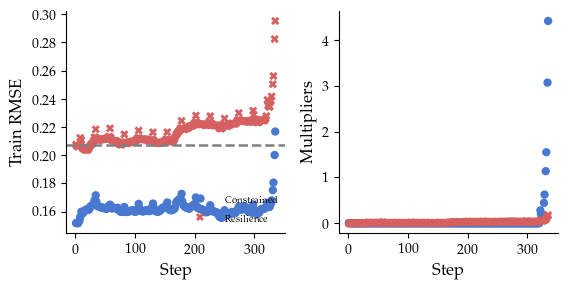

(896, 130)
electricity_336_reformer
Constraint 0.167


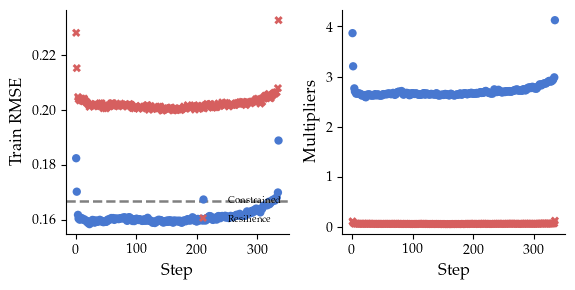

In [170]:
import matplotlib as mpl

for plot_data,figname in [
    (case1,"exchange_720_autoformer"),
    (case2,"electricity_336_autoformer"),
    (case3,"electricity_336_reformer"),
    ]:
    plot_data = plot_data.copy()
    plot_data = plot_data.query('constraint_type=="constant" or constraint_type=="constant_resilience"')
    
    if plot_data.pred_len.iloc[0]>500:
        evens = plot_data["step"]%10
        plot_data = plot_data[evens==0]
    # elif plot_data.pred_len.iloc[0]==336:
    #     evens = plot_data["step"]%4
    #     plot_data = plot_data[evens==0]
    else: 
        evens = plot_data["step"]%3
        plot_data = plot_data[evens!=0]
    print(plot_data.shape)
    print(figname)
    
    # Goal: Get a subplot with train mse, test mse, and train multipliers for Constrained vs Constrained resilience.
    melted_data = plot_data.melt(
        id_vars=['model','data_path','pred_len','split','step','type'],
        #value_vars=['rmse','multiplier'],
        value_vars=['mse','multiplier'],
        var_name='metric',
        value_name='value'
    )
    melted_data['row_val'] = melted_data['data_path'] + '_' + melted_data['pred_len'].astype(str)
    melted_data.loc[(melted_data.split=='train') & (melted_data.metric=='multiplier'), 'split'] = 'dual_variables'
    
    # For this example, I only want train and multipliers
    melted_data = melted_data.query('split in ["train","dual_variables"]')

    plot = sns.relplot(
        data=melted_data,
        x='step',
        y='value',
        hue='type',
        style='type',
        col='split',
        row='row_val',
        palette=constrained_vs_erm_color_palette,
        height=3, 
        aspect=1.0,
        edgecolors='none',
        facet_kws={
            'sharey': False,
            'sharex': False,
            'legend_out': False,
        },
        
        #plot_kws=dict(edgecolor="none")
    )
    
    # Getting the constraint line. Indexing first because there's one for constant and one for resilience.
    plot_constraint_val=plot_data[['model','constraint_level']].drop_duplicates().constraint_level.tolist()[0]
    print(f"Constraint {plot_constraint_val}")
    
    for y_axis_meaning,ax in zip(['Train RMSE','Multipliers']*2,plot.axes.flat):
        ax.set_title("", fontsize='large')
        if y_axis_meaning == 'Train RMSE':
            # Add constraint line only for train mse
            #ax.axhline(y=np.sqrt(plot_constraint_val),color='gray',linestyle='--')
            ax.axhline(y=plot_constraint_val,color='gray',linestyle='--')
        
        ax.set_xlabel("Step", fontsize='large')
        ax.set_ylabel(ax.get_ylabel(), fontsize='large')
        ax.set_ylabel(y_axis_meaning, fontsize='large')
        legend = ax.get_legend()
        if legend:
            legend.set_frame_on(True)
            legend.set_title("")
            legend.get_frame().set_facecolor('white')
            legend.get_frame().set_alpha(0)
            legend.set_loc("lower right")
            #legend.set_borderpad(0.1)
            for text in legend.get_texts():
                text.set_fontsize('x-small')
        #ax.get_legend().get_frame().set_linewidth(0.0)
    # remove supylabel
    plot.fig.supylabel("")
    
    
    plot.fig.tight_layout()
    #plot._legend.remove()
    plot.fig.supylabel("")
    # save
    plot.savefig(f"../figures/icml_post_rebuttal/train_multipliers_resilience_v_constant__{figname}.pdf")
    plt.show()
    
    

In [ ]:
# Showing some multipliers are nonzero
sns.relplot(data=df_to_plot.query(
    'data_path=="exchange_rate.csv" and pred_len==720 and split=="train" and model=="Autoformer" ' 
    'and (constraint_type=="constant_resilience")',).copy()[['step','multiplier']],x='step',y='multiplier')

### PAPER: `fig:resilience_generalization`

(288, 130)
exchange_720_autoformer
Constraint 0.765
Constraint sqrt 0.8746427842267951


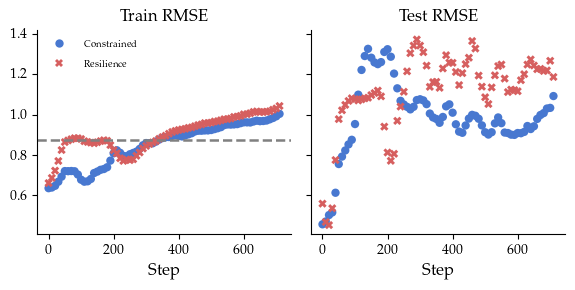

(896, 130)
electricity_336_autoformer
Constraint 0.207
Constraint sqrt 0.454972526643093


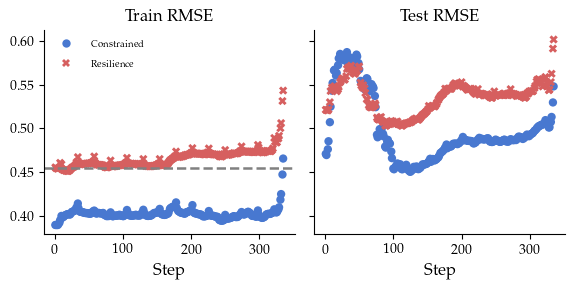

(896, 130)
electricity_336_reformer
Constraint 0.167
Constraint sqrt 0.408656334834051


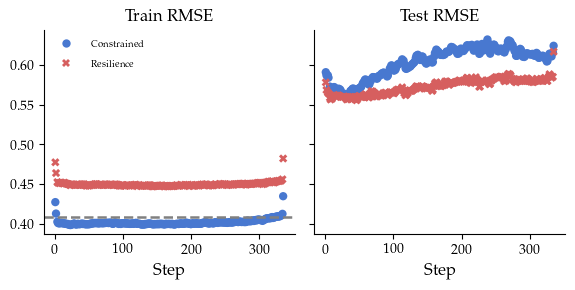

In [171]:
#Very similar to he above but tweaks title differently and share axes

for plot_data,figname in [
    (case1,"exchange_720_autoformer"),
    (case2,"electricity_336_autoformer"),
    (case3,"electricity_336_reformer"),
    ]:
    plot_data = plot_data.copy()
    plot_data = plot_data.query('constraint_type=="constant" or constraint_type=="constant_resilience"')
    
    if plot_data.pred_len.iloc[0]>500:
        evens = plot_data["step"]%10
        plot_data = plot_data[evens==0]
    # elif plot_data.pred_len.iloc[0]==336:
    #     evens = plot_data["step"]%4
    #     plot_data = plot_data[evens==0]
    else: 
        evens = plot_data["step"]%3
        plot_data = plot_data[evens!=0]
    print(plot_data.shape)
    print(figname)
    
    # Goal: Get a subplot with train mse, test mse, and train multipliers for Constrained vs Constrained resilience.
    melted_data = plot_data.melt(
        id_vars=['model','data_path','pred_len','split','step','type'],
        value_vars=['rmse','multiplier'],
        # value_vars=['mse','multiplier'],
        var_name='metric',
        value_name='value'
    )
    melted_data['row_val'] = melted_data['data_path'] + '_' + melted_data['pred_len'].astype(str)
    melted_data.loc[(melted_data.split=='train') & (melted_data.metric=='multiplier'), 'split'] = 'dual_variables'
    
    # For this example, I only want train and multipliers
    melted_data = melted_data.query('split in ["train","test"]')

    plot = sns.relplot(
        data=melted_data,
        x='step',
        y='value',
        hue='type',
        style='type',
        col='split',
        row='row_val',
        palette=constrained_vs_erm_color_palette,
        height=3, 
        aspect=1.0,
        edgecolors='none',
        facet_kws={
            'sharey': 'row',
            'sharex': False,
            'legend_out': False,
        },
        
        #plot_kws=dict(edgecolor="none")
    )
    
    # Getting the constraint line. Indexing first because there's one for constant and one for resilience.
    plot_constraint_val=plot_data[['model','constraint_level']].drop_duplicates().constraint_level.tolist()[0]
    print(f"Constraint {plot_constraint_val}")
    print(f"Constraint sqrt {np.sqrt(plot_constraint_val)}")
    
    #Legend
    for y_axis_meaning,ax in zip(['Train RMSE','Test RMSE']*2,plot.axes.flat):
        ax.set_title(y_axis_meaning, fontsize='large')
        if y_axis_meaning == 'Train RMSE':
            # Add constraint line only for train mse
            ax.axhline(y=np.sqrt(plot_constraint_val),color='gray',linestyle='--')
            #ax.axhline(y=plot_constraint_val,color='gray',linestyle='--')
        
        ax.set_xlabel("Step", fontsize='large')
        ax.set_ylabel("", fontsize='large')
        legend = ax.get_legend()
        if legend:
            legend.set_frame_on(True)
            legend.set_title("")
            legend.get_frame().set_facecolor('white')
            legend.get_frame().set_alpha(0)
            legend.set_loc("upper left")
            #legend.set_borderpad(0.1)
            for text in legend.get_texts():
                text.set_fontsize('x-small')
        #ax.get_legend().get_frame().set_linewidth(0.0)
    # remove supylabel
    plot.fig.supylabel("")
    
    plot.fig.tight_layout()
    #plot._legend.remove()
    plot.fig.supylabel("")
    
    # save
    plot.savefig(f"../figures/icml_post_rebuttal/train_test_resilience_v_constant__{figname}.pdf")
    plt.show()
    
    

#### Useful derivation: Train vs test vs multipliers.
A derivation of the above plot, maybe use for debugging or Appendix. Has train, test and multipliers in one plot.

In [ ]:
import matplotlib as mpl

case1 = df_to_plot.query('data_path=="exchange_rate.csv" and pred_len==720 and split!="val" and model=="Autoformer" and (constraint_type=="constant" or constraint_type=="constant_resilience")').copy()

# Plot all cases
#success = pd.concat([success1,success2])
#failures = pd.concat([failure1,failure2])
for plot_data,figname in [
    (case1,"exchange_720_autoformer"),
    ]:
    if plot_data.pred_len.iloc[0]>500:
        evens = plot_data["step"]%10
        plot_data = plot_data[evens==0]
    # elif plot_data.pred_len.iloc[0]==336:
    #     evens = plot_data["step"]%4
    #     plot_data = plot_data[evens==0]
    else: 
        evens = plot_data["step"]%2
        plot_data = plot_data[evens==0]
    print(plot_data.shape)
    print(figname)
    
    # Goal: Get a subplot with train mse, test mse, and train multipliers for Constrained vs Constrained resilience.
    melted_data = plot_data.melt(
        id_vars=['model','data_path','pred_len','split','step','type'],
        value_vars=['mse','multiplier'],
        var_name='metric',
        value_name='value'
    )
    melted_data['row_val'] = melted_data['data_path'] + '_' + melted_data['pred_len'].astype(str)
    melted_data.loc[(melted_data.split=='train') & (melted_data.metric=='multiplier'), 'split'] = 'dual_variables'

    plot = sns.relplot(
        data=melted_data,
        x='step',
        y='value',
        hue='type',
        style='type',
        col='split',
        row='row_val',
        palette=constrained_vs_erm_color_palette,
        height=3, 
        aspect=1.0,
        edgecolors='none',
        facet_kws={
            'sharey': False,
            'sharex': False,
            'legend_out': False,
        },
        
        #plot_kws=dict(edgecolor="none")
    )
    for y_axis_meaning,ax in zip(['Train MSE','Test MSE','Multipliers']*2,plot.axes.flat):
        ax.set_title("", fontsize='large')
        #ax.axhline(y=plot_constraint_vals[i//2],color='red',linestyle='--')
        #sns.lineplot(data=)
        ax.set_xlabel("Step", fontsize='large')
        ax.set_ylabel(ax.get_ylabel(), fontsize='large')
        ax.set_ylabel(y_axis_meaning, fontsize='large')
        legend = ax.get_legend()
        if legend:
            legend.set_frame_on(True)
            legend.set_title("")
            legend.get_frame().set_facecolor('white')
            legend.get_frame().set_alpha(0)
            legend.set_loc("lower right")
            #legend.set_borderpad(0.1)
            for text in legend.get_texts():
                text.set_fontsize('x-small')
        #ax.get_legend().get_frame().set_linewidth(0.0)
    # remove supylabel
    plot.fig.supylabel("")
    
    
    plot.fig.tight_layout()
    #plot._legend.remove()
    plot.fig.supylabel("")
    # save
    #plot.savefig(f"../figures/icml_post_rebuttal/{figname}.pdf")
    plt.show()
    
    

### PAPER: Train vs test select example!!!

(424, 130)
success
Constraint levels per model to verify:


model  constraint_level
157248   Autoformer             1.024
1231632    Reformer             0.209

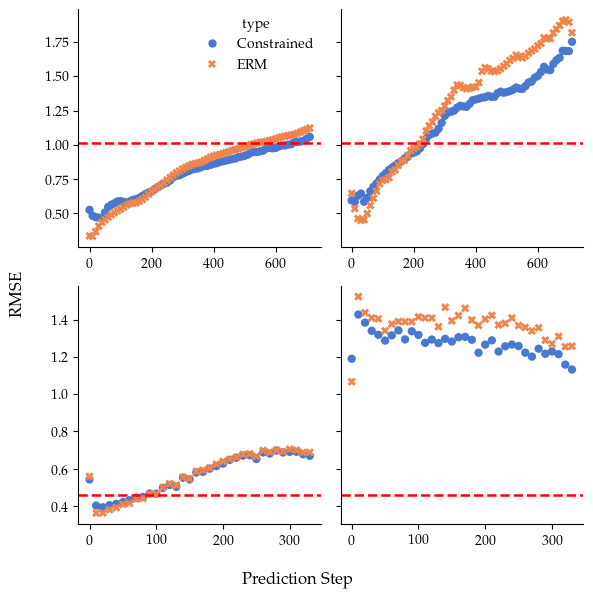

(2112, 130)
failures
Constraint levels per model to verify:


model  constraint_level
202536  Autoformer             0.392
553608    Informer             0.212

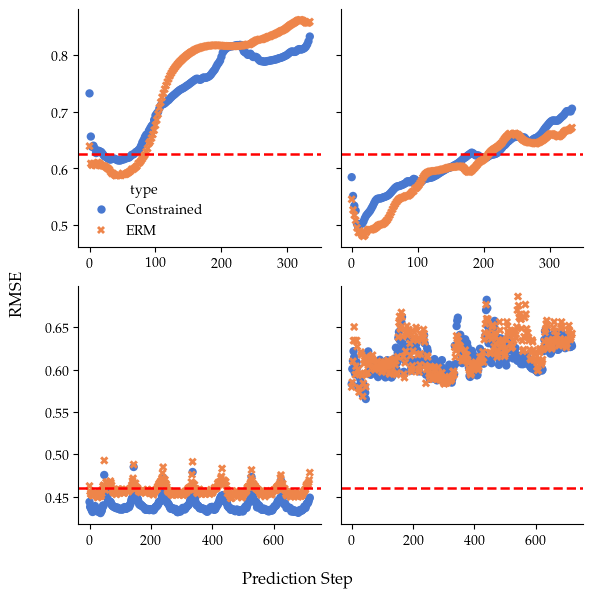

In [237]:

# Get the two success cases and two failures cases in separate dfs
# constant and erm
#**ECL192 transformer**
#**Weather 192 REformer
#Drop this one in favor of a more textbook one
#success1 = df_to_plot.query('data_path=="electricity.csv" and pred_len==192 and split!="val" and model=="Transformer" and (constraint_type=="constant" or constraint_type=="erm")').copy()
success1 = df_to_plot.query('data_path=="exchange_rate.csv" and pred_len==720 and split!="val" and model=="Autoformer" and (constraint_type=="constant" or constraint_type=="erm")').copy()
success2 = df_to_plot.query('data_path=="exchange_rate.csv" and pred_len==336 and split!="val" and model=="Reformer" and (constraint_type=="constant" or constraint_type=="erm")').copy()
#**Weather 332 Autoformer**
#**Electricity 720 Informer**
failure1 = df_to_plot.query('data_path=="weather.csv" and pred_len==336 and split!="val" and model=="Autoformer" and (constraint_type=="constant" or constraint_type=="erm")').copy()
failure2 = df_to_plot.query('data_path=="electricity.csv" and pred_len==720 and split!="val" and model=="Informer" and (constraint_type=="constant" or constraint_type=="erm")').copy()
    
# Plot all cases
success = pd.concat([success1,success2])
failures = pd.concat([failure1,failure2])
for plot_data,figname in [
    # (success1,"success_electricity_transformer_192"),
    # (success2,"success_weather_reformer_192"),
    # (failure1,"failure_weather_autoformer_332"),
    # (failure2,"failure_electricity_informer_720")
    (success,"success"),
    (failures,"failures")
    ]:
    # print(failure1.shape)
    # print(failure2.shape)
    if plot_data.pred_len.iloc[0]>500:
        evens = plot_data["step"]%10
        plot_data = plot_data[evens==0]
    # elif plot_data.pred_len.iloc[0]==336:
    #     evens = plot_data["step"]%4
    #     plot_data = plot_data[evens==0]
    else: 
        evens = plot_data["step"]%2
        plot_data = plot_data[evens==0]
    print(plot_data.shape)
    print(figname)
    
    g = sns.relplot(
        data=plot_data,
        x='step',y='rmse',
        row="model", #Autoformer,reformer
        col='split', # train, test
        hue='type', 
        style='type',
        edgecolors='none',
        height=3, 
        aspect=1.0,
        facet_kws={
            'sharex':False,
            'sharey':'row',
            'legend_out':False,
        }
    )
    
    #g.add_legend(loc='upper left')
    
    g.set_xlabels("")
    g.set_ylabels("")
    
    
    g.fig.supxlabel("Prediction Step")
    g.fig.supylabel("RMSE")
    plot_constraint_vals=plot_data[['model','constraint_level']].drop_duplicates().constraint_level.tolist()
    print("Constraint levels per model to verify:")
    display(plot_data[['model','constraint_level']].drop_duplicates())
    for i,ax in enumerate(g.axes.flat):
        ax.set_title("", fontsize='large')
        ax.axhline(y=np.sqrt(plot_constraint_vals[i//2]),color='gray',linestyle='--')
        #sns.lineplot(data=)
        ax.set_xlabel(ax.get_xlabel(), fontsize='large')
        ax.set_ylabel(ax.get_ylabel(), fontsize='large')
        
    # Add horizontal lines to each subplot
    # for ax in g.axes.flat:
    #     sns.lineplot()
        #ax.axhline(y=0, color='red', linestyle='--')

    # make markers bigger
    for ax in g.axes.flat:
        for p in ax.patches:
            p.set(markersize=20)
    # disable legend
    #g._legend.remove()
    g._legend.set_frame_on(False)

    # tight layout
    g.fig.tight_layout()
    g.savefig(f"{FIGURES_FOLDER}/{figname}.pdf")
    plt.show()

# g = sns.FacetGrid(df_current_plot, col='model', row='split', hue='constraint_type', height=3, aspect=1.5, legend_out=True,sharex=False,sharey=False)
# #g.map(sns.lineplot, "step", "constraint_level", alpha=.7)
# g.map(sns.scatterplot, "step", "mse", alpha=.7)
# g.add_legend()
# #TODO fix and uncomment
# #g.savefig(f"{FIGURES_FOLDER}/constrained_vs_erm_{pred_len}_{str(constraint_level).replace('.','')}.png")
# plt.show()

#### DEV: debugging train vs test vs multipliers
To explore why some don't change

In [ ]:
import matplotlib as mpl
# Get the two success cases and two failures cases in separate dfs
# constant and erm
#**ECL192 transformer**
#**Weather 192 REformer
#Drop this one in favor of a more textbook one
#success1 = df_to_plot.query('data_path=="electricity.csv" and pred_len==192 and split!="val" and model=="Transformer" and (constraint_type=="constant" or constraint_type=="erm")').copy()
success1 = df_to_plot.query('data_path=="exchange_rate.csv" and pred_len==720 and split!="val" and model=="Autoformer" and (constraint_type=="constant" or constraint_type=="erm")').copy()
success2 = df_to_plot.query('data_path=="exchange_rate.csv" and pred_len==336 and split!="val" and model=="Reformer" and (constraint_type=="constant" or constraint_type=="erm")').copy()
#**Weather 332 Autoformer**
#**Electricity 720 Informer**
failure1 = df_to_plot.query('data_path=="weather.csv" and pred_len==336 and split!="val" and model=="Autoformer" and (constraint_type=="constant" or constraint_type=="erm")').copy()
failure2 = df_to_plot.query('data_path=="electricity.csv" and pred_len==720 and split!="val" and model=="Informer" and (constraint_type=="constant" or constraint_type=="erm")').copy()
    
# Plot all cases
success = pd.concat([success1,success2])
failures = pd.concat([failure1,failure2])
for plot_data,figname in [
    # (success1,"success_electricity_transformer_192"),
    # (success2,"success_weather_reformer_192"),
    # (failure1,"failure_weather_autoformer_332"),
    # (failure2,"failure_electricity_informer_720")
    (success,"success"),
    (failures,"failures")
    ]:
    # print(failure1.shape)
    # print(failure2.shape)
    if plot_data.pred_len.iloc[0]>500:
        evens = plot_data["step"]%10
        plot_data = plot_data[evens==0]
    # elif plot_data.pred_len.iloc[0]==336:
    #     evens = plot_data["step"]%4
    #     plot_data = plot_data[evens==0]
    else: 
        evens = plot_data["step"]%2
        plot_data = plot_data[evens==0]
    print(plot_data.shape)
    print(figname)
    
    g = sns.relplot(
        data=plot_data,
        x='step',y='mse',
        row="model", #Autoformer,reformer
        col='split', # train, test
        hue='type', 
        style='type',
        height=3, 
        aspect=1.0,
        facet_kws={
            'sharex':False,
            'sharey':'row',
            'legend_out':True,
        }
    )
    
    g.add_legend()
    
    g.set_xlabels("")
    g.set_ylabels("")
    
    g.fig.supxlabel("Prediction Step")
    g.fig.supylabel("MSE")
    plot_constraint_vals=plot_data[['model','constraint_level']].drop_duplicates().constraint_level.tolist()
    print("Constraint levels per model to verify:")
    display(plot_data[['model','constraint_level']].drop_duplicates())
    for i,ax in enumerate(g.axes.flat):
        ax.set_title("", fontsize='large')
        ax.axhline(y=plot_constraint_vals[i//2],color='red',linestyle='--')
        #sns.lineplot(data=)
        ax.set_xlabel(ax.get_xlabel(), fontsize='large')
        ax.set_ylabel(ax.get_ylabel(), fontsize='large')
        
    # Add horizontal lines to each subplot
    # for ax in g.axes.flat:
    #     sns.lineplot()
        #ax.axhline(y=0, color='red', linestyle='--')

    # make markers bigger
    for ax in g.axes.flat:
        for p in ax.patches:
            p.set(markersize=20)
    # disable legend
    g._legend.remove()
    # tight layout
    g.fig.tight_layout()
    g.savefig(f"{FIGURES_FOLDER}/{figname}.pdf")
    plt.show()

# g = sns.FacetGrid(df_current_plot, col='model', row='split', hue='constraint_type', height=3, aspect=1.5, legend_out=True,sharex=False,sharey=False)
# #g.map(sns.lineplot, "step", "constraint_level", alpha=.7)
# g.map(sns.scatterplot, "step", "mse", alpha=.7)
# g.add_legend()
# #TODO fix and uncomment
# #g.savefig(f"{FIGURES_FOLDER}/constrained_vs_erm_{pred_len}_{str(constraint_level).replace('.','')}.png")
# plt.show()

### REVIEWER REQUEST: Multipliers over the window (related to tran vs test with resilience)

In [ ]:
example_one = df_to_plot.query('(constraint_type=="constant" or constraint_type=="erm") and data_path=="exchange_rate.csv" and model=="Autoformer" and pred_len==720')

example_two = df_to_plot_nogs.query('((constraint_type=="constant" and constraint_idx==1) or constraint_type=="erm") and data_path=="ETTm1.csv" and model=="Reformer" and pred_len==336')
example_three = df_to_plot_nogs.query('((constraint_type=="constant" and constraint_idx==1) or constraint_type=="erm") and data_path=="electricity.csv" and model=="Transformer" and pred_len==192')
#display(example_one)
for figname,data in [('exchange_autoformer_720',example_one),('ettm1_reformer_336',example_two),('electricity_transformer_192',example_three)]:
#for data in [example_two]:
    g1 = sns.relplot(
        data=data.query('split=="train" and constraint_type=="constant"'),
        x="step", y="mse",
        hue='type',
        style="type",
        edgecolors='none',
        palette=constrained_vs_erm_color_palette,
        markers=MARKER_PER_TYPE_BIG,
        facet_kws={
            'sharex': False,
            'sharey': False,
            'legend_out': False,
        }
        )#, alpha=.7,color='red',label='Multiplier')
    g1.set_titles("ERM vs Constrained")
    #g._legend
    g1._legend.set_frame_on(False)
    g1._legend.set_title("")
    g1.figure.suptitle("Train MSE")
    
    
    #TODO dev adding multilpiers
    plot_constraint_vals=plot_data[['model','constraint_level']].drop_duplicates().constraint_level.tolist()
    print("Constraint levels per model to verify:")
    display(plot_data[['model','constraint_level']].drop_duplicates())
    for i,ax in enumerate(g.axes.flat):
        ax.set_title("", fontsize='large')
        ax.axhline(y=plot_constraint_vals[i//2],color='red',linestyle='--')
        #sns.lineplot(data=)
        ax.set_xlabel(ax.get_xlabel(), fontsize='large')
        ax.set_ylabel(ax.get_ylabel(), fontsize='large')
    #TODO dev adding multipliers
    
    g1.savefig(f"../figures/icml_post_rebuttal/train_{figname}.pdf")
    
    plt.show()
    g2 = sns.relplot(
        data=data.query("constraint_type=='constant'"),
        x="step", 
        y="multiplier",
        palette=constrained_vs_erm_color_palette,
        markers=MARKER_PER_TYPE_BIG,
        edgecolors='none',
        facet_kws={
            'sharex': False,
            'sharey': False,
            'legend_out': False,
        }
        )#, alpha=.7,color='red',label='Multiplier')
    
    g2.figure.suptitle("Multipliers")
    g2.savefig(f"../figures/icml_post_rebuttal/multipliers_{figname}.pdf")
    plt.show()


### ALL Multipliers constant vs resilience

In [ ]:
# Reformer Weather 720
dd_show=df_to_plot.query('model=="Reformer" and data_path=="weather.csv" and pred_len==720 and constraint_type=="constant"')

# sns.relplot(
#     data=dd_show,
#     x='step',
#     y='multiplier',
#     hue='type'
# )
#dd_show.seed

In [ ]:
split="train"
df_to_plot.query(f'split==@split and constraint_type in ["{CONSTRAINT_TYPE}","{CONSTRAINT_TYPE}_resilience"]').type.unique()

df_to_plot.query(f'split==@split and constraint_type in ["{CONSTRAINT_TYPE}","{CONSTRAINT_TYPE}_resilience"]')[['run_id','model','data_path','constraint_type','type','constraint_level','resilient_lr']] \
     .sort_values(['model','data_path']) \
    .query('type=="ERM"') \
    .drop_duplicates()


In [ ]:
# PARAMS
split="train"
#constraint_idx = 1 # use the 50 percentile constraint to plot 1=25,2=50,3=75

# Filter
df_pct50 = df_to_plot[
    (df_to_plot.split==split)
    & (df_to_plot.constraint_type.isin([CONSTRAINT_TYPE,f"{CONSTRAINT_TYPE}_resilience"]))
    ].copy()

df_pct50 = df_to_plot.query('split==@split and constraint_type in [@CONSTRAINT_TYPE,@CONSTRAINT_TYPE+"_resilience"]')

PRED_LENS=sorted(df_pct50.pred_len.unique().tolist())
DATA_PATHS=df_pct50.data_path.unique()

#PRED_LENS=[96]
for data_path in DATA_PATHS:
    # Add data for constant line
    df_current_plot = df_pct50.query('data_path==@data_path').copy()
    print(f"constraint_types={df_current_plot.constraint_type.unique()}")
    print(f"types={df_current_plot.type.unique()}")
    display(Markdown(f"#### **Multipliers Constrained vs Resilience {data_path}**"))
    g = sns.relplot(
        data=df_current_plot,
        x='step',
        y='multiplier',
        hue='type',
        row='model',
        col='pred_len',
        height=3, 
        aspect=1.5,
        markers=MARKER_PER_TYPE,
        palette=constrained_vs_erm_color_palette,
        facet_kws={
            'sharex': False,
            'sharey': 'row',
            'legend_out': True,
        }
    )

    g.add_legend()
    g.savefig(f"{FIGURES_FOLDER}/multipliers_vs_loss_{data_path}.png")
    plt.show()

### DEV: Compare Single ungridsearched train,test shapes and multipliers
To find an illustrative example

In [ ]:
#current_df.query('split=="test"').groupby('type')['mse'].mean()

In [ ]:
# Everything is perfect but the multiplier doesn't converge
# model="Autoformer"
# data_path="exchange_rate.csv"
# pred_len=720

# FiLM doesn't change anything
# model="FiLM"
# data_path="exchange_rate.csv"
# pred_len=720

# The most promising alternative right now
# model="Autoformer"
# data_path="electricity.csv"
# pred_len=336

model="Transformer"
data_path="traffic.csv"
pred_len=720



current_df = df_to_plot_nogs.query("model==@model and data_path==@data_path and pred_len==@pred_len and constraint_type!='erm'").copy()

current_levels = current_df[['constraint_idx','constraint_level']].drop_duplicates().sort_values('constraint_idx').constraint_level.tolist()
print(current_levels)

g = sns.relplot(
    data=current_df,
    x='step',
    y='multiplier',
    hue='type',
    row='model',
    col='constraint_idx',
    palette=constrained_vs_erm_color_palette
)
g.figure.suptitle("Multipliers per constraint level")

g = sns.relplot(
    data=current_df.query('split=="train"'),
    x='step',
    y='mse',
    hue='type',
    row='model',
    col='constraint_idx',
    palette=constrained_vs_erm_color_palette,
)
g.figure.suptitle("Train per constraint level")

g = sns.relplot(
    data=current_df.query('split=="test"'),
    x='step',
    y='mse',
    hue='type',
    row='model',
    col='constraint_idx',
    palette=constrained_vs_erm_color_palette,
)
g.figure.suptitle("Test per constraint level")


### Is train correlated with test?

In [ ]:
model="Autoformer"
data_path="exchange_rate.csv"
pred_len=720

dd=df_to_plot.query('model==@model & data_path==@data_path & type=="ERM" & pred_len==@pred_len')
# Create a dataset of mse train and mse test for each step with dd using melt
dd_train = dd.query('split=="train"').copy()
dd_test = dd.query('split=="test"').copy()

dd_plot=dd_train.merge(dd_test,on="step",suffixes=('_train','_test'))[['step','mse_train','mse_test']]
#dd2['diff'] = dd2.test-dd2.train

sns.scatterplot(dd_plot, x="mse_train", y="mse_test", alpha=.7,)

### (old) ERM vs constrained

In [ ]:
from IPython.display import display, Markdown
to_plot = df_to_plot[(df_to_plot.split=='test')].copy()
for (data_path,pred_len), series in to_plot.groupby(['data_path',"pred_len"]):
    constraints = series.constraint_idx.unique()
    print(constraints)
    constraints = constraints[constraints!=-1] # to iterate over all constraints explored.
    for constraint_idx in constraints:
        display(Markdown(f"### Dataset: {data_path} pred_len: {pred_len} constraint_idx: {constraint_idx}"))
        plot_series = series#series[series["constraint_idx"]==constraint_idx]
        
        #means_per_experiment = plot_series.groupby(['pred_len','constraint_level','Algorithm','model','epoch','type'])['mse'].mean().reset_index()
        #display(means_per_experiment)
        # do a pivot where model are the rows, and the columns constrained and unconstrained
        #display(means_per_experiment.pivot(index=['model'], columns='type', values='mse').reset_index())

        # sns.scatterplot(x="step", y="mse", hue="Algorithm",style="split", data=plot_series)
        
        # plt.axhline(y=constraint_level, color='r', linestyle='-')
        # plt.title(f"Pred Length: {pred_len}, Constraint_level: {constraint_level}")
        # plt.show()

        # This same scatterplot but in a grid by algorithm. 
        g = sns.FacetGrid(plot_series, col="model", hue="type")
        g.map(sns.scatterplot, "step", "mse", alpha=.7)
        g.add_legend()
        # add the hline
        # for ax in g.axes:
        #     ax.axhline(y=constraint_level, color='r', linestyle='-')
        plt.show()
        # export this plot to latex. Remove the dot in constraint_level decimal
        #TODO fix
        #g.savefig(f"{FIGURES_FOLDER}/constrained_vs_erm_{data_path.replace('.','')}_{pred_len}_{str(constraint_level).replace('.','')}.png")
        # Fix [Errno 2] No such file or directory: 'figures/electricity.csv_96_0.17_individual.png'


### Loss shaping single instance qualitative analysis

### Plotting dual variables

In [ ]:
df_to_plot[['run_id','pred_len','constraint_level','data_path','model','type']].drop_duplicates().query("data_path=='weather.csv' and model=='Reformer' and type=='Constrained'")

In [ ]:
# #df_to_plot.query('split=="train" and pred_len==96').run_id.head(1)
# #mult_cols = [f"multiplier/{i}" for i in range(0,96)]
# # Plot for every constraint level in the 96 pred len window
# #for pred_len in df_to_plot.pred_len.unique():
# display(Markdown(f"# Multipliers for window of {pred_len}"))
# # sns.scatterplot(x="step", y="multiplier", hue="model",style="constraint_level", 
# #     data=df_to_plot.query(f"split=='train' and type=='Constrained' and pred_len=={96} and data_path=='weather.csv'"))
# # same plot, but grid with one plot per model
# dd = df_to_plot#df_to_plot.query("run_id=='6fgam2dx' and split=='train'")#.query(f"split=='train' and type=='Constrained' and pred_len==96 and data_path=='electricity.csv' and model=='Reformer' and constraint_level==0.157")
# dd_test = df_to_plot#df_to_plot.query("run_id=='6fgam2dx' and split=='test'")#.query(f"split=='test' and type=='Constrained' and pred_len==96 and data_path=='electricity.csv' and model=='Reformer' and constraint_level==0.157")

# #print(dd_test.constraint_level.unique())
# test_set_plus_multipliers = dd[['step','multiplier']].merge(dd_test[['step','split','mse']],on='step')

# unioned = pd.concat([dd[['step','split','multiplier','mse']],test_set_plus_multipliers[['step','split','multiplier','mse']]])

# display(unioned)


# display(test_set_plus_multipliers)

# #constraint_level==0.553
# # mult on x, mse@train and mse@test on y. hue=split
# # Add step over every point
# sns.scatterplot(unioned,x="multiplier", y="mse",hue='split', alpha=.3,legend='full')



# g = sns.FacetGrid(dd, col="model", row="constraint_level")
# g.map(sns.scatterplot, "step", "multiplier", alpha=.3)
# #g.map(sns.scatterplot, "step", "mse", alpha=.3)

## ===RESULT TABLES===
1. Reproduce the pivot table from notebook 11, perhaps add standard deviation reports.
2. Explore and find other interesting table visualziation

In [ ]:
#DEBUG
pd.set_option('display.max_rows',None)
#summary_metrics[summary_metrics.data_path.isin(['weather.csv','electricity.csv','exchange_rate.csv'])].groupby(['data_path','model','pred_len']).size().sort_values().reset_index()
#summary_metrics.query('model=="Autoformer"').groupby(['data_path','pred_len'])['mae'].mean()

### PAPER (WORKING): Result Pivot per metric/dataset

In [ ]:
dd_tp2=summary_metrics_to_plot.query('model=="Autoformer" and data_path=="ETTh2.csv"').query(f'data_path=="ETTh2.csv" and split=="test"').copy()
dd_grouped_values=dd_tp2.groupby(['pred_len','model','constraint_type'],dropna=False)[[
            'mse',
            #'mcv',
            'mae',
            'std_mse',
            #'std_mcv',
            'mean_infeasible_rate',
            'std_infeasible_rate',
            'window_std'
            ]].mean().reset_index()
#dd_grouped_values
df.query('model=="Autoformer" and data_path=="ETTh2.csv"').type.unique()
real_df_resilience.query('model=="Autoformer" and data_path=="ETTh2.csv"').type.unique()

In [390]:
# newindex=pd.MultiIndex.from_arrays(
#     [result_table.loc[result_table.index.get_level_values(0)=="illness.csv"].index.get_level_values(0), [24, 36, 48, 60]]
# )
# result_table.loc[result_table.index.get_level_values(0)=="illness.csv"].index=newindex
# result_table[result_table.index.get_level_values(0)=="illness.csv"].index


In [391]:
result_table_bb

metric                window_std                                           \
constraint_type             1ERM      2Ours    3Ours+R      1ERM    2Ours   
model                 Autoformer Autoformer Autoformer      FiLM     FiLM   
ETTh1.csv         96     0.02408    0.03235    0.01907  0.070390  0.06369   
                  192    0.13863    0.14082    0.33752  0.073190  0.06403   
                  336    0.08268    0.10875    0.02810  0.074860  0.06290   
                  720    0.55710    0.27824    1.20761  0.142390  0.13372   
ETTh2.csv         96     0.04113    0.02876    0.02844  0.045630  0.04321   
                  192    0.01460    0.02298    0.04748  0.053300  0.05022   
                  336    0.07877    0.02026    0.07325  0.053880  0.05059   
                  720    0.07077    0.08816    0.04479  0.070940  0.06674   
ETTm1.csv         96     0.06293    0.06066    0.06458  0.069950  0.05428   
                  192    0.09063    0.09323    0.03847  0.087580  0.07671   
                  336    0.06186    0.06282    0.03326  0.105360  0.09757   
                  720    0.06208    0.06115    0.05460  0.101630  0.09381   
ETTm2.csv         96     0.03370    0.02403    0.02014  0.028240  0.02492   
                  192    0.02705    0.02518    0.02618  0.035310  0.03204   
                  336    0.04051    0.03787    0.03195  0.048360  0.04582   
                  720    0.05199    0.06107    0.07227  0.063850  0.06097   
electricity.csv   96     0.01549    0.01513    0.01303  0.050210  0.03067   
                  192    0.02168    0.02132    0.02034  0.044950  0.02927   
                  336    0.04303    0.03856    0.01952  0.054850  0.03706   
                  720    0.03475    0.03020    0.15605  0.052400  0.05310   
exchange_rate.csv 96     0.08068    0.08517    0.04897  0.057890  0.04383   
                  192    1.34894    0.11480    0.11517  0.116420  0.09593   
                  336    2.13358    0.20957    0.20785  0.229240  0.17700   
                  720    1.03797    0.74336    0.31953  0.665300  0.48525   
illness.csv       24     0.11299    0.14001    0.20286  0.607320  0.60151   
                  36     0.19749    0.21257    0.34241  0.557150  0.54749   
                  48     0.30843    0.23680    0.37615  0.618400  0.61459   
                  60     0.56091    0.56607    0.39808  0.404790  0.40313   
traffic.csv       96     0.02263    0.01878    0.02360  0.025670  0.12116   
                  192    0.03585    0.02644    0.04723  0.024510  0.12545   
                  336    0.03122    0.02852    0.02732  0.031310  0.13313   
                  720    0.03611    0.03999    0.06372  0.053760  0.13253   
weather.csv       96     0.06001    0.03337    0.03105  0.047990  0.04289   
                  192    0.05253    0.05091    0.04459  0.057920  0.05457   
                  336    0.06787    0.06345    0.06459  0.070030  0.07031   
                  720    0.07902    0.07436    0.06060  0.082945  0.08863   

metric                                                     \
constraint_type        3Ours+R     1ERM    2Ours  3Ours+R   
model                     FiLM Informer Informer Informer   
ETTh1.csv         96   0.05217  0.18317  0.12226  0.11426   
                  192  0.05219  0.21063  0.18328  0.12758   
                  336  0.05261  0.18053  0.15604  0.20049   
                  720  0.12566  0.17014  0.16922  0.19248   
ETTh2.csv         96   0.04065  0.13777  0.10965  0.10911   
                  192  0.04755  0.25092  0.15466  0.14717   
                  336  0.04934  0.20256  0.09664  0.08809   
                  720  0.06622  0.24788  0.14226  0.11809   
ETTm1.csv         96   0.05085  0.15726  0.11857  0.13293   
                  192  0.06907  0.11966  0.06554  0.07221   
                  336  0.08854  0.17025  0.17224  0.13710   
                  720  0.07604  0.12818  0.12703  0.10135   
ETTm2.csv         96   0.02225  0.06361  0.02957  0.02912   
                  19

In [397]:
import itertools
from functools import reduce
def style_pivot_table_best_per_params(pivoted_df):
    pivoted_df=pivoted_df.copy()
    pivoted_df.columns.names = ['metric','constraint_type','model']
    mask = pd.DataFrame(False, index=pivoted_df.index, columns=pivoted_df.columns)
    for keys,subset in  pivoted_df.groupby(level=['metric','model'],axis=1,dropna=False):
        mask.loc[:,subset.columns] = subset.eq(subset.min(axis=1), axis=0)
        
    ##STYLE
    # truncate to 4 decimals for display
    pivoted_df=pivoted_df.style.format("{:.3f}")
    pivoted_df=pivoted_df.apply(lambda s: ['font-weight: bold;text-decoration: underline' if v else '' for v in mask.loc[s.name]], axis=1)
    return pivoted_df

def data_path_renaming(x):
    if x=="exchange_rate.csv":
        x='Exchange'
    x=x.replace(".csv","")
    if x=="electricity":
        x="ECL"
    else: 
        x=x.replace(".csv","").replace("_"," ").title()
    return latex_scaffolding_dataset(x)
def latex_scaffolding_dataset(x):
    # Add rotatebox
    x=r'\rotatebox'+'{90}{'+x+'}'
    x=r'\multirow{4}{*}{'+x+'}'
    return x
def text_bf(x):
    return r'\textbf{'+str(x)+'}'
def text_ul(x):
    return f"\\underline{{{x}}}"
# def latex_style_best(pivoted_df):
#     pivoted_df=pivoted_df.copy()
#     pivoted_df.columns.names = ['metric','constraint_type','model']
#     mask = pd.DataFrame(False, index=pivoted_df.index, columns=pivoted_df.columns)
#     for keys,subset in  pivoted_df.groupby(level=['metric','model'],axis=1,dropna=False):
#         mask.loc[:,subset.columns] = subset.eq(subset.min(axis=1), axis=0)
#     #if mask is true, add text_bf
#     boldface_df = pivoted_df.copy().applymap(lambda x: f"{x:.3f}")
#     boldface_df[mask] = boldface_df.applymap(text_bf)
#     return boldface_df

# def latex_style_best_and_second(pivoted_df):
#     """Copy of the latext_style_best but also adds underline to the second best. 
#     It works, but looks ugly"""
#     pivoted_df = pivoted_df.copy()
#     pivoted_df.columns.names = ['metric', 'constraint_type', 'model']
    
#     mask_best = pd.DataFrame(False, index=pivoted_df.index, columns=pivoted_df.columns)
#     mask_second = pd.DataFrame(False, index=pivoted_df.index, columns=pivoted_df.columns)
    
#     for keys, subset in pivoted_df.groupby(level=['metric', 'model'], axis=1, dropna=False):
#         best = subset.min(axis=1)
#         mask_best.loc[:, subset.columns] = subset.eq(best, axis=0)
        
#         second_best = subset.apply(lambda row: row[row != row.min()].min(), axis=1)
#         mask_second.loc[:, subset.columns] = subset.eq(second_best, axis=0)
    
#     styled_df = pivoted_df.copy().applymap(lambda x: f"{x:.3f}")
#     styled_df[mask_best] = styled_df[mask_best].applymap(text_bf)
#     styled_df[mask_second] = styled_df[mask_second].applymap(text_ul)
    
#     return styled_df

def latex_string_replacements(latex_str):
    return 


pd.set_option('display.max_columns', None)
def compute_pivot_over_metric(summary_metrics,pivot_value_columns=['window_std'],split='test'):
    pivoted_tables=[]
    data_paths=summary_metrics.data_path.unique()
    for data_path in data_paths:
        tp2=summary_metrics.query(f'data_path==@data_path and split==@split').copy()

        #GROUPING TEH VALS
        grouped_values=tp2.groupby(['pred_len','model','constraint_type'],dropna=False)[[
            'mse',
            #'mcv',
            'mae',
            'std_mse',
            #'std_mcv',
            'mean_infeasible_rate',
            'std_infeasible_rate',
            'window_std'
            ]].mean().reset_index()
        
        # Pivot of models versus constrained and ERM, values are mse and mse_diff
        all_results = grouped_values
        
        # Pivot all results, sort ascending by pred_len, then mean_violation on constrained
        pivoted=all_results.pivot(
            index=['pred_len'],
            columns=['constraint_type','model'], 
            values=pivot_value_columns
        )
        
        pivoted=style_pivot_table_best_per_params(pivoted)
        #display(pivoted)
        pivoted_tables.append(pivoted)
    result_table = pd.concat([d.data for d in pivoted_tables],keys=data_paths,names=['data_path'])

    return result_table
display(Markdown(f"# Pivot tables for split=test"))

#THIS RUNS ALL
summary_metrics_to_plot = summary_metrics.query("constraint_type!='monotonic_resilience'")
#THIS RUNS OLD DATASETS ALL MODELS
#summary_metrics_to_plot = summary_metrics[summary_metrics.data_path.isin(['weather.csv','electricity.csv','exchange_rate.csv'])].query("constraint_type!='monotonic_resilience'").copy()
# THIS RUNS ALL DATASETS OLD MODELS
#summary_metrics_to_plot = summary_metrics[summary_metrics.model.isin(['Autoformer','Reformer','Informer','Transformer'])].query("constraint_type!='constant_resilience' and data_path!='national_illness.csv'").copy()
# THIS IS ILLNESS
#summary_metrics_to_plot = summary_metrics[summary_metrics.model.isin(['Autoformer','Reformer','Informer','Transformer'])].query("data_path=='national_illness.csv'").copy()
#print(summary_metrics_to_plot.pred_len.unique())

# rename constraint_types to be more readable
summary_metrics_to_plot['constraint_type'] = summary_metrics_to_plot['constraint_type'].replace({
    'erm':'1ERM',
    'constant':'2Ours',
    'constant_resilience':'3Ours+R',
    'monotonic': '1Ours'
})

summary_metrics_to_plot['data_path'] = summary_metrics_to_plot['data_path'].replace({
    'national_illness.csv': 'illness.csv'
})

# mega hack: replace illness pred lens so that the join matches:
summary_metrics_to_plot['pred_len'] = summary_metrics_to_plot['pred_len'].replace({
    24: 96,
    36: 192,
    48: 336,
    60: 720
})

# FILLING BLANKS TO NOT BREKA THE TABLE
base_df=summary_metrics_to_plot
models = base_df.model.unique()

#models = ["Autoformer","Reformer","Informer","Pyraformer","iTransformer","Transformer"]
pred_lens = [96, 192, 336, 720] 
#pred_lens = [24, 36, 48, 60] #ILLNESS
constraint_type=base_df.constraint_type.unique()
split=base_df.split.unique()
data_paths=base_df.data_path.unique()
# Create a dataframe with all expected keys by crossjoining
keys = ['model','pred_len','constraint_type','split','data_path']
print(len(models)*len(pred_lens)*len(constraint_type)*len(split)*len(data_paths))
df_keys = pd.DataFrame(list(itertools.product(*[models,pred_lens,constraint_type,split,data_paths])),columns=keys)
#df_keys.merge(base_df,how='left',on=keys)['mse']
filler=9999
summary_metrics_to_plot=df_keys.merge(base_df,how='left',on=keys).fillna({'mse':filler,'mae':filler,'rmse':filler,'window_std':filler})

# Now, replace back pred lens where data_path==illness.csv
# summary_metrics_to_plot['pred_len'] = summary_metrics_to_plot.loc[summary_metrics_to_plot.data_path=='illness.csv','pred_len'].replace({
#     96: 24,
#     192: 36,
#     336: 48,
#     720: 60
# })

for metric in [
    #'mcv',
    'mse',
    'mae',#TODO broken for new models
    #'mean_infeasible_rate',
    'window_std',
    ]:
    result_table = compute_pivot_over_metric(summary_metrics_to_plot,pivot_value_columns=[metric],split='test')
    
    # START MEGA HACK PT 2 Now, replace back pred lens where data_path==illness.csv
    result_table = result_table.copy()
    curr_index = result_table.index.copy()
    new_sub_index = curr_index[curr_index.get_level_values(0)=="illness.csv"].set_levels([24, 36, 48, 60],level=1)
    replace_pred_w_illness = {96:24,192:36,336:48,720:60}
    # convert to tuples
    curr_index_tuples = []
    for l1,l2 in curr_index:
        if l1=="illness.csv":
            newl2 = replace_pred_w_illness[l2]
            curr_index_tuples.append((l1,newl2))
        else: 
            curr_index_tuples.append((l1,l2))
    result_table.index = pd.MultiIndex.from_tuples(curr_index_tuples)
    #END MEGA HACK PT 1
    
    display(Markdown(f"## {metric}"))   
    # add bold
    display(style_pivot_table_best_per_params(result_table.replace({filler:np.nan})))
    
    first_cols=result_table.columns.get_level_values(2).isin(result_table.columns.get_level_values(2)[:12])
    second_cols=result_table.columns.get_level_values(2).isin(result_table.columns.get_level_values(2)[12:])

    for i,result_table_portion in enumerate([result_table.loc[:,first_cols],result_table.loc[:,second_cols]]):
    
        #latex styling
        latex_table=result_table_portion.copy()

        latex_table.index=latex_table.index \
            .set_levels([data_path_renaming(level) for level in latex_table.index.levels[0]],level=0)

        latex_table=latex_style_best(latex_table)
        # latex_table=latex_style_best_and_second(latex_table)
            
        # drop the metric level in the multiindex
        latex_table.columns=latex_table.columns.droplevel(0)

        # Swap the column multiindex to model on top
        latex_table=latex_table.swaplevel(0,1,axis=1)

        #latex_table=style_pivot_table_best_per_params(latex_table)
        # Show only :.4f
        # Rename data_path to None
        latex_table=latex_table.rename_axis(index={'data_path':None,'pred_len':''},columns={'model':'','constraint_type':''})
        #display(latex_table.columns)
        # refactor the multiindex in columns so that repeated models merge
        #print(latex_table.to_latex(escape=False,index_names=False,multicolumn_format='c',multicolumn=True))
        columns_per_model=reduce(lambda a,b: a+"|"+b,['ccc']*len(models))
        print(latex_table.to_latex(escape=False,multicolumn_format='c',multicolumn=True,column_format=f'cc|{columns_per_model}').replace("9999.000","N/A"))
        # save to file
        with open(f"../figures/icml_post_rebuttal/{metric}_{i}_table.tex","w") as f:
            f.write(latex_table.to_latex(escape=False,multicolumn_format='c',multicolumn=True,column_format=f'cc|{columns_per_model}').replace("9999.000","N/A"))
        #to markdown
        #print(result_table_portion.to_markdown())
    


# Pivot tables for split=test

2592


/var/folders/02/rwff5ttj1r9_5hnh3k8rm7tr0000gq/T/ipykernel_4921/1674580452.py:7: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  for keys,subset in  pivoted_df.groupby(level=['metric','model'],axis=1,dropna=False):
/var/folders/02/rwff5ttj1r9_5hnh3k8rm7tr0000gq/T/ipykernel_4921/1674580452.py:7: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  for keys,subset in  pivoted_df.groupby(level=['metric','model'],axis=1,dropna=False):
/var/folders/02/rwff5ttj1r9_5hnh3k8rm7tr0000gq/T/ipykernel_4921/1674580452.py:7: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  for keys,subset in  pivoted_df.groupby(level=['metric','model'],axis=1,dropna=False):
/var/folders/02/rwff5ttj1r9_5hnh3k8rm7tr0000gq/T/ipykernel_4921/1674580452.py:7: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` wi

## mse

/var/folders/02/rwff5ttj1r9_5hnh3k8rm7tr0000gq/T/ipykernel_4921/1674580452.py:7: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  for keys,subset in  pivoted_df.groupby(level=['metric','model'],axis=1,dropna=False):


/var/folders/02/rwff5ttj1r9_5hnh3k8rm7tr0000gq/T/ipykernel_4921/3179332171.py:37: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  for keys,subset in  pivoted_df.groupby(level=['metric','model'],axis=1,dropna=False):
/var/folders/02/rwff5ttj1r9_5hnh3k8rm7tr0000gq/T/ipykernel_4921/3179332171.py:40: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  boldface_df = pivoted_df.copy().applymap(lambda x: f"{x:.3f}")
/var/folders/02/rwff5ttj1r9_5hnh3k8rm7tr0000gq/T/ipykernel_4921/3179332171.py:41: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  boldface_df[mask] = boldface_df.applymap(text_bf)
/var/folders/02/rwff5ttj1r9_5hnh3k8rm7tr0000gq/T/ipykernel_4921/3179332171.py:37: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  for keys,subset in  pivoted_df.groupby(level=['metric','model'],axis=1,dropna=False):

\begin{tabular}{cc|ccc|ccc|ccc|ccc|ccc|ccc|ccc|ccc}
\toprule
 &  & \multicolumn{3}{c}{Autoformer} & \multicolumn{3}{c}{FiLM} & \multicolumn{3}{c}{Informer} & \multicolumn{3}{c}{Nonstationary_Transformer} \\
 &  & 1ERM & 2Ours & 3Ours+R & 1ERM & 2Ours & 3Ours+R & 1ERM & 2Ours & 3Ours+R & 1ERM & 2Ours & 3Ours+R \\
\midrule
\multirow[t]{4}{*}{\multirow{4}{*}{\rotatebox{90}{Etth1}}} & 96 & 0.679 & 0.644 & \textbf{0.606} & 0.468 & \textbf{0.459} & 0.514 & 0.890 & \textbf{0.800} & 0.812 & 0.623 & 0.623 & \textbf{0.585} \\
 & 192 & 0.869 & \textbf{0.838} & 1.085 & 0.524 & \textbf{0.514} & 0.561 & 1.179 & 1.040 & \textbf{0.987} & 0.647 & 0.647 & \textbf{0.611} \\
 & 336 & 0.853 & 0.896 & \textbf{0.653} & 0.578 & \textbf{0.567} & 0.612 & 1.237 & \textbf{1.232} & 1.333 & 0.853 & \textbf{0.819} & 0.842 \\
 & 720 & 1.107 & \textbf{1.052} & 1.274 & 0.751 & \textbf{0.732} & 0.769 & 1.278 & \textbf{1.277} & 1.285 & 0.967 & 0.974 & \textbf{0.899} \\
\cline{1-14}
\multirow[t]{4}{*}{\multirow{4}{*}{\rot

/var/folders/02/rwff5ttj1r9_5hnh3k8rm7tr0000gq/T/ipykernel_4921/1674580452.py:7: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  for keys,subset in  pivoted_df.groupby(level=['metric','model'],axis=1,dropna=False):
/var/folders/02/rwff5ttj1r9_5hnh3k8rm7tr0000gq/T/ipykernel_4921/1674580452.py:7: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  for keys,subset in  pivoted_df.groupby(level=['metric','model'],axis=1,dropna=False):
/var/folders/02/rwff5ttj1r9_5hnh3k8rm7tr0000gq/T/ipykernel_4921/1674580452.py:7: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  for keys,subset in  pivoted_df.groupby(level=['metric','model'],axis=1,dropna=False):
/var/folders/02/rwff5ttj1r9_5hnh3k8rm7tr0000gq/T/ipykernel_4921/1674580452.py:7: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` wi

## mae

/var/folders/02/rwff5ttj1r9_5hnh3k8rm7tr0000gq/T/ipykernel_4921/1674580452.py:7: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  for keys,subset in  pivoted_df.groupby(level=['metric','model'],axis=1,dropna=False):


/var/folders/02/rwff5ttj1r9_5hnh3k8rm7tr0000gq/T/ipykernel_4921/3179332171.py:37: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  for keys,subset in  pivoted_df.groupby(level=['metric','model'],axis=1,dropna=False):
/var/folders/02/rwff5ttj1r9_5hnh3k8rm7tr0000gq/T/ipykernel_4921/3179332171.py:40: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  boldface_df = pivoted_df.copy().applymap(lambda x: f"{x:.3f}")
/var/folders/02/rwff5ttj1r9_5hnh3k8rm7tr0000gq/T/ipykernel_4921/3179332171.py:41: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  boldface_df[mask] = boldface_df.applymap(text_bf)
/var/folders/02/rwff5ttj1r9_5hnh3k8rm7tr0000gq/T/ipykernel_4921/3179332171.py:37: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  for keys,subset in  pivoted_df.groupby(level=['metric','model'],axis=1,dropna=False):

\begin{tabular}{cc|ccc|ccc|ccc|ccc|ccc|ccc|ccc|ccc}
\toprule
 &  & \multicolumn{3}{c}{Autoformer} & \multicolumn{3}{c}{FiLM} & \multicolumn{3}{c}{Informer} & \multicolumn{3}{c}{Nonstationary_Transformer} \\
 &  & 1ERM & 2Ours & 3Ours+R & 1ERM & 2Ours & 3Ours+R & 1ERM & 2Ours & 3Ours+R & 1ERM & 2Ours & 3Ours+R \\
\midrule
\multirow[t]{4}{*}{\multirow{4}{*}{\rotatebox{90}{Etth1}}} & 96 & 0.607 & 0.588 & \textbf{0.565} & 0.464 & \textbf{0.457} & 0.497 & 0.734 & \textbf{0.649} & 0.652 & \textbf{0.532} & \textbf{0.532} & 0.550 \\
 & 192 & 0.700 & \textbf{0.675} & 0.748 & 0.503 & \textbf{0.495} & 0.529 & 0.828 & 0.756 & \textbf{0.731} & \textbf{0.559} & \textbf{0.559} & 0.566 \\
 & 336 & 0.682 & 0.712 & \textbf{0.602} & 0.541 & \textbf{0.532} & 0.564 & \textbf{0.828} & 0.828 & 0.866 & 0.645 & \textbf{0.639} & 0.662 \\
 & 720 & 0.772 & \textbf{0.769} & 0.804 & 0.644 & \textbf{0.632} & 0.656 & \textbf{0.857} & 0.858 & 0.860 & 0.695 & 0.703 & \textbf{0.687} \\
\cline{1-14}
\multirow[t]{4}{*}{\m

/var/folders/02/rwff5ttj1r9_5hnh3k8rm7tr0000gq/T/ipykernel_4921/1674580452.py:7: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  for keys,subset in  pivoted_df.groupby(level=['metric','model'],axis=1,dropna=False):
/var/folders/02/rwff5ttj1r9_5hnh3k8rm7tr0000gq/T/ipykernel_4921/1674580452.py:7: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  for keys,subset in  pivoted_df.groupby(level=['metric','model'],axis=1,dropna=False):
/var/folders/02/rwff5ttj1r9_5hnh3k8rm7tr0000gq/T/ipykernel_4921/1674580452.py:7: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  for keys,subset in  pivoted_df.groupby(level=['metric','model'],axis=1,dropna=False):
/var/folders/02/rwff5ttj1r9_5hnh3k8rm7tr0000gq/T/ipykernel_4921/1674580452.py:7: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` wi

## window_std

/var/folders/02/rwff5ttj1r9_5hnh3k8rm7tr0000gq/T/ipykernel_4921/1674580452.py:7: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  for keys,subset in  pivoted_df.groupby(level=['metric','model'],axis=1,dropna=False):


/var/folders/02/rwff5ttj1r9_5hnh3k8rm7tr0000gq/T/ipykernel_4921/3179332171.py:37: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  for keys,subset in  pivoted_df.groupby(level=['metric','model'],axis=1,dropna=False):
/var/folders/02/rwff5ttj1r9_5hnh3k8rm7tr0000gq/T/ipykernel_4921/3179332171.py:40: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  boldface_df = pivoted_df.copy().applymap(lambda x: f"{x:.3f}")
/var/folders/02/rwff5ttj1r9_5hnh3k8rm7tr0000gq/T/ipykernel_4921/3179332171.py:41: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  boldface_df[mask] = boldface_df.applymap(text_bf)
/var/folders/02/rwff5ttj1r9_5hnh3k8rm7tr0000gq/T/ipykernel_4921/3179332171.py:37: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  for keys,subset in  pivoted_df.groupby(level=['metric','model'],axis=1,dropna=False):

\begin{tabular}{cc|ccc|ccc|ccc|ccc|ccc|ccc|ccc|ccc}
\toprule
 &  & \multicolumn{3}{c}{Autoformer} & \multicolumn{3}{c}{FiLM} & \multicolumn{3}{c}{Informer} & \multicolumn{3}{c}{Nonstationary_Transformer} \\
 &  & 1ERM & 2Ours & 3Ours+R & 1ERM & 2Ours & 3Ours+R & 1ERM & 2Ours & 3Ours+R & 1ERM & 2Ours & 3Ours+R \\
\midrule
\multirow[t]{4}{*}{\multirow{4}{*}{\rotatebox{90}{Etth1}}} & 96 & 0.024 & 0.032 & \textbf{0.019} & 0.070 & 0.064 & \textbf{0.052} & 0.183 & 0.122 & \textbf{0.114} & 0.060 & 0.060 & \textbf{0.053} \\
 & 192 & \textbf{0.139} & 0.141 & 0.338 & 0.073 & 0.064 & \textbf{0.052} & 0.211 & 0.183 & \textbf{0.128} & 0.086 & 0.086 & \textbf{0.081} \\
 & 336 & 0.083 & 0.109 & \textbf{0.028} & 0.075 & 0.063 & \textbf{0.053} & 0.181 & \textbf{0.156} & 0.200 & \textbf{0.187} & 0.207 & 0.209 \\
 & 720 & 0.557 & \textbf{0.278} & 1.208 & 0.142 & 0.134 & \textbf{0.126} & 0.170 & \textbf{0.169} & 0.192 & 0.171 & \textbf{0.160} & 0.164 \\
\cline{1-14}
\multirow[t]{4}{*}{\multirow{4}{*}{\rot

In [ ]:
# Side product: Which runs are missing? 
summary_metrics_to_plot=df_keys.merge(base_df,how='left',on=keys).fillna({'mse':filler,'mae':filler,'rmse':filler,'window_std':filler})

### REVIEWERS: Percentage difference tables and histograms
In order to emphasize the effect of our method, we want to compute the percentage difference between ERM and constrained runs

#### Tables

In [ ]:
#delteme
#df_s
#   pred_len model        data_path constraint_type      mse  window_std
#2        96  FiLM  electricity.csv        constant  0.19848     0.03067
#summary_metrics.query('model=="FiLM" and data_path=="electricity.csv" and pred_len==96')
#summary_metrics.query('model=="FiLM" and data_path=="exchange_rate.csv" and pred_len==96 and constraint_type=="constant"')
#summary_metrics.query('model=="FiLM"').constraint_type.unique()
#print(summary_metrics.query('model=="FiLM"').to_csv())
df_to_plot.query('model=="FiLM" and data_path=="electricity.csv"').constraint_type.unique()
df.query('model=="FiLM" and data_path=="electricity.csv"').constraint_type.unique()
real_df_newmodels.query('model=="FiLM" and data_path=="electricity.csv"').constraint_type.unique()

In [ ]:
#summary_metrics.query('data_path=="exchange_rate.csv"').groupby()
dd_summary.groupby(['pred_len', 'model','data_path']).size()

In [311]:
from functools import partial

def _apply_multiple(df_s,apply_funcs):
    outs = []
    for name,func in apply_funcs:
        out_series=df_s.apply(func)
        out_series.name = name
        outs.append(out_series)
    return pd.concat(outs,axis=1).reset_index()
        

def _pct_diff(df_s,metric='mse',baseline_constraint_type='erm',comparison_constraint_type='constant'):
    # WARN: Assumes there is one and only one comparison and baseline row in each group.
    if not baseline_constraint_type in  df_s.constraint_type.unique():
        raise ValueError(f"There should be one and only one comparison and baseline row in each group. And got missing {baseline_constraint_type} in {df_s}")
    comparison = df_s[df_s.constraint_type==comparison_constraint_type][metric].to_list()[0]
    baseline = df_s[df_s.constraint_type==baseline_constraint_type][metric].to_list()[0]
    if np.isclose(baseline,0) or np.isclose(comparison,0):
        return 0.0
    pct_increase = (comparison-baseline)*100/baseline
    
    return pct_increase
acc = []

# MCV only makes sense when there is a constant constraint.
metrics_for_pct_diff = ['mse','mcv','window_std','monotonic_rate'] if CONSTRAINT_TYPE=='constant' else ['mse','window_std','monotonic_rate']
#metrics_for_pct_diff = ['mse','window_std'] if CONSTRAINT_TYPE=='constant' else ['mse','window_std']

#for data_path in ['weather.csv','electricity.csv','exchange_rate.csv']:
#data_paths=summary_metrics.query('data_path!="traffic.csv"').data_path.unique().tolist()
data_paths=summary_metrics.data_path.unique().tolist()
#data_paths=summary_metrics.query('data_path!="national_illness.csv"').data_path.unique().tolist()
for data_path in data_paths:
    #non resilience
    # dd_summary = summary_metrics[summary_metrics.data_path.isin(['weather.csv','electricity.csv','exchange_rate.csv'])].query(f"constraint_type!='{CONSTRAINT_TYPE}_resilience'").copy() \
    #         .query("data_path==@data_path and split=='test'") \
    #         .groupby(['pred_len','model','data_path','constraint_type'])[metrics_for_pct_diff].mean().reset_index()
    #resilience
    dd_summary = summary_metrics[summary_metrics.constraint_type.isin(['erm',CONSTRAINT_TYPE])].copy() \
            .query("data_path==@data_path and split=='test'") \
            .groupby(['pred_len','model','data_path','constraint_type'])[metrics_for_pct_diff].mean().reset_index()
    
    #Get a single metric from some constraint type run
    _single_metric = lambda x,ct,metric: x.query('constraint_type==@ct')[metric].mean()
    
    # This scary looking piece is just generating functions to compute each comparison metric in metrics_for_pct_diff and flattening the list.
    apply_funcs = [metric_func for sublist in ([
        (f'erm_{m}',partial(_single_metric,ct='erm',metric=m)),
        (f'{CONSTRAINT_TYPE}_{m}',partial(_single_metric,ct=CONSTRAINT_TYPE,metric=m)),
        (f'{m}_pct_diff',partial(_pct_diff, metric=m, baseline_constraint_type='erm', comparison_constraint_type=CONSTRAINT_TYPE)),
        ] for m in metrics_for_pct_diff) for metric_func in sublist]
    mse_pct_changes=_apply_multiple(
        dd_summary.groupby(['pred_len', 'model','data_path']),
        apply_funcs=apply_funcs
    )
    # display(f"MSE PCT DIFF {mse_pct_changes['mse_pct_diff'].mean()}")
    # display(f"MCV PCT DIFF {mse_pct_changes['mcv_pct_diff'].mean()}")
    #display(f"WINDOW PCT DIFF {mse_pct_changes['window_std_pct_diff'].mean()}")
    #display(mse_pct_changes)
    acc.append(mse_pct_changes[['model','data_path','pred_len'] + [f'{CONSTRAINT_TYPE}_{m}' for m in metrics_for_pct_diff] + [f'erm_{m}' for m in metrics_for_pct_diff] + [f'{m}_pct_diff' for m in metrics_for_pct_diff]])
pct_diffs_all_ds = pd.concat(acc,axis=0)
pct_diffs_all_ds

/var/folders/02/rwff5ttj1r9_5hnh3k8rm7tr0000gq/T/ipykernel_81610/3815562999.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  out_series=df_s.apply(func)
/var/folders/02/rwff5ttj1r9_5hnh3k8rm7tr0000gq/T/ipykernel_81610/3815562999.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  out_series=df_s.apply(func)
/var/folders/02/rwff5ttj1r9_5hnh3k8rm7tr0000gq/T/ipykernel_81610/3815562999.py:6: DeprecationWarni

model    data_path  pred_len  constant_mse  \
0                  Autoformer    ETTh1.csv        96       0.64440   
1                        FiLM    ETTh1.csv        96       0.45922   
2                    Informer    ETTh1.csv        96       0.79973   
3   Nonstationary_Transformer    ETTh1.csv        96       0.62339   
4                  Pyraformer    ETTh1.csv        96       0.56928   
..                        ...          ...       ...           ...   
27  Nonstationary_Transformer  weather.csv       720       0.46572   
28                 Pyraformer  weather.csv       720       0.41673   
29                   Reformer  weather.csv       720       0.78769   
30                Transformer  weather.csv       720       0.92411   
31               iTransformer  weather.csv       720       0.36284   

    constant_mcv  constant_window_std  constant_monotonic_rate  erm_mse  \
0        0.11149              0.03235                  1.00000  0.67871   
1        0.13431              0.06369                  1.00000  0.46772   
2        0.00000              0.12226                  1.00000  0.88962   
3        0.20268              0.05976                  1.00000  0.62339   
4        0.20787              0.07395                  1.00000  0.56928   
..           ...                  ...                      ...      ...   
27       0.12481              0.10693                  0.75139  0.45386   
28       0.00000              0.13216                  0.47222  0.45969   
29       0.00950              0.18394                  0.91667  0.96289   
30       0.70811              0.27623                  1.00000  1.00219   
31       0.00000              0.09433                  0.00000  0.36278   

    erm_mcv  erm_window_std  erm_monotonic_rate  mse_pct_diff  mcv_pct_diff  \
0   0.14595         0.02408             1.00000     -5.055178    -23.610826   
1   0.14354         0.07039             1.00000     -1.817327     -6.430263   
2   0.00151         0.18317             1.00000    -10.104314      0.000000   
3   0.20268         0.05976             1.00000      0.000000      0.000000   
4   0.20787         0.07395             1.00000      0.000000      0.000000   
..      ...             ...                 ...           ...           ...   
27  0.11946         0.11725             0.78333      2.613141      4.478487   
28  0.00000         0.15564             0.76528     -9.345428      0.000000   
29  0.06055         0.03900             1.00000    -18.195225    -84.310487   
30  0.78619         0.28948             1.00000     -7.790938     -9.931442   
31  0.00000         0.09678             0.00000      0.016539      0.000000   

    window_std_pct_diff  monotonic_rate_pct_diff  
0             34.343854                 0.000000  
1             -9.518397                 0.000000  
2            -33.253262                 0.000000  
3              0.000000                 0.000000  
4              0.000000                 0.000000  
..                  ...                      ...  
27            -8.801706                -4.077464  
28           -15.086096               -38.294480  
29           371.641026                -8.333000  
30            -4.577173                 0.000000  
31            -2.531515                 0.000000  

[284 rows x 15 columns]

#### Average percentage differences

In [312]:
display(f"MSE PCT DIFF {pct_diffs_all_ds['mse_pct_diff'].mean():.2f}%")
display(f"MCV PCT DIFF {pct_diffs_all_ds['mcv_pct_diff'].mean():.2f}%")
display(f"WINDOW PCT DIFF {pct_diffs_all_ds['window_std_pct_diff'].mean():.2f}%")
display(f"Monotonic rate DIFF {pct_diffs_all_ds['monotonic_rate_pct_diff'].mean():.2f}%")

'MSE PCT DIFF -5.19%'

'MCV PCT DIFF 117.42%'

'WINDOW PCT DIFF -7.89%'

'Monotonic rate DIFF -4.01%'

## Best and worst: Datset and model

In [313]:
display(Markdown("### Worst datasets"))
display(pct_diffs_all_ds.groupby('data_path')['mse_pct_diff'].mean().sort_values(ascending=False).reset_index())
display(Markdown("### Best datasets"))
display(pct_diffs_all_ds.groupby('data_path')['mse_pct_diff'].mean().sort_values(ascending=True).reset_index())

display(Markdown("### Worst models"))
display(pct_diffs_all_ds.groupby('model')['mse_pct_diff'].mean().sort_values(ascending=False).reset_index())
display(Markdown("### Best models"))
display(pct_diffs_all_ds.groupby('model')['mse_pct_diff'].mean().sort_values(ascending=True).reset_index())


display(Markdown("### Best model-dataset"))
display(pct_diffs_all_ds.groupby(['model','data_path'])['mse_pct_diff'].mean().sort_values(ascending=True).reset_index().head(15))

### Worst datasets

data_path  mse_pct_diff
0           traffic.csv      0.356654
1  national_illness.csv     -0.565554
2             ETTh1.csv     -1.951902
3       electricity.csv     -2.880327
4           weather.csv     -4.779354
5             ETTm1.csv     -4.882223
6             ETTm2.csv     -7.376020
7             ETTh2.csv    -11.000202
8     exchange_rate.csv    -12.951391

### Best datasets

data_path  mse_pct_diff
0     exchange_rate.csv    -12.951391
1             ETTh2.csv    -11.000202
2             ETTm2.csv     -7.376020
3             ETTm1.csv     -4.882223
4           weather.csv     -4.779354
5       electricity.csv     -2.880327
6             ETTh1.csv     -1.951902
7  national_illness.csv     -0.565554
8           traffic.csv      0.356654

### Worst models

model  mse_pct_diff
0               iTransformer      4.448093
1  Nonstationary_Transformer      0.033250
2                 Pyraformer     -1.826918
3                Transformer     -2.976273
4                       FiLM     -6.948344
5                 Autoformer     -8.572475
6                   Informer     -9.472651
7                   Reformer    -16.412187

### Best models

model  mse_pct_diff
0                   Reformer    -16.412187
1                   Informer     -9.472651
2                 Autoformer     -8.572475
3                       FiLM     -6.948344
4                Transformer     -2.976273
5                 Pyraformer     -1.826918
6  Nonstationary_Transformer      0.033250
7               iTransformer      4.448093

### Best model-dataset

model          data_path  mse_pct_diff
0      Reformer          ETTh2.csv    -62.097166
1    Autoformer  exchange_rate.csv    -44.015491
2      Reformer          ETTm2.csv    -37.988971
3          FiLM  exchange_rate.csv    -35.191210
4      Reformer        weather.csv    -30.059008
5      Informer  exchange_rate.csv    -23.764142
6      Informer          ETTh2.csv    -23.015573
7          FiLM    electricity.csv    -22.519231
8      Reformer          ETTm1.csv    -17.967023
9   Transformer  exchange_rate.csv    -17.525007
10     Informer          ETTm2.csv    -12.688473
11     Informer          ETTm1.csv     -9.743144
12  Transformer          ETTh1.csv     -8.178559
13   Pyraformer  exchange_rate.csv     -8.106832
14   Autoformer          ETTm1.csv     -8.013860

##  Correlations in percentage changes

### Correlations overall

In [314]:
# display(pct_diffs_all_ds[['model','pred_len','data_path','mse_pct_diff','window_std_pct_diff','mcv_pct_diff']].corr())
# pd.plotting.scatter_matrix(pct_diffs_all_ds[['model','pred_len','data_path','mse_pct_diff','window_std_pct_diff','mcv_pct_diff']])

### PAPER: Histogram percentage changes

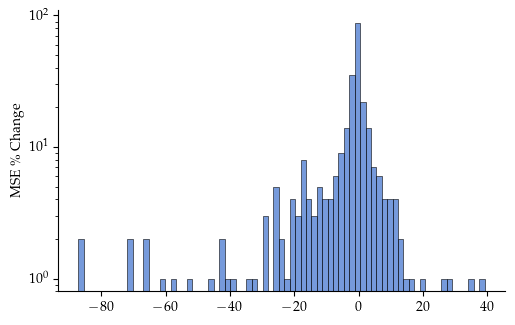

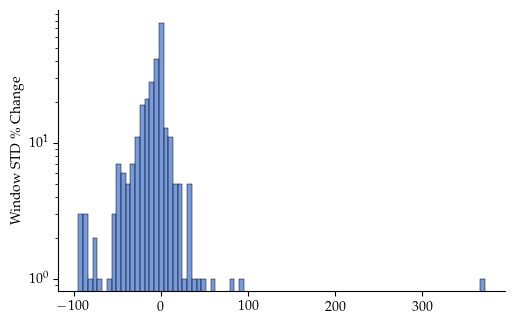

In [318]:
## pd.set_option('display.max_rows',None)

g = sns.displot(pct_diffs_all_ds.sort_values('mse_pct_diff',ascending=True).mse_pct_diff,height=3.5,aspect=1.5)
plt.yscale('log')
plt.title("")
g.set_xlabels("")
g.set_ylabels("MSE \% Change")
g.fig.supxlabel("")
g.fig.tight_layout()
plt.savefig(f"{FIGURES_FOLDER}/histogram_mse_pct_diff.pdf",bbox_inches='tight',dpi=300)
plt.show()

g = sns.displot(pct_diffs_all_ds.sort_values('window_std_pct_diff',ascending=True).window_std_pct_diff,height=3.5,aspect=1.5)
plt.yscale('log')
plt.title("")
g.set_xlabels("")
g.set_ylabels("Window STD \% Change")
g.fig.supxlabel("")
g.fig.tight_layout()
plt.savefig(f"{FIGURES_FOLDER}/histogram_window_std_pct_diff.pdf",bbox_inches='tight',dpi=300)
plt.show()

# g = sns.displot(pct_diffs_all_ds.sort_values('mcv_pct_diff',ascending=True).mcv_pct_diff,height=4,aspect=0.9)
# g.fig.supxlabel("")
# g.fig.tight_layout()
# g.set_xlabels("")
# g.set_ylabels("MCV \% Change")
# plt.title("")
# plt.savefig(f"{FIGURES_FOLDER}/histogram_mcv_pct_diff.pdf",bbox_inches='tight',dpi=300)
# plt.show()

# g = sns.displot(pct_diffs_all_ds.sort_values('monotonic_rate_pct_diff',ascending=True).monotonic_rate_pct_diff,height=4,aspect=0.9)
# g.fig.supxlabel("")
# g.fig.tight_layout()
# g.set_xlabels("")
# g.set_ylabels("Montonic Rate \% Change")
# plt.title("")
# plt.savefig(f"{FIGURES_FOLDER}/histogram_monotonic_rate_pct_diff.pdf",bbox_inches='tight',dpi=300)
# plt.show()

## Who was the party spoiler

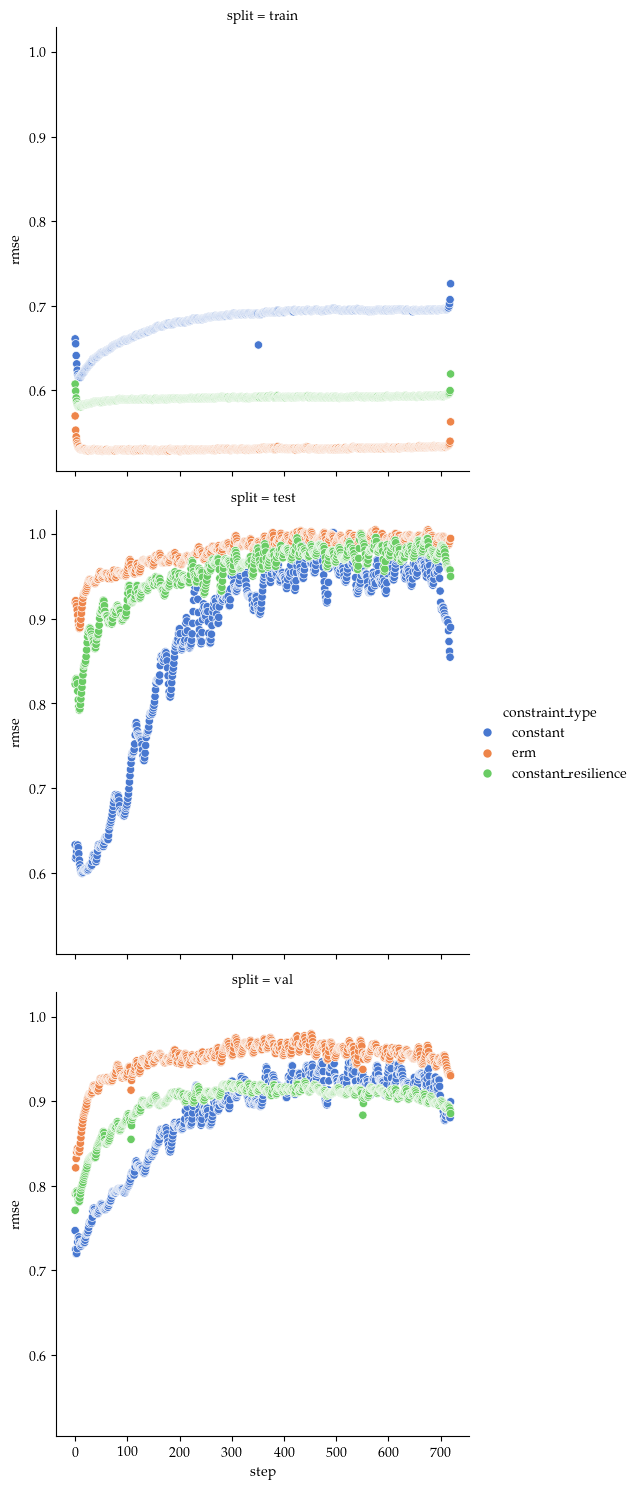

In [289]:
dd=df_to_plot.query('model=="Reformer" and data_path=="weather.csv" and pred_len==720')
sns.relplot(
    dd,
    x='step',
    y='rmse',
    hue='constraint_type',
    row='split'
)

In [290]:
pct_diffs_all_ds.sort_values('window_std_pct_diff',ascending=False)

NameError: name 'pct_diffs_all_ds' is not defined

In [ ]:
pct_diffs_all_ds.describe().reset_index()[['index','mse_pct_diff','window_std_pct_diff']]

### Exploring bimodal distribution of pred len MSE % changes.

In [ ]:
dd=pct_diffs_all_ds.query('pred_len in [96,192,336,720]').copy()
# Second mode of pred len 96
dd=dd.query('mse_pct_diff >  -80 and mse_pct_diff < -30 and pred_len==96')
display(dd[['model','data_path','constant_mse','erm_mse','mse_pct_diff']])
sns.displot(data=dd,x='mse_pct_diff',hue='pred_len',palette='muted',kind='hist',aspect=1.2,height=3.4)

In [ ]:
dd=pct_diffs_all_ds.query('pred_len in [96,192,336,720]').copy()
# Second mode of pred len 96
dd=dd.query('mse_pct_diff >  -100 and mse_pct_diff < -50 and pred_len==720')
display(dd[['model','data_path','constant_mse','erm_mse','mse_pct_diff']].head())
sns.displot(data=dd,x='mse_pct_diff',hue='pred_len',palette='muted',kind='kde',aspect=1.2,height=3.4)

### Correlation: Model

#### Correlations of model strength and % changes: Do stronger models improve with constraints?
Sort models by ERM MSE then see how MSE % DIFF and window % DIFF behave.

In [291]:
model_summary_pct_diff=pct_diffs_all_ds.groupby('model').mean().reset_index().sort_values('erm_mse',ascending=True)[['model','erm_mse','mse_pct_diff','window_std_pct_diff','mcv_pct_diff']]

model_summary_pct_diff
pd.plotting.scatter_matrix(model_summary_pct_diff)

NameError: name 'pct_diffs_all_ds' is not defined

In [ ]:
model_summary_pct_diff.plot.scatter(x='erm_mse',y='window_std_pct_diff')

Window variance is negatively correlated with erm mse, but mse and mcv are positively correlated.

In [292]:
pct_diffs_all_ds.groupby('model').mean().reset_index()[['erm_mse','mse_pct_diff','window_std_pct_diff','mcv_pct_diff']].corr()

NameError: name 'pct_diffs_all_ds' is not defined

### PAPER: Boxplots pct changes per variable

In [319]:
dataset_ranks=pct_diffs_all_ds.groupby('data_path')['erm_mse'].mean().sort_values().reset_index().reset_index().rename(columns={'index':'data_path_rank'})[['data_path','data_path_rank']]
dataset_ranks

data_path  data_path_rank
0       electricity.csv               0
1             ETTm2.csv               1
2           weather.csv               2
3             ETTh2.csv               3
4           traffic.csv               4
5             ETTm1.csv               5
6             ETTh1.csv               6
7     exchange_rate.csv               7
8  national_illness.csv               8

/var/folders/02/rwff5ttj1r9_5hnh3k8rm7tr0000gq/T/ipykernel_81610/2768055403.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g=sns.boxplot(data=to_plot,x=dimension,y=metric,
/var/folders/02/rwff5ttj1r9_5hnh3k8rm7tr0000gq/T/ipykernel_81610/2768055403.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(), rotation=70,fontsize=10)


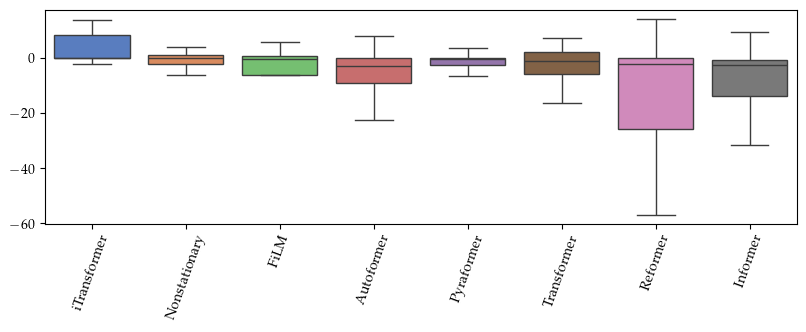

/var/folders/02/rwff5ttj1r9_5hnh3k8rm7tr0000gq/T/ipykernel_81610/2768055403.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g=sns.boxplot(data=to_plot,x=dimension,y=metric,
/var/folders/02/rwff5ttj1r9_5hnh3k8rm7tr0000gq/T/ipykernel_81610/2768055403.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(), rotation=70,fontsize=10)


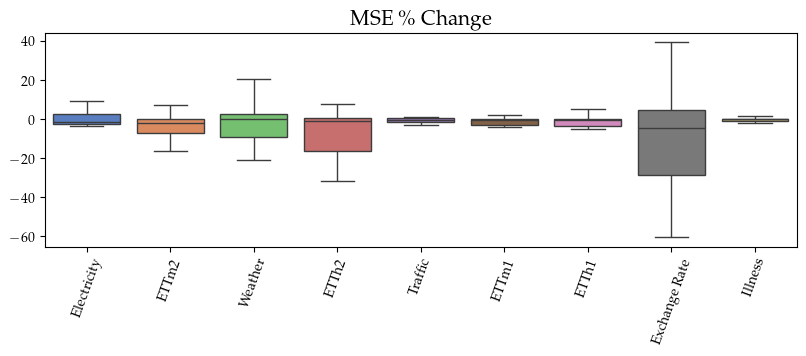

/var/folders/02/rwff5ttj1r9_5hnh3k8rm7tr0000gq/T/ipykernel_81610/2768055403.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g=sns.boxplot(data=to_plot,x=dimension,y=metric,
/var/folders/02/rwff5ttj1r9_5hnh3k8rm7tr0000gq/T/ipykernel_81610/2768055403.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(), rotation=70,fontsize=10)


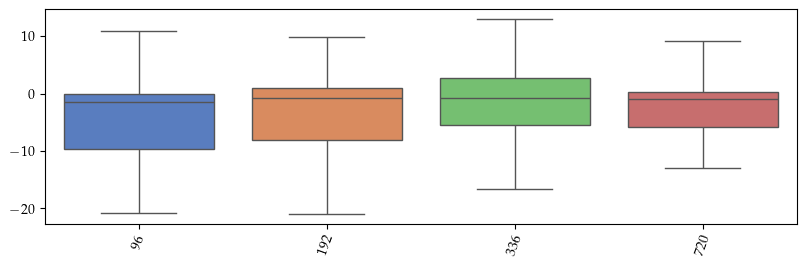

/var/folders/02/rwff5ttj1r9_5hnh3k8rm7tr0000gq/T/ipykernel_81610/2768055403.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g=sns.boxplot(data=to_plot,x=dimension,y=metric,
/var/folders/02/rwff5ttj1r9_5hnh3k8rm7tr0000gq/T/ipykernel_81610/2768055403.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(), rotation=70,fontsize=10)


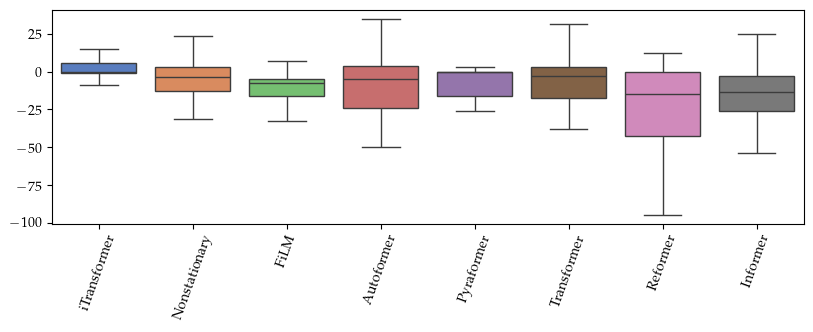

/var/folders/02/rwff5ttj1r9_5hnh3k8rm7tr0000gq/T/ipykernel_81610/2768055403.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g=sns.boxplot(data=to_plot,x=dimension,y=metric,
/var/folders/02/rwff5ttj1r9_5hnh3k8rm7tr0000gq/T/ipykernel_81610/2768055403.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(), rotation=70,fontsize=10)


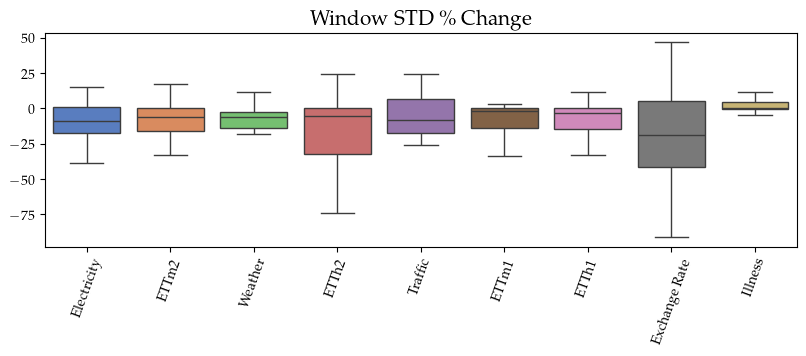

/var/folders/02/rwff5ttj1r9_5hnh3k8rm7tr0000gq/T/ipykernel_81610/2768055403.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g=sns.boxplot(data=to_plot,x=dimension,y=metric,
/var/folders/02/rwff5ttj1r9_5hnh3k8rm7tr0000gq/T/ipykernel_81610/2768055403.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(), rotation=70,fontsize=10)


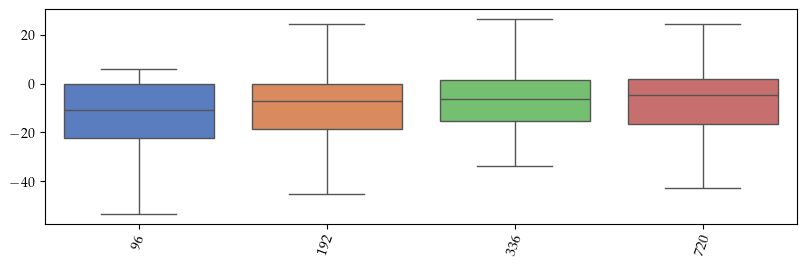

In [329]:
def dimension_preproc(data,dimension):
    """ Preprocesses the dataset depending on the dimenison and prettifies dataset names for visualization """
    if dimension=="pred_len":
            to_plot = data.query('pred_len in [96,192,336,720]').copy()
    else: 
            to_plot = data.copy()
    to_plot['data_path']=to_plot.data_path.apply(pretty_name_dataset)
    to_plot['model'] = to_plot.model.str.replace("Nonstationary_Transformer","Nonstationary")
    return to_plot

#sns.displot(data=pct_diffs_all_ds.query('pred_len in [96,192,336,720]'),x='mse_pct_diff',col='pred_len')
metrics = ['mse_pct_diff', 'window_std_pct_diff']#, 'monotonic_rate_pct_diff']
fancy_metrics = {
    'mse_pct_diff':"MSE \% Change", 
    'window_std_pct_diff': "Window STD \% Change"
}
dimensions = ['model','data_path','pred_len']
fancy_dimensions = {
    'model': 'Model',
    'data_path': 'Dataset',
    'pred_len': 'Prediction Length'
}
# model rank column for sorting (best by overall MSE)
model_ranks=pct_diffs_all_ds.groupby('model')['erm_mse'].mean().sort_values().reset_index().reset_index().rename(columns={'index':'model_rank'})[['model','model_rank']]
# hardest datasets first (this  sorting doesn't make sense because their MSEs are not comparable!)
# TODO: a better way of ranking them would be by how much the models disagree.
dataset_ranks=pct_diffs_all_ds.groupby('data_path')['erm_mse'].mean().sort_values(ascending=True).reset_index().reset_index().rename(columns={'index':'data_path_rank'})[['data_path','data_path_rank']]

for metric in metrics: 
    for dimension in dimensions:
        to_plot = dimension_preproc(pct_diffs_all_ds,dimension)
        # display(Markdown(f"#### {fancy_metrics[metric]} per {dimension}"))
        # display(to_plot.groupby(dimension)[metric].mean().reset_index().sort_values(metric,ascending=True))
for metric in metrics: 
    for dimension in dimensions:
        # preproc
        to_plot=pct_diffs_all_ds
        to_plot=to_plot.merge(dataset_ranks,on='data_path')
        to_plot=to_plot.merge(model_ranks,on='model')
        to_plot = dimension_preproc(to_plot,dimension)
        
        #g = sns.displot(data=to_plot,x=metric,hue=dimension,palette='muted',kind='kde',aspect=1.2,height=3.4)
        # Sorting by rank if not predlen
        if dimension!="pred_len":
            to_plot = to_plot.sort_values(f'{dimension}_rank',ascending=True)
        # plotting
        #plt.figure(figsize=(12, 10))
        plt.figure(figsize=(9.7, 3.7))
        #TODO if this is still painful do catplot
        g=sns.boxplot(data=to_plot,x=dimension,y=metric,
                      palette='muted',
                      #showfliers=True,
                      showfliers=False,
                      
                      )#last arg removes outliers
        
        #asteriks
        g.set_xticklabels(g.get_xticklabels(), rotation=70,fontsize=10)
        #g = sns.displot(data=pct_diffs_all_ds,x=metric,hue=dimension)
        if dimension=='data_path': #hack to get titles only on the top plot of the latex
            plt.title(f"{fancy_metrics[metric]}",fontsize=15)
        g.set_xlabel("")
        #g.set_ylabel(fancy_metrics[metric])
        g.set_ylabel("")
        if metric!="pred_len": #adjust model and data so that labels aren't cutoff
            plt.subplots_adjust(bottom=0.3)
        #g.set_titles(row_template='{row_name}')
        #g.set_titles(template="{row_name} ({col_name})")
        # g.fig.supylabel("MSE")
        #g.fig.suptitle(f'{pretty_name_dataset(data_path)}')
        #display(pct_diffs_all_ds.groupby(dimension)[metric].mean().reset_index().sort_values(metric,ascending=True))
        plt.savefig(f"{FIGURES_FOLDER}/boxplot_{metric}_{dimension}.pdf")
        plt.show()

### Random Forest Feature importance Computation

In [295]:
# #TODO WIP
# #pct_diffs_all_ds.query('pred_len in [96,192,336,720]').
# correlation_with_mse = pct_diffs_all_ds.corrwith(y)  # y being the MSE column
# print(correlation_with_mse.sort_values(ascending=False))
from sklearn.ensemble import RandomForestRegressor

X = pct_diffs_all_ds.query('pred_len in [96,192,336,720]')
y = X.mse_pct_diff
from sklearn.preprocessing import OneHotEncoder
encoded = []
encoders = {}
for col in ['model','data_path','pred_len']:
    encoder = OneHotEncoder(sparse=False)
    category_encoded = encoder.fit_transform(X[col].to_numpy().reshape(-1,1))
    encoded.append(pd.DataFrame(category_encoded,columns=encoder.get_feature_names_out()))
    encoders[col] = encoder
X = pd.concat(encoded,axis=1)

# Assuming X is your features and y is your MSE
model = RandomForestRegressor()
model.fit(X, y)

# Get feature importances
importances = model.feature_importances_

# To see the feature importance in a more interpretable form:
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)

ModuleNotFoundError: No module named 'sklearn'

In [296]:
from sklearn.inspection import permutation_importance
r = permutation_importance(model, X, y,
                            n_repeats=30,
                            random_state=0)
permuted_importances = pd.DataFrame(list(zip(X.columns,r.importances_mean)),columns=['feature_val','importance']).sort_values('importance',ascending=False)
# for i in r.importances_mean.argsort()[::-1]:
#      if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
#          print(f"{diabetes.feature_names[i]:<8}"
#                f"{r.importances_mean[i]:.3f}"
#                f" +/- {r.importances_std[i]:.3f}")

ModuleNotFoundError: No module named 'sklearn'

### USEFUL: RANDOM FOREST PERMUTED FEATURE IMPORTANCES

In [297]:
val_to_feat={}
for m in ['model','data_path','pred_len']:
    val_to_feat={**val_to_feat,**dict(zip(encoders[m].get_feature_names_out(),[m]*len(encoders[m].get_feature_names_out())))}
permuted_importances['feature'] = permuted_importances.feature_val.map(val_to_feat)
permuted_importances
permuted_importances.groupby('feature')['importance'].mean().sort_values(ascending=False).reset_index()

NameError: name 'encoders' is not defined

In [298]:
# unpermuted importances just to compare. Indeed they are different. and their relationship changes.
feature_importance_df['feature_parent'] = feature_importance_df["Feature"].map(val_to_feat)
feature_importance_df.groupby('feature_parent')['Importance'].mean().sort_values(ascending=False).reset_index()

NameError: name 'feature_importance_df' is not defined

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder

# Your dataset filtered by 'pred_len'
X = pct_diffs_all_ds.query('pred_len in [96, 192, 336, 720]')
y = X.mse_pct_diff

# Store encoders and the data they encode
encoders = {}
encoded_data_frames = []

# Columns to encode
columns_to_encode = ['model', 'data_path', 'pred_len']

for col in columns_to_encode:
    encoder = OneHotEncoder(sparse=False)
    category_encoded = encoder.fit_transform(X[col].to_numpy().reshape(-1, 1))
    # Create a DataFrame for the encoded data with feature names
    encoded_df = pd.DataFrame(category_encoded, columns=[f"{col}_{category}" for category in encoder.categories_[0]])
    encoded_data_frames.append(encoded_df)
    encoders[col] = encoder  # Store encoder for later use

# Concatenate all the encoded DataFrames horizontally (along columns)
X_encoded = pd.concat(encoded_data_frames, axis=1)

# Fit the RandomForest model
model = RandomForestRegressor()
model.fit(X_encoded, y)

# Retrieve feature importances
importances = model.feature_importances_

# Aggregate feature importances by original column name
importance_dict = {col: 0 for col in columns_to_encode}
for col, importance in zip(X_encoded.columns, importances):
    # Extract the original column name and sum the importances
    original_col_name = col.split('_')[0]
    importance_dict[original_col_name] += importance

# Convert aggregated importance data into a DataFrame for nicer display
aggregated_importances_df = pd.DataFrame(list(importance_dict.items()), columns=['Feature', 'Aggregated Importance']).sort_values(by='Aggregated Importance', ascending=False)

print(aggregated_importances_df)


### PAPER?: Heatmap dataset vs model improvement

In [299]:
means_per_model_datapath=pct_diffs_all_ds \
    .groupby(["model", "data_path"]) \
    .mean() \
    .reset_index()


NameError: name 'pct_diffs_all_ds' is not defined

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming pct_diffs_all_ds is your dataset, you would load it into a DataFrame. For demonstration, here's how you'd read it from a CSV file:

# Here, you would replace the next line with your actual data variable
# For example: df = pct_diffs_all_ds

# Pivot the DataFrame to format it for the heatmap

#heatmap_data = pct_diffs_all_ds.groupby(["model", "data_path"]).mean().reset_index().pivot(["model", "data_path", "mse_pct_diff"])
heatmap_data = (
    pct_diffs_all_ds \
    .groupby(["model", "data_path"]) \
    .mean() \
    .reset_index() \
    .pivot(index="data_path", columns="model", values="mse_pct_diff")
)


# Plotting the heatmap
plt.figure(figsize=(10, 8))
from matplotlib.colors import LinearSegmentedColormap
#green_red = LinearSegmentedColormap.from_list("green_red", ["green", "red"])
#sns.heatmap(heatmap_data, annot=True, cmap=green_red, fmt=".2f",center=0)
sns.heatmap(heatmap_data, annot=True, cmap='RdBu_r', fmt=".2f",center=0,vmin=-20,vmax=20)
plt.title('Heatmap of MSE % Difference (ERM vs Constrained) by Model and Dataset')
plt.ylabel('Model')
plt.xlabel('Dataset')
plt.show()
# Write out into the figures folder
plt.savefig(f"{FIGURES_FOLDER}/heatmap_mse_pct_diff.png")

## DELETEME BROKEN: Pivot tables ERM Vs Constrained vs Resilience

In [240]:
#selected_columns = df.columns[df.columns.get_level_values('model').isin(['Autoformer', 'FiLM'])]
#result_table.loc[:,selected_columns]
#result_table.columns.get_level_values('model').isin(["Autoformer"])
#selected_columns = result_table.columns[result_table.columns.get_level_values(2).isin(['Autoformer', 'FiLM'])]
first_cols=result_table.columns.get_level_values(2).isin(result_table.columns.get_level_values(2)[:12])
second_cols=result_table.columns.get_level_values(2).isin(result_table.columns.get_level_values(2)[12:])

display(result_table.loc[:,first_cols])
display(result_table.loc[:,second_cols])

metric                         window_std                                    \
type                          Constrained        ERM Resilience Constrained   
model                          Autoformer Autoformer Autoformer        FiLM   
data_path            pred_len                                                 
ETTh1.csv            96           0.03235    0.02408    0.01907     0.06369   
                     192          0.14082    0.13863    0.33752     0.06403   
                     336          0.10875    0.08268    0.02810     0.06290   
                     720          0.27824    0.55710    1.20761     0.13372   
ETTh2.csv            96           0.02876    0.04113    0.02844     0.04321   
                     192          0.02298    0.01460    0.04748     0.05022   
                     336          0.02026    0.07877    0.07325     0.05059   
                     720          0.08816    0.07077    0.04479     0.06674   
ETTm1.csv            96           0.06066    0.06293    0.06458     0.05428   
                     192          0.09323    0.09063    0.03847     0.07671   
                     336          0.06282    0.06186    0.03326     0.09757   
                     720          0.06115    0.06208    0.05460     0.09381   
ETTm2.csv            96           0.02403    0.03370    0.02014     0.02492   
                     192          0.02518    0.02705    0.02618     0.03204   
                     336          0.03787    0.04051    0.03195     0.04582   
                     720          0.06107    0.05199    0.07227     0.06097   
electricity.csv      96           0.01513    0.01549    0.01303     0.03067   
                     192          0.02132    0.02168    0.02034     0.02927   
                     336          0.03856    0.04303    0.01952     0.03706   
                     720          0.03020    0.03475    0.15605     0.05310   
exchange_rate.csv    96           0.08517    0.08068    0.04897     0.04383   
                     192          0.11480    1.34894    0.11517     0.09593   
                     336          0.20957    2.13358    0.20785     0.17700   
                     720          0.74336    1.03797    0.31953     0.48525   
national_illness.csv 24           0.14001    0.11299    0.20286     0.60151   
                     36           0.21257    0.19749    0.34241     0.54749   
                     48           0.23680    0.30843    0.37615     0.61459   
                     60           0.56607    0.56091    0.39808     0.40313   
traffic.csv          96           0.01878    0.02263    0.02360         NaN   
                     192          0.02644    0.03585    0.04723         NaN   
                     336          0.02852    0.03122    0.02732         NaN   
                     720          0.03999    0.03611    0.06372         NaN   
weather.csv          96           0.03337    0.06001    0.03105     0.04289   
                     192          0.05091    0.05253    0.04459     0.05457   
                     336          0.06345    0.06787    0.06459     0.07031   
                     720          0.07436    0.07902    0.06060     0.08863   

metric                                                                   \
type                                ERM Resilience Constrained      ERM   
model                              FiLM       FiLM    Informer Informer   
data_path            pred_len                                             
ETTh1.csv            96        0.070390    0.05217     0.12226  0.18317   
                     192       0.073190    0.05219     0.18328  0.21063   
                     336       0.074860    0.05261     0.15604  0.18053   
                     720       0.142390    0.12566     0.16922  0.17014   
ETTh2.csv            96        0.045630    0.04065     0.10965  0.13777   
                     192       0.053300    0.04755     0.15466  0.25092   
                     336       0.053880    0.04934     0.09664  0.20256   
              

metric                         window_std                                    \
type                          Constrained        ERM Resilience Constrained   
model                          Pyraformer Pyraformer Pyraformer    Reformer   
data_path            pred_len                                                 
ETTh1.csv            96           0.07395    0.07395    0.06280     0.04532   
                     192          0.08244    0.08244    0.07161     0.03952   
                     336          0.13046    0.15288    0.14584     0.02932   
                     720          0.17275    0.17029    0.13978     0.04395   
ETTh2.csv            96           0.08220    0.08220    0.04508     0.04294   
                     192          0.29078    0.29167    0.27536     0.04079   
                     336          0.21579    0.21154    0.16254     0.04644   
                     720          0.14408    0.14408    0.04022     0.09494   
ETTm1.csv            96           0.12740    0.12740    0.10819     0.08170   
                     192          0.10397    0.10397    0.08154     0.05885   
                     336          0.11734    0.11734    0.08693     0.06944   
                     720          0.11341    0.12233    0.10605     0.04365   
ETTm2.csv            96           0.03771    0.03771    0.02963     0.03615   
                     192          0.06029    0.06029    0.04602     0.05240   
                     336          0.13373    0.10581    0.10920     0.05743   
                     720          0.22229    0.22229    0.15671     0.14809   
electricity.csv      96           0.01526    0.01943    0.01494     0.01064   
                     192          0.01923    0.02156    0.01633     0.01960   
                     336          0.02533    0.03421    0.02079     0.02302   
                     720          0.01581    0.01534    0.01459     0.00720   
exchange_rate.csv    96           0.10529    0.17541    0.13001     0.12137   
                     192          0.13931    0.35995    0.27782     0.14834   
                     336          0.09536    0.17877    0.20321     0.15435   
                     720          0.16281    0.78785    0.17027     0.28018   
national_illness.csv 24           1.09151    1.09151    1.07418     0.45962   
                     36           0.89339    0.93144    0.92886     0.77191   
                     48           0.88246    0.86186    0.85456     0.42279   
                     60           0.78306    0.78102    0.77213     0.39776   
traffic.csv          96           0.02602    0.03200    0.02108     0.02054   
                     192          0.01279    0.01620    0.01376     0.02037   
                     336          0.01140    0.01548    0.01327     0.01578   
                     720          0.01635    0.01634    0.01608     0.01008   
weather.csv          96           0.05251    0.05570    0.05167     0.08552   
                     192          0.08477    0.09617    0.08418     0.11710   
                     336          0.09834    0.10686    0.10381     0.15780   
                     720          0.13216    0.15564    0.13366     0.18394   

metric                                                                      \
type                               ERM Constrained         ERM  Resilience   
model                         Reformer Transformer Transformer Transformer   
data_path            pred_len                                                
ETTh1.csv            96        0.05808     0.12022     0.14607     0.09560   
                     192       0.07743     0.13034     0.16634     0.08682   
                     336       0.06250     0.13671     0.12283     0.11658   
                     720       0.04455     0.11575     0.09311     0.12138   
ETTh2.csv            96        0.26240     0.03640     0.04969     0.03598   
                     192       0.71824     0.05809     0.05328     0.06197   
                     336       0.33217     0.06409     0.06

In [295]:
def style_pivot_table_best_per_params(pivoted_df):
    pivoted_df=pivoted_df.copy()
    pivoted_df.columns.names = ['metric','type','model']
    mask = pd.DataFrame(False, index=pivoted_df.index, columns=pivoted_df.columns)
    for keys,subset in  pivoted_df.groupby(level=['metric','model'],axis=1):
        mask.loc[:,subset.columns] = subset.eq(subset.min(axis=1), axis=0)
        
    ##STYLE
    # truncate to 4 decimals for display
    pivoted_df=pivoted_df.style.format("{:.4f}")
    pivoted_df=pivoted_df.apply(lambda s: ['font-weight: bold;text-decoration: underline' if v else '' for v in mask.loc[s.name]], axis=1)
    return pivoted_df

def data_path_renaming(x):
    if x=="exchange_rate.csv":
        x='Exchange'
    x=x.replace(".csv","")
    if x=="electricity":
        x="ECL"
    else: 
        x=x.replace(".csv","").replace("_"," ").title()
    return latex_scaffolding_dataset(x)
def latex_scaffolding_dataset(x):
    # Add rotatebox
    x=r'\rotatebox'+'{90}{'+x+'}'
    x=r'\multirow{4}{*}{'+x+'}'
    return x
def text_bf(x):
    return r'\textbf{'+x+'}'
def latex_style_best(pivoted_df):#TODO broken
    pivoted_df=pivoted_df.copy()
    pivoted_df.columns.names = ['metric','type','model']
    mask = pd.DataFrame(False, index=pivoted_df.index, columns=pivoted_df.columns)
    for keys,subset in  pivoted_df.groupby(level=['metric','model'],axis=1):
        mask.loc[:,subset.columns] = subset.eq(subset.min(axis=1), axis=0)
    #if mask is true, add text_bf
    pivoted_df=pivoted_df.apply(lambda s: [text_bf(v) if v else '' for v in mask.loc[s.name]], axis=1)
    return pivoted_df


pd.set_option('display.max_columns', None)
def compute_pivot_over_metric(summary_metrics,pivot_value_columns=['window_std'],split='test'):
    pivoted_tables=[]
    data_paths=summary_metrics.data_path.unique()
    for data_path in data_paths:
        tp2=summary_metrics.query(f'data_path==@data_path and split==@split').copy()

        #GROUPING TEH VALS
        grouped_values=tp2.groupby(['pred_len','model','type'])[[
            'mse',
            'mcv',
            'std_mse',
            'std_mcv',
            'mean_infeasible_rate',
            'std_infeasible_rate',
            'window_std'
            ]].mean().reset_index()
        
        # Pivot of models versus constrained and ERM, values are mse and mse_diff
        all_results = grouped_values
        
        # Pivot all results, sort ascending by pred_len, then mean_violation on constrained
        pivoted=all_results.pivot(
            index=['pred_len'],
            columns=['type','model'], 
            values=pivot_value_columns
        )
        
        pivoted=style_pivot_table_best_per_params(pivoted)
        #display(pivoted)
        pivoted_tables.append(pivoted)
    result_table = pd.concat([d.data for d in pivoted_tables],keys=data_paths,names=['data_path'])

    return result_table
display(Markdown(f"# Pivot tables for split=test"))
for metric in [
    'mse',
    'mcv',
    #'mean_infeasible_rate',
    'window_std',
    ]:
    result_table = compute_pivot_over_metric(summary_metrics,pivot_value_columns=[metric],split='test')
    display(Markdown(f"## {metric}"))
    # add bold
    display(style_pivot_table_best_per_params(result_table))
    
    first_cols=result_table.columns.get_level_values(2).isin(result_table.columns.get_level_values(2)[:12])
    second_cols=result_table.columns.get_level_values(2).isin(result_table.columns.get_level_values(2)[12:])

    for result_table_portion in [result_table.loc[:,first_cols],result_table.loc[:,second_cols]]:
        #latex styling
        latex_table=result_table_portion.copy()

        latex_table.index=latex_table.index \
            .set_levels([data_path_renaming(level) for level in latex_table.index.levels[0]],level=0)

        #TODO FIX the styling function to add textbf
        #latex_table=latex_style_best(latex_table)
        # drop the metric level in the multiindex
        latex_table.columns=latex_table.columns.droplevel(0)

        # Swap the column multiindex to model on top
        latex_table=latex_table.swaplevel(0,1,axis=1)

        #latex_table=style_pivot_table_best_per_params(latex_table)
        # Show only :.4f
        latex_table=latex_table.applymap(lambda x: f"{x:.4f}")
        # Rename data_path to None
        latex_table=latex_table.rename_axis(index={'data_path':None,'pred_len':''},columns={'model':'','type':''})
        #display(latex_table.columns)
        # refactor the multiindex in columns so that repeated models merge
        #print(latex_table.to_latex(escape=False,index_names=False,multicolumn_format='c',multicolumn=True))
        print(latex_table.to_latex(escape=False,multicolumn_format='c',multicolumn=True))


# Pivot tables for split=test

/var/folders/02/rwff5ttj1r9_5hnh3k8rm7tr0000gq/T/ipykernel_4921/3179654489.py:5: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  for keys,subset in  pivoted_df.groupby(level=['metric','model'],axis=1):
/var/folders/02/rwff5ttj1r9_5hnh3k8rm7tr0000gq/T/ipykernel_4921/3179654489.py:5: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  for keys,subset in  pivoted_df.groupby(level=['metric','model'],axis=1):
/var/folders/02/rwff5ttj1r9_5hnh3k8rm7tr0000gq/T/ipykernel_4921/3179654489.py:5: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  for keys,subset in  pivoted_df.groupby(level=['metric','model'],axis=1):
/var/folders/02/rwff5ttj1r9_5hnh3k8rm7tr0000gq/T/ipykernel_4921/3179654489.py:5: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  for keys,subset i

## mse

/var/folders/02/rwff5ttj1r9_5hnh3k8rm7tr0000gq/T/ipykernel_4921/3179654489.py:5: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  for keys,subset in  pivoted_df.groupby(level=['metric','model'],axis=1):


\begin{tabular}{llllllllllllll}
\toprule
 &  & \multicolumn{3}{c}{Autoformer} & \multicolumn{3}{c}{FiLM} & \multicolumn{3}{c}{Informer} & \multicolumn{3}{c}{Nonstationary_Transformer} \\
 &  & Constrained & ERM & Resilience & Constrained & ERM & Resilience & Constrained & ERM & Resilience & Constrained & ERM & Resilience \\
 &  &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
\multirow[t]{4}{*}{\multirow{4}{*}{\rotatebox{90}{Etth1}}} & 96 & 0.6444 & 0.6787 & 0.6065 & 0.4592 & 0.4677 & 0.5143 & 0.7997 & 0.8896 & 0.8117 & 0.6234 & 0.6234 & 0.5853 \\
 & 192 & 0.8378 & 0.8686 & 1.0845 & 0.5136 & 0.5239 & 0.5613 & 1.0403 & 1.1789 & 0.9871 & 0.6468 & 0.6468 & 0.6108 \\
 & 336 & 0.8963 & 0.8525 & 0.6529 & 0.5671 & 0.5778 & 0.6120 & 1.2317 & 1.2370 & 1.3335 & 0.8187 & 0.8525 & 0.8423 \\
 & 720 & 1.0515 & 1.1069 & 1.2740 & 0.7319 & 0.7510 & 0.7689 & 1.2770 & 1.2776 & 1.2851 & 0.9744 & 0.9674 & 0.8986 \\
\cline{1-14}
\multirow[t]{4}{*}{\multirow{4}{*}{\rotatebox{90}{Etth2}}} & 96 & 0.2613 & 0.314

/var/folders/02/rwff5ttj1r9_5hnh3k8rm7tr0000gq/T/ipykernel_4921/3179654489.py:107: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  latex_table=latex_table.applymap(lambda x: f"{x:.4f}")
/var/folders/02/rwff5ttj1r9_5hnh3k8rm7tr0000gq/T/ipykernel_4921/3179654489.py:5: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  for keys,subset in  pivoted_df.groupby(level=['metric','model'],axis=1):
/var/folders/02/rwff5ttj1r9_5hnh3k8rm7tr0000gq/T/ipykernel_4921/3179654489.py:5: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  for keys,subset in  pivoted_df.groupby(level=['metric','model'],axis=1):
/var/folders/02/rwff5ttj1r9_5hnh3k8rm7tr0000gq/T/ipykernel_4921/3179654489.py:5: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  for keys,subset in  pivoted_df.groupby(level=['metric','mod

## mcv

/var/folders/02/rwff5ttj1r9_5hnh3k8rm7tr0000gq/T/ipykernel_4921/3179654489.py:5: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  for keys,subset in  pivoted_df.groupby(level=['metric','model'],axis=1):


/var/folders/02/rwff5ttj1r9_5hnh3k8rm7tr0000gq/T/ipykernel_4921/3179654489.py:107: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  latex_table=latex_table.applymap(lambda x: f"{x:.4f}")
/var/folders/02/rwff5ttj1r9_5hnh3k8rm7tr0000gq/T/ipykernel_4921/3179654489.py:5: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  for keys,subset in  pivoted_df.groupby(level=['metric','model'],axis=1):
/var/folders/02/rwff5ttj1r9_5hnh3k8rm7tr0000gq/T/ipykernel_4921/3179654489.py:5: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  for keys,subset in  pivoted_df.groupby(level=['metric','model'],axis=1):
/var/folders/02/rwff5ttj1r9_5hnh3k8rm7tr0000gq/T/ipykernel_4921/3179654489.py:5: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  for keys,subset in  pivoted_df.groupby(level=['metric','mod

\begin{tabular}{llllllllllllll}
\toprule
 &  & \multicolumn{3}{c}{Autoformer} & \multicolumn{3}{c}{FiLM} & \multicolumn{3}{c}{Informer} & \multicolumn{3}{c}{Nonstationary_Transformer} \\
 &  & Constrained & ERM & Resilience & Constrained & ERM & Resilience & Constrained & ERM & Resilience & Constrained & ERM & Resilience \\
 &  &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
\multirow[t]{4}{*}{\multirow{4}{*}{\rotatebox{90}{Etth1}}} & 96 & 0.1115 & 0.1459 & 0.0735 & 0.1343 & 0.1435 & 0.1884 & 0.0000 & 0.0015 & 0.0000 & 0.2027 & 0.2027 & 0.1640 \\
 & 192 & 0.5318 & 0.5626 & 0.7785 & 0.1335 & 0.1446 & 0.1801 & 0.0603 & 0.1475 & 0.0201 & 0.1683 & 0.1683 & 0.1316 \\
 & 336 & 0.3043 & 0.2607 & 0.0609 & 0.1221 & 0.1350 & 0.1646 & 0.8197 & 0.8250 & 0.9214 & 0.6247 & 0.6585 & 0.6482 \\
 & 720 & 0.5976 & 0.6529 & 0.8200 & 0.3073 & 0.3269 & 0.3441 & 0.8310 & 0.8316 & 0.8391 & 0.7484 & 0.7414 & 0.6726 \\
\cline{1-14}
\multirow[t]{4}{*}{\multirow{4}{*}{\rotatebox{90}{Etth2}}} & 96 & 0.0000 & 0.000

## window_std

/var/folders/02/rwff5ttj1r9_5hnh3k8rm7tr0000gq/T/ipykernel_4921/3179654489.py:5: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  for keys,subset in  pivoted_df.groupby(level=['metric','model'],axis=1):


\begin{tabular}{llllllllllllll}
\toprule
 &  & \multicolumn{3}{c}{Autoformer} & \multicolumn{3}{c}{FiLM} & \multicolumn{3}{c}{Informer} & \multicolumn{3}{c}{Nonstationary_Transformer} \\
 &  & Constrained & ERM & Resilience & Constrained & ERM & Resilience & Constrained & ERM & Resilience & Constrained & ERM & Resilience \\
 &  &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
\multirow[t]{4}{*}{\multirow{4}{*}{\rotatebox{90}{Etth1}}} & 96 & 0.0323 & 0.0241 & 0.0191 & 0.0637 & 0.0704 & 0.0522 & 0.1223 & 0.1832 & 0.1143 & 0.0598 & 0.0598 & 0.0534 \\
 & 192 & 0.1408 & 0.1386 & 0.3375 & 0.0640 & 0.0732 & 0.0522 & 0.1833 & 0.2106 & 0.1276 & 0.0863 & 0.0863 & 0.0807 \\
 & 336 & 0.1087 & 0.0827 & 0.0281 & 0.0629 & 0.0749 & 0.0526 & 0.1560 & 0.1805 & 0.2005 & 0.2074 & 0.1869 & 0.2091 \\
 & 720 & 0.2782 & 0.5571 & 1.2076 & 0.1337 & 0.1424 & 0.1257 & 0.1692 & 0.1701 & 0.1925 & 0.1605 & 0.1705 & 0.1643 \\
\cline{1-14}
\multirow[t]{4}{*}{\multirow{4}{*}{\rotatebox{90}{Etth2}}} & 96 & 0.0288 & 0.041

/var/folders/02/rwff5ttj1r9_5hnh3k8rm7tr0000gq/T/ipykernel_4921/3179654489.py:107: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  latex_table=latex_table.applymap(lambda x: f"{x:.4f}")


### Comparing variance and CoV ERM vs constrained

In [301]:
# Calculate mean and std for mse and constraint_violation. Rename them mean_{metric} and std_{metric
#ToDO filter one seeed and split
stepwise_metrics = df_to_plot[df_to_plot.constraint_idx.isin([0,2])].query("split=='test'").groupby([
    "run_id",
    "Algorithm", #Harmless carryover col for legacy purposes (verified the counts are the same)
    "model",'type',
    "constraint_level",
    "constraint_idx",
    "pred_len",
    "data_path",
    "split",
    'step'#STEPWISE
    ])['mse','constraint_violation','infeasible_rate','run_id'].aggregate(
        mse=('mse','mean'),
        #std_mse=('mse','std'),
        mcv=('constraint_violation','mean'),
        #std_mcv=('constraint_violation','std'),
        mean_infeasible_rate=('infeasible_rate','mean'),
        #std_infeasible_rate=('infeasible_rate','std'),
        run_count=('run_id','nunique')
        ).reset_index().round(5)
summary_stepwise=stepwise_metrics.groupby([
    "run_id",
    "Algorithm", #Harmless carryover col for legacy purposes (verified the counts are the same)
    "model",
    'type',
    "constraint_level",
    "constraint_idx",
    "pred_len",
    "data_path",
    "split"]).aggregate(
        mse=('mse','mean'),
        std_mse=('mse','std'),
        mcv=('mcv','mean'),
        std_mcv=('mcv','std'),
        mean_infeasible_rate=('mean_infeasible_rate','mean'),
        std_infeasible_rate=('mean_infeasible_rate','std'),
        run_count=('run_count','mean'),
        step_count=('step','count')
    ).reset_index()
summary_stepwise

ValueError: Cannot subset columns with a tuple with more than one element. Use a list instead.

In [ ]:
summary_stepwise.groupby(['run_id','type','constraint_idx',"Algorithm","model"]).size().reset_index()

In [302]:
dd_weather = summary_stepwise.query('data_path=="weather.csv" and pred_len==96').copy()
dd_weather.groupby(['run_id','constraint_idx',"Algorithm","model","constraint_idx"])
#dd_weather.pivot(index=['run_id','constraint_idx',"Algorithm","model","constraint_idx"], columns='type', values='mse')

NameError: name 'summary_stepwise' is not defined

#### Pivot tables stepwise

In [303]:
#Note, variance is nan because there is only one run per parameter set
weather = summary_stepwise.query('data_path=="weather.csv"').copy()
electricity = summary_stepwise.query('data_path=="electricity.csv"').copy()
for name,dataset in [('weather',weather), ('electricity',electricity)]:
    display(Markdown(f"# {name}"))
    tp2=dataset.copy(deep=True)
    #tp2=weather.query('split=="test"').copy()
    # Compute 'infeasible amount' as the difference between the mse and the constraint_level, 0 if mse < constraint
    
    # Split into constrained and ERM
    tp2_constrained=tp2.query('type=="Constrained"').copy()
    tp2_erm_baseline=tp2.query('type=="ERM"').copy()

    distinct_constraints = tp2_constrained[['pred_len','model','constraint_level']].drop_duplicates()

    #GROUPING TEH VALS
    grouped_values=tp2.groupby(['pred_len','constraint_level','constraint_idx','model','type'])[[
        'mse','mcv',
        'std_mse','std_mcv',
        'mean_infeasible_rate','std_infeasible_rate']].mean().reset_index()

    # Pivot of models versus constrained and ERM, values are mse and mse_diff
    all_results = grouped_values#pd.concat([grouped_constrained,grouped_erm_baseline_broadcasted],axis=0)
    # Pivot all results, sort ascending by pred_len, then mean_violation on constrained

    pivoted=all_results.pivot(
        #index=['pred_len','constraint_idx'], 
        index=['pred_len'], 
        columns=['type','model'],
        values=['mse','std_mse','mcv','std_mcv','mean_infeasible_rate','std_infeasible_rate']
    ).query('constraint_level>0').round(4)
    simplified = all_results.pivot(
        index=['pred_len','constraint_level'],
        columns=['type','model'],
        values=['mse','mcv']
    )
    pd.set_option('display.max_columns', None)
    print("SIMPLIFIED 192 MSE")
    # show all pred lengths (index)
    for pred_len in [96, 192, 336, 720]:    
        print(simplified.index.get_level_values(0).unique())
        simp_mse_192=simplified[simplified.index.get_level_values(0)==pred_len][['mse']]
        sim_mcv_192=simplified[simplified.index.get_level_values(0)==pred_len][['mcv']]

        # Flatten the multiindex
        def prettify(d):
            d = d.copy()
            d.columns = d.columns.map('_'.join)
            return d.style.format(precision=3)
        # display(prettify(simp_mse_192))
        print(f"SIMPLIFIED {pred_len} MCV")
        display(prettify(sim_mcv_192))
    print("FULL")
    display(pivoted)
    #reformer works best on weather.

NameError: name 'summary_stepwise' is not defined

## Pivots per dataset

# Dev:

## Debugging which runs have mismatched in constant and constrained.

In [304]:
# 1. Count unique runs for each model, dataset, prediction length, constraint index, and constraint level after removing duplicate run IDs
constraints_per_set = df_to_plot_nogs.query('constraint_type=="constant"').drop_duplicates('run_id').groupby(['model', 'data_path', 'pred_len', 'constraint_idx', 'constraint_level', 'seed'])['run_id'].nunique().reset_index()
constraints_per_set_resilience = df_to_plot_nogs.query('constraint_type=="constant_resilience"').drop_duplicates('run_id').groupby(['model', 'data_path', 'pred_len', 'constraint_idx', 'constraint_level', 'seed'])['run_id'].nunique().reset_index()

# Drop duplicates because some runs were added twice. :shrug.
constraints_per_set = constraints_per_set.drop_duplicates(['model', 'data_path', 'pred_len', 'constraint_idx', 'constraint_level'])
constraints_per_set_resilience = constraints_per_set_resilience.drop_duplicates(['model', 'data_path', 'pred_len', 'constraint_idx', 'constraint_level'])

# 2. Find the experiment settings ('model', 'data_path', 'pred_len') that are different in constant and constant_resilience 
# They should have the same set of constraint levels

# Create a set of constraint levels for each combination of model, data_path, pred_len
constraint_levels_set = constraints_per_set.groupby(['model', 'data_path', 'pred_len'])['constraint_level'].apply(set).reset_index()
constraint_levels_set_resilience = constraints_per_set_resilience.groupby(['model', 'data_path', 'pred_len'])['constraint_level'].apply(set).reset_index()

constraint_levels_set_resilience

# # Merge the sets to compare
merged_sets = constraint_levels_set.merge(constraint_levels_set_resilience, on=['model', 'data_path', 'pred_len'], suffixes=('_constant', '_resilience'), indicator=True)
# # Find discrepancies in the sets of constraint levels
def find_discrepancies(row):
    if row['_merge'] == 'both':
        return row['constraint_level_constant'] != row['constraint_level_resilience']
    return True

merged_sets['discrepancy'] = merged_sets.apply(find_discrepancies, axis=1)
merged_sets
# # Filter rows with discrepancies
discrepancies = merged_sets[merged_sets['discrepancy']]

# # Display the discrepancies
discrepancies = discrepancies[['model', 'data_path', 'pred_len', 'constraint_level_constant', 'constraint_level_resilience', '_merge']]
discrepancies

merged_sets['discrepancies'] = merged_sets.apply(lambda row: row['constraint_level_constant'].symmetric_difference(row['constraint_level_resilience']), axis=1)
merged_sets[merged_sets.discrepancy]

model          data_path  pred_len  \
16     Autoformer    electricity.csv        96   
17     Autoformer    electricity.csv       192   
18     Autoformer    electricity.csv       336   
19     Autoformer    electricity.csv       720   
22     Autoformer  exchange_rate.csv       336   
..            ...                ...       ...   
279  iTransformer        traffic.csv       720   
280  iTransformer        weather.csv        96   
281  iTransformer        weather.csv       192   
282  iTransformer        weather.csv       336   
283  iTransformer        weather.csv       720   

                      constraint_level_constant  \
16     {0.113, 0.12, 0.117, 0.16, 0.151, 0.166}   
17    {0.14, 0.154, 0.174, 0.184, 0.143, 0.202}   
18    {0.155, 0.207, 0.197, 0.167, 0.163, 0.24}   
19   {0.174, 0.228, 0.218, 0.185, 0.177, 0.244}   
22    {0.285, 0.379, 0.539, 0.763, 0.83, 1.126}   
..                                          ...   
279                       {0.253, 0.269, 0.279}   
280                       {0.348, 0.439, 0.408}   
281                        {0.418, 0.47, 0.501}   
282                        {0.475, 0.54, 0.599}   
283                       {0.578, 0.653, 0.682}   

                    constraint_level_resilience _merge  discrepancy  \
16    {0.111, 0.118, 0.115, 0.16, 0.151, 0.166}   both         True   
17   {0.139, 0.184, 0.174, 0.153, 0.144, 0.202}   both         True   
18    {0.151, 0.163, 0.197, 0.207, 0.159, 0.24}   both         True   
19    {0.176, 0.218, 0.228, 0.183, 0.19, 0.244}   both         True   
22       {0.25, 0.763, 0.83, 0.33, 0.46, 1.126}   both         True   
..                                          ...    ...          ...   
279                 {0.253, 0.357, 0.411, 0.49}   both         True   
280  {0.348, 0.386, 0.472, 0.439, 0.408, 0.518}   both         True   
281   {0.418, 0.47, 0.478, 0.501, 0.537, 0.559}   both         True   
282          {0.475, 0.54, 0.702, 0.623, 0.599}   both         True   
283  {0.578, 0.629, 0.682, 0.653, 0.786, 0.845}   both         True   

                                 discrepancies  
16   {0.118, 0.12, 0.111, 0.115, 0.113, 0.117}  
17   {0.139, 0.143, 0.153, 0.144, 0.14, 0.154}  
18                {0.151, 0.167, 0.159, 0.155}  
19   {0.176, 0.177, 0.185, 0.183, 0.19, 0.174}  
22     {0.25, 0.33, 0.46, 0.285, 0.379, 0.539}  
..                                         ...  
279         {0.269, 0.357, 0.411, 0.49, 0.279}  
280                      {0.386, 0.472, 0.518}  
281                      {0.478, 0.537, 0.559}  
282                             {0.702, 0.623}  
283                      {0.629, 0.786, 0.845}  

[70 rows x 8 columns]

### Duplicate runs per setup

In [305]:
# 1. Count unique runs for each model, dataset, prediction length, constraint index, and constraint level after removing duplicate run IDs
constraints_per_set = df_to_plot_nogs.query('constraint_type=="constant"').drop_duplicates('run_id').groupby(['model','data_path','pred_len','constraint_idx','constraint_level','seed'])['run_id'].nunique().reset_index()
# Should have only one run per set
constraints_per_set.query('run_id>1')

# Debugging one. 
# df_to_plot_nogs.query(
#     "model == 'Autoformer' and data_path == 'ETTm2.csv' and pred_len == 720 and "
#     "constraint_level == 0.397 and split=='train' and constraint_type=='constant'"
# )[['run_id','model','data_path','pred_len','constraint_level','constraint_idx','seed','step','mse']]

Empty DataFrame
Columns: [model, data_path, pred_len, constraint_idx, constraint_level, seed, run_id]
Index: []

# Experiment master table
To check which experiments have been run and which are missing
Copy into this excel sheet for viz: https://docs.google.com/spreadsheets/d/1f1eIOoAA21jtm4lPUmLyxLWVHSuMQBzTesuZTTU-aT8/edit#gid=0

In [257]:
df.shape
real_df_resilience.shape

# Has all the run settings in resilience and nonresilience datasets
unique_run_settings = pd.concat([
    real_df_resilience.drop_duplicates(['run_id','model', 'data_path', 'pred_len','constraint_type', 'constraint_idx', 'constraint_level', 'seed']),
    df.drop_duplicates(['run_id','model', 'data_path', 'pred_len', 'constraint_type', 'constraint_idx', 'constraint_level', 'seed'])
],axis=0)

# For reference
unique_run_settings['constraint_idx_meaning'] = unique_run_settings['constraint_idx'].replace({
    -1: "ERM", 
    1: "Train 25\%", 
    2: "Train 50\%", 
    3: "Train 75\%", 
    4: "Val 25\%", 
    5: "Val 50\%", 
    6: "Val 75\%"  
})



# Get the full combination that we're expecting. 
base_df = unique_run_settings.copy()
base_df['constraint_level']=base_df['constraint_level'].fillna(-1)
constraint_type=base_df.constraint_type.unique()
models=df_to_plot.model.unique()
split=base_df.split.unique()
data_paths=base_df.query("data_path!='national_illness.csv'").data_path.unique()
pred_lens = [96, 192, 336, 720] 
illness_pred_lens = [24, 36, 48, 60] #ILLNESS
# Create a dataframe with all expected keys by crossjoining
keys = ['model','pred_len','constraint_type','split','data_path']
#print(len(models)*len(pred_lens)*len(constraint_type)*len(split)*len(data_paths))
df_keys_minus_illness = pd.DataFrame(list(itertools.product(*[models,pred_lens,constraint_type,split,data_paths])),columns=keys)

#.fillna({'mse':filler,'mae':filler,'rmse':filler,'window_std':filler})
filler=9999


# new pivot (unique constraint level)
print(pd.pivot_table(
    df_keys_minus_illness.merge(base_df,how='left',on=keys),
    index=['model', 'data_path', 'pred_len'],
    columns=['constraint_type'],
    values=['constraint_level'],
    fill_value=0,
    aggfunc='nunique'
).to_csv())

# print(pd.pivot_table(
#     df_keys_minus_illness.merge(base_df,how='left',on=keys),
#     index=['model', 'data_path', 'pred_len'],
#     columns=['constraint_type'],
#     values=['constraint_level'],
#     fill_value=0,
#     aggfunc=set
# ).reset_index().to_csv(sep="|"))

#List of run pivot
# full_expected_runs = 
#old pivot 
# print(pd.pivot_table(
#     unique_run_settings,
#     index=['constraint_type','model', 'data_path', 'pred_len'],
#     columns=['constraint_idx_meaning'],
#     values=['run_id'],
#     fill_value=0,
#     aggfunc=list
# ).to_csv())


,,,constraint_level,constraint_level,constraint_level
constraint_type,,,constant,constant_resilience,erm
model,data_path,pred_len,,,
Autoformer,ETTh1.csv,96,6,6,1
Autoformer,ETTh1.csv,192,6,6,1
Autoformer,ETTh1.csv,336,6,6,1
Autoformer,ETTh1.csv,720,6,6,1
Autoformer,ETTh2.csv,96,6,6,1
Autoformer,ETTh2.csv,192,6,6,1
Autoformer,ETTh2.csv,336,6,6,1
Autoformer,ETTh2.csv,720,6,6,1
Autoformer,ETTm1.csv,96,6,6,1
Autoformer,ETTm1.csv,192,6,6,1
Autoformer,ETTm1.csv,336,6,6,1
Autoformer,ETTm1.csv,720,6,6,1
Autoformer,ETTm2.csv,96,6,6,1
Autoformer,ETTm2.csv,192,6,6,1
Autoformer,ETTm2.csv,336,6,6,1
Autoformer,ETTm2.csv,720,6,6,1
Autoformer,electricity.csv,96,6,6,1
Autoformer,electricity.csv,192,6,6,1
Autoformer,electricity.csv,336,6,6,1
Autoformer,electricity.csv,720,6,6,1
Autoformer,exchange_rate.csv,96,6,6,1
Autoformer,exchange_rate.csv,192,6,6,1
Autoformer,exchange_rate.csv,336,6,6,1
Autoformer,exchange_rate.csv,720,6,6,1
Autoformer,traffic.csv,96,6,6,1
Autoformer,traffic.csv,192,6,6,1
Autoform

In [307]:
#iTransformer	electricity.csv	96	3	6	0
real_df_all_rebuttal_experiments.query("model=='iTransformer' and data_path=='electricity.csv' and constraint_type=='erm'")
df.query("model=='iTransformer' and data_path=='electricity.csv' and constraint_type=='erm'")[['data_path','model','constraint_type']]
real_df_all_rebuttal_experiments.query("model=='iTransformer' and data_path=='electricity.csv' and constraint_type=='erm'").constraint_level

2690712   NaN
2690713   NaN
2690714   NaN
2690715   NaN
2690716   NaN
           ..
2700931   NaN
2700932   NaN
2700933   NaN
2700934   NaN
2700935   NaN
Name: constraint_level, Length: 4032, dtype: float64

In [308]:
real_df_all_rebuttal_experiments_raw.query('run_id=="96g9613j"')
df.query('run_id=="96g9613j"')
real_df_all_rebuttal_experiments_resilience.query('run_id=="96g9613j"')
df_to_plot.query('run_id=="96g9613j"')

Empty DataFrame
Columns: [run_id, des, gpu, itr, d_ff, data, freq, loss, seed, c_out, embed, lradj, model, revin, affine, dec_in, distil, enc_in, factor, stride, target, d_model, devices, dropout, dual_lr, n_heads, seq_len, use_amp, use_gpu, d_layers, e_layers, features, model_id, n_hashes, patience, pred_len, sampling, data_path, dual_clip, dual_init, label_len, patch_len, pct_start, root_path, wandb_run, activation, batch_size, do_predict, eval_steps, fc_dropout, individual, moving_avg, bucket_size, checkpoints, is_training, kernel_size, num_workers, head_dropout, resilient_lr, train_epochs, decomposition, learning_rate, padding_patch, subtract_last, use_multi_gpu, wandb_project, experiment_tag, constraint_type, constraint_level, constraint_slope, output_attention, constraint_offset, resilient_cost_alpha, epoch, infeasible_rate, infeasibles, split, run_name, Algorithm, type, sweep_id, sweep_name, linearity_overall, mae_overall, rmse_overall, pct_50_total_test, pct_50_total_val, pct_75_total_test, pct_75_total_val, pct_95_total_test, pct_95_total_val, pct_99_total_test, pct_99_total_val, pointwise/cvar/001, pointwise/cvar/005, pointwise/iqr, pointwise/max, pointwise/quantile/09, pointwise/quantile/095, pointwise/quantile/099, ...]
Index: []

In [309]:
# Autoformer 720 exchange constant
df_to_plot.query("model=='Autoformer' and data_path=='exchange_rate.csv' and pred_len==720 and constraint_type=='constant'")[['data_path','model','constraint_type','constraint_idx','constraint_level']]

data_path       model constraint_type  constraint_idx  \
157248  exchange_rate.csv  Autoformer        constant             4.0   
157968  exchange_rate.csv  Autoformer        constant             4.0   
158688  exchange_rate.csv  Autoformer        constant             4.0   
157249  exchange_rate.csv  Autoformer        constant             4.0   
157969  exchange_rate.csv  Autoformer        constant             4.0   
...                   ...         ...             ...             ...   
158686  exchange_rate.csv  Autoformer        constant             4.0   
159406  exchange_rate.csv  Autoformer        constant             4.0   
157967  exchange_rate.csv  Autoformer        constant             4.0   
158687  exchange_rate.csv  Autoformer        constant             4.0   
159407  exchange_rate.csv  Autoformer        constant             4.0   

        constraint_level  
157248             1.024  
157968             1.024  
158688             1.024  
157249             1.024  
157969             1.024  
...                  ...  
158686             1.024  
159406             1.024  
157967             1.024  
158687             1.024  
159407             1.024  

[2160 rows x 5 columns]

## WIP: Are val-based constraints better when generalization gap is high?
1. Find which settings chose a val constraint.
2. compute generalization gap (summary train - test)
3. Correlate GG with constraint_idx?

In [210]:
#summary_metrics.query('constraint_idx > 3')
summary_metrics['is_optimal_val_constraint'] = summary_metrics.constraint_idx > 3
summary_metrics.groupby('is_optimal_val_constraint').size().reset_index()

summary_train = summary_metrics.query('split=="train"').reset_index()
summary_test = summary_metrics.query('split=="test"').reset_index()

# Compute generalization gap (groupby split, do a custom aggregation)
erm_generalization_gap_per_setting=summary_metrics.query('constraint_type=="erm"').pivot(index=['model','data_path','pred_len','constraint_type','constraint_idx'],columns=['split'],values=['mse'])#.reset_index()
erm_generalization_gap_per_setting.columns = ['_'.join(col).strip() for col in erm_generalization_gap_per_setting.columns.values]
erm_generalization_gap_per_setting=erm_generalization_gap_per_setting.reset_index()
erm_generalization_gap_per_setting['generalization_gap'] = (erm_generalization_gap_per_setting['mse_test'] - erm_generalization_gap_per_setting['mse_train'])/erm_generalization_gap_per_setting['mse_train']

# rename value
erm_generalization_gap_per_setting.rename(columns={0:'generalization_gap'},inplace=True)
erm_generalization_gap_per_setting['has_high_gap'] = erm_generalization_gap_per_setting.generalization_gap > 1

summary_metrics['is_optimal_val_constraint'] = summary_metrics.constraint_idx > 3
summary_metrics['is_optimal_train_constraint'] = summary_metrics.constraint_idx <= 3

# merging
constant_run_summaries = summary_metrics.query('constraint_type=="constant"')
gg_vs_optimal_constraint = erm_generalization_gap_per_setting.merge(constant_run_summaries,on=['model','data_path','pred_len','constraint_idx'],how='inner')
#summary_metrics.query('constraint_type=="constant"').groupby('is_optimal_val_constraint')['generalization_gap'].mean()

#generalization_gap_per_setting.query('constraint_type=="constant"').groupby('is_optimal_train_constraint')['generalization_gap'].mean()
gg_vs_optimal_constraint.shape,constant_run_summaries.shape,erm_generalization_gap_per_setting.shape

((864, 28), (864, 22), (288, 10))

In [212]:
gg_vs_optimal_constraint.groupby('has_high_gap')['constraint_idx'].mean()

has_high_gap
False    2.525253
True     3.164021
Name: constraint_idx, dtype: float64

The average generalization gap is higher when the optimal constraint comes from the validation set:

In [219]:
gg_vs_optimal_constraint.groupby('is_optimal_val_constraint')['generalization_gap'].mean()

is_optimal_val_constraint
False    3.069817
True     4.481140
Name: generalization_gap, dtype: float64

Means of normalized ERM generalization gap ((train-test)/train) by constraint_idx (the optimal).

In [214]:
gg_vs_optimal_constraint.groupby('constraint_idx')['generalization_gap'].mean().reset_index()#['generalization_gap']

constraint_idx  generalization_gap
0               1            2.084562
1               2            4.634889
2               3            3.925185
3               4            3.979085
4               5            6.327042
5               6            3.787983

In [218]:
gg_vs_optimal_constraint.groupby(['data_path','is_optimal_val_constraint'])['generalization_gap'].mean().reset_index()

data_path  is_optimal_val_constraint  generalization_gap
0              ETTh1.csv                      False            1.351930
1              ETTh1.csv                       True            2.135594
2              ETTh2.csv                      False            0.636424
3              ETTh2.csv                       True            2.310919
4              ETTm1.csv                      False            4.235163
5              ETTm1.csv                       True            3.441918
6              ETTm2.csv                      False            1.944590
7              ETTm2.csv                       True            2.316667
8        electricity.csv                      False            0.815962
9        electricity.csv                       True            0.965397
10     exchange_rate.csv                      False           10.854878
11     exchange_rate.csv                       True           13.129374
12  national_illness.csv                      False            8.308741
13  national_illness.csv                       True            8.234814
14           traffic.csv                      False            1.408027
15           weather.csv                      False            0.491430
16           weather.csv                       True            0.931133

Conclusion: No evidence that higher gap tends to correlate with doing better on validation constraints. 